# Detekcija transakcijskih prevara korištenjem strojnog učenja

## Uvod
<h3>Cilj</h3>
<p>
    U ovoj bilježnici pokušat ćemo što preciznije odrediti je li neka transakcija prevara ili nije. 
    Prepoznavanje kartičnih prevara je važno jer se u današnjem vremenu sve više transakcija odvija elektroničkim putem pa je 
    potrebno da banke i slične institucije što bolje čuvaju korisnikove resurse te pronalaze transakcije koje su prevare.
</p>
<h3>Podaci</h3>
<p>
    Skup podataka preuzet je sa Kagglea. U tom skupu podataka je navedeno da su svi podaci prikupljeni u Europi tijekom rujna 
    2013-te godine. Svi podaci su prikupljeni tokom 2 dana te je napomenuto da se sastoji od preko 280 000 transakcija
    od kojih je samo 492 prevare. Također je napomenuto da je nad svim značajkama osim 'Amount' i 'Time' primjenjena PCA (Principal Component Analysis, hrv. metoda osnovnih komponenata) transformacija. Tih 28 značajki je također preimenovano u 'V1, ..., V28' zbog sigurnosnih razloga. Značajka 'Time' obilježava vrijeme koje je proteklo od prve do neke određene transakcije (u sekundama), dok značajka 'Amount' obilježava kolika je vrijednost transakcije. Imamo i posebnu značajku 'Class' čija je jedina svrha da označi je li transakcija valjana ili je prevara. 
</p>
<h3>Hardver i sofver</h3>
<br>
Hardver: <ul> 
    <li>Operativni sustav: Win10 Home</li>
    <li>Procesor: Intel Core i7 (osma generacija)</li>
    <li>Radna memorija: 8GB</li>
</ul>

Softver: <ul>
    <li>Anaconda Navigator</li>
    <li>Jupyter notebook (Python 3.7)</li>
</ul>

Instalacija dodatnih paketa: <ul>
    <li>imbalanced-learn (rad s neujednačenim klasama)</li>
    <li>py-xgboost (boosting)</li>
    <li>lightgbm (boosting)</li>
    <li>catboost (boosting)</li>
    <li>scikit-learn (0.23.1)</li>
</ul>

Osnovne biblioteke: <ul>
    <li>pandas - alat za rad sa strukturama podataka (učitavanje podataka iz datoteke, transformacija i slično)</li>
    <li>numpy - alat koji olakšava rad sa poljima</li>
    <li>matplotlib - alat koji omogućava grafički prikaz (crtanje grafova)</li>
    <li>seaborn - alat sličan matplotlibu, za neke grafove ga je lakše koristiti</li>
    <li>sklearn - biblioteka koja nam omogućava jednostavno korištenje klasifikacijskih algoritama</li>
    <li>xgboost, lightgbm, catboost - razne biblioteke specijalizirane za boosting algoritme</li>
    
</ul>

In [1]:
#ovdje rupa za navigaciju među kodom

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import time
import math

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
import collections
from decimal import Decimal

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, confusion_matrix, plot_confusion_matrix, roc_curve, auc
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler

## Eksploratorna analiza podataka

<p>Na početku moramo prvo dohvatiti podatke iz datoteke 'creditcard.csv'. Nakon što to napravimo možemo kratko prikazati kakav je otprilike izgled podataka. Kao što smo i ranije naveli za to koristimo biblioteku pandas.</p>

In [5]:
data = pd.read_csv('creditcard.csv')

In [6]:
data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [7]:
data.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.537294e-16  7.959909e-16  5.367590e-16  4.458112e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   1.453003e-15  1.699104e-15 -3.660161e-16 -1.206049e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

In [8]:
data.isnull().sum().any()

False

In [9]:
non_fraud_total = len(data[data['Class'] == 0])
fraud_total = len(data[data['Class'] == 1])
non_fraud_perc = round( non_fraud_total / len(data) * 100, 2)
fraud_perc = round( fraud_total / len(data) * 100, 2)
print('Ukupan broj valjanih transakcija: ' + str(non_fraud_total) + '\n' +
      'Ukupan broj prevara: ' + str(fraud_total))
print('Postotak valjanih transakcija: ' + str(non_fraud_perc) + '%\n' + 
      'Postotak prevara: ' + str(fraud_perc) + '%')

Ukupan broj valjanih transakcija: 284315
Ukupan broj prevara: 492
Postotak valjanih transakcija: 99.83%
Postotak prevara: 0.17%


<p>Nakon učitavanja podataka vidimo da je svaka transakcija obilježena sa oznakom klase (što nam omogućava da znamo je li prevara ili nije) te 30 ostalih značajki, od kojih je 28 anonimizirano da bi se sačuvala privatnost. Iz podataka stoga ne možemo doći do puno informacija. Jedina korisna informacija zasad je da valjane transakcije čine 99.83% svih transakcija što znači da je svega 0.17% prevara. Taj podatak nije neočekivan (na 285 000 ljudi imamo nešto manje od 500 lopova). 
Prikažimo sada podatke pomoću grafova da vidimo možemo li dobiti bolji dojam, o tome kako utječu na to je li transakcija prevara ili nije.</p>

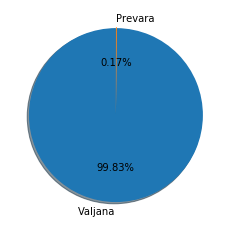

In [10]:
%matplotlib inline
labels = ['Valjana', 'Prevara']
sizes = [len(data[data['Class'] == 0]), len(data[data['Class'] == 1])]
explode = (0, .01)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=90)
 

plt.show()

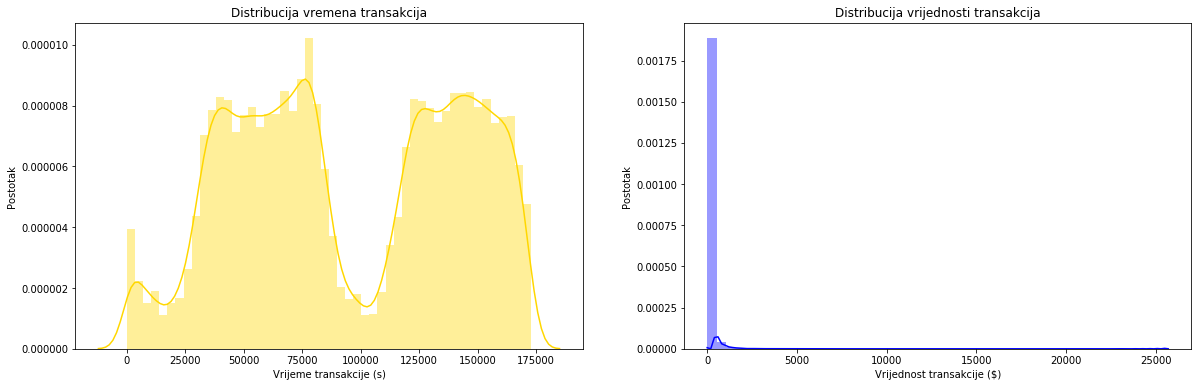

In [11]:
#distribucija vremena i vrijednosti
time_vals = data['Time'].values
amount_vals = data['Amount'].values


fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax2_labels = ['Postotak', 'Vrijeme transakcije (s)', 'Vrijednost transakcije ($)']
ax2[0].set_title('Distribucija vremena transakcija')
ax2[0].set_xlabel(ax2_labels[1])
ax2[0].set_ylabel(ax2_labels[0])
ax2[1].set_title('Distribucija vrijednosti transakcija')
ax2[1].set_xlabel(ax2_labels[2])
ax2[1].set_ylabel(ax2_labels[0])
sns.distplot(time_vals, ax=ax2[0], color='gold')
sns.distplot(amount_vals, ax=ax2[1], color='blue')
plt.show()

<p>Prvo smo odlučili grafovski prikazati atribute 'Time' i 'Amount'. Na lijevom grafu (koji prikazuje kada su se transakcije događale) možemo primjetiti da ima sličan izgled kao grbe na devinim leđima. Razlog tome je što prikazujemo transakcije koje su se događale u periodu od 2 dana pa je vrlo vjerojatno da parabola između dviju grba predstavlja razdoblje noći (tada je puno manje transakcija). Desni graf prikazuje kolike su vrijednosti transakcija (primjerice koliko je novca nekom isplaćeno na bankomatu). Vidimo da je ta vrijednost najgušća na dijelu između 0 i 1000. To je logično jer se ne događa prečesto da ljudi trebaju veću količinu novca za nešto. Analizirajmo podatke s ta dva grafa malo detaljnije</p>  

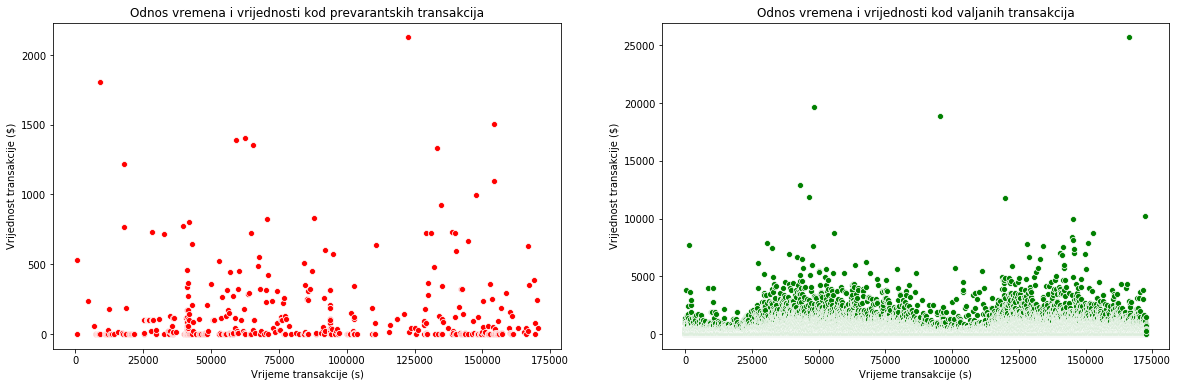

In [12]:
time_fraud = data[data['Class'] == 1]['Time'].values
time_non_fraud = data[data['Class'] == 0]['Time'].values

amount_fraud = data[data['Class'] == 1]['Amount'].values
amount_non_fraud = data[data['Class'] == 0]['Amount'].values

fig3, ax3 = plt.subplots(1,2, figsize=(20,6))
ax3_labels = ['Vrijeme transakcije (s)', 'Vrijednost transakcije ($)']
ax3[0].set_title('Odnos vremena i vrijednosti kod prevarantskih transakcija')
ax3[0].set_xlabel(ax3_labels[0])
ax3[0].set_ylabel(ax3_labels[1])
ax3[1].set_title('Odnos vremena i vrijednosti kod valjanih transakcija')
ax3[1].set_xlabel(ax3_labels[0])
ax3[1].set_ylabel(ax3_labels[1])
sns.scatterplot(time_fraud, amount_fraud, ax=ax3[0], color='r')
sns.scatterplot(time_non_fraud, amount_non_fraud, ax=ax3[1], color='g')
plt.show()

<p>Grafovi iznad prikazuju kakav je odnos između vremena kada su se transakcije odvijale i vrijednosti tih transakcija pri čemu je lijevi graf za transakcije koje su prevare, dok desni graf prikazuje isti odnos samo za valjane transakcije. Iz tih grafova teško je išta zaključiti. Zato je najbolje da ukratko prikažemo brojkama kakve su veze među tim značajkama i klasom koja im je pridjeljena.</p>

In [13]:

amount_mean = round(np.mean(amount_vals),2)
amount_fraud_mean = round(np.mean(amount_fraud),2)
amount_non_fraud_mean = round(np.mean(amount_non_fraud),2)
print('Prosječna vrijednost transakcija = ' + str(amount_mean) + '$' +
     '\nProsječna vrijednost transakcija koje su prevare = ' + str(amount_fraud_mean) + '$' +
     '\nProsječna vrijednost transakcija koje su valjane = ' + str(amount_non_fraud_mean) + '$')
print()
print('Makismalna vrijednost transakcije koja je prevara = ' + str(max(amount_fraud)) + '$'
      +'\nMakismalna vrijednost transakcije koja je valjana = ' + str(max(amount_non_fraud)) + '$')

print()
num_amount_fraud_less_than_mean = np.count_nonzero(amount_fraud < amount_fraud_mean)
num_amount_non_fraud_less_than_mean = np.count_nonzero(amount_non_fraud < amount_non_fraud_mean)
print('Udio prevarantskih transakcija manjih od njihove prosječne vrijednost = ' 
     + str(round(num_amount_fraud_less_than_mean / len(amount_fraud),2)) + '%'
     + '\nUdio valjanih transakcija manjih od njihove prosječne vrijednosti = '
     + str(round(num_amount_non_fraud_less_than_mean / len(amount_non_fraud),2)) + '%')


Prosječna vrijednost transakcija = 88.35$
Prosječna vrijednost transakcija koje su prevare = 122.21$
Prosječna vrijednost transakcija koje su valjane = 88.29$

Makismalna vrijednost transakcije koja je prevara = 2125.87$
Makismalna vrijednost transakcije koja je valjana = 25691.16$

Udio prevarantskih transakcija manjih od njihove prosječne vrijednost = 0.78%
Udio valjanih transakcija manjih od njihove prosječne vrijednosti = 0.77%


<p>Nakon ove detaljnije analize vidimo neke razlike među vrijednostima valjanih i prevarantskih transakcija. Prije svega prosječna vrijednost prevare je za 35\$ veća od prosječne vrijednosti valjane transakcije, što je znantna razlika (prosječna vrijednost prevarantske transakcije je oko 1.4 puta veća od valjane). Također maksimalna vrijednost valjane transakcije je više nego 10 puta veća od maksimalne vrijednosti prevare. Doduše, to nije previše začuđujuće buduće da je to ekstreman slučaj (moguće da je korisnik najveće valjane transakcije kupio novi auto ili remodelirao kuću). Ipak, 2125$ je dosta velika svota novca koja je nekom ukradena samo jednom transakcijom. Prikažimo sada pomoću boxplota razliku između vrijdnosti transakcija koje su valjane i koje nisu.
</p>

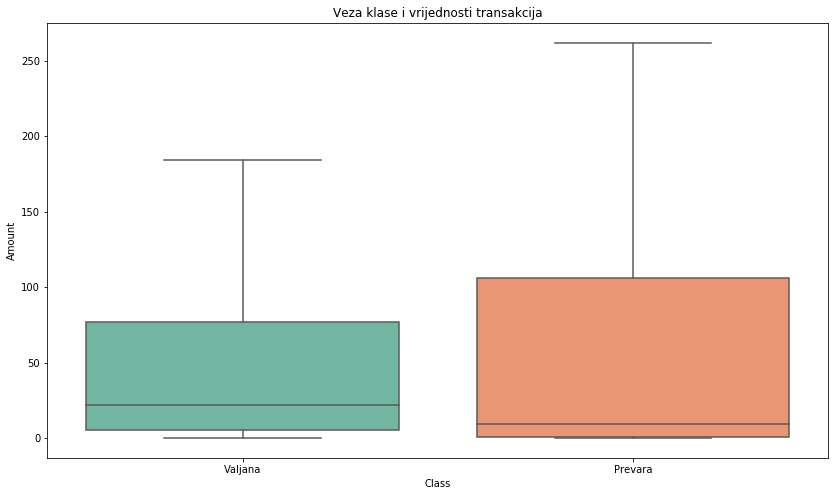

In [14]:
#boxplotat ćemo za bolju vizualnu intuiciju
fig5, ax5 = plt.subplots(1,1,figsize=(14,8))
ax5.set_title('Veza klase i vrijednosti transakcija')
sns.boxplot(data['Class'], data['Amount'],
            showfliers=False, palette='Set2')
plt.xticks([0,1],['Valjana', 'Prevara'])
plt.show()

<p><b>Napomena:</b> Primjetimo da je <i>showfliers</i> postavljena na <i>False</i> kako na boxplotovima ne bi bilo ekstremnih outliera (tada bi cijeli dio između prvog i trećeg kvartila bila samo crta). Ovako vidimo ipak male razlike između kvartila valjanih i prevarantskih transakcija. Sada ćemo napraviti analizu vremenske značajke.</p>

In [15]:
#vrijeme ćemo prikazati u satima da bi lakse razumjeli
time_hours = np.sort(np.ceil((time_vals // 3600) % 24))
time_fraud_hours = np.sort(np.ceil(time_fraud // 3600) % 24)
time_non_fraud_hours = np.sort(np.ceil(time_non_fraud // 3600) % 24)

time_m = np.mean(time_hours)
time_fm = np.mean(time_fraud_hours)
time_nfm = np.mean(time_non_fraud_hours)

time_mean = '{0:02.0f}:{1:02.0f}'.format(*divmod(time_m * 60, 60))
time_fraud_mean = '{0:02.0f}:{1:02.0f}'.format(*divmod(time_fm * 60, 60))
time_non_fraud_mean = '{0:02.0f}:{1:02.0f}'.format(*divmod(time_nfm * 60, 60))

print('Prosječno vrijeme kada su se izvršavale transakcije = ' + str(time_mean)  +
     '\nProsječno vrijeme kada su se izvršavale preverantske transakcije = ' + str(time_fraud_mean) +
     '\nProsječno vrijeme kada su se izvršavale valjane transakcije = ' + str(time_non_fraud_mean))

Prosječno vrijeme kada su se izvršavale transakcije = 14:03
Prosječno vrijeme kada su se izvršavale preverantske transakcije = 11:39
Prosječno vrijeme kada su se izvršavale valjane transakcije = 14:03


<p><b>Napomena</b>: Kod podataka prikazanih iznad uzeta je pretpostavka da je vrijeme izvršavanja prve transakcije bilo u 00:00 prvog dana.</p> 

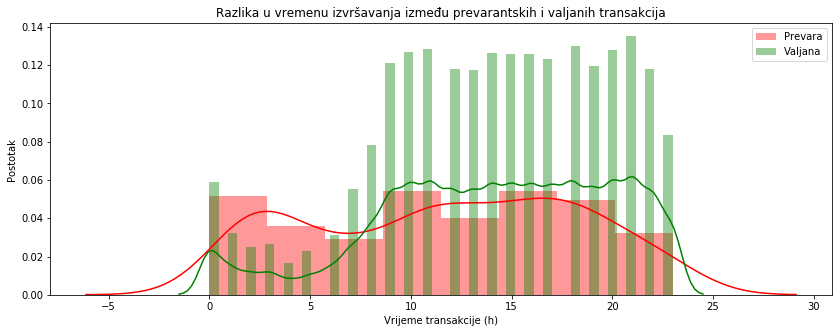

In [16]:
#vrijeme pomoću histograma
fig4, ax4 = plt.subplots(1,1, figsize=(14,5))
ax4_labels = ['Vrijeme transakcije (h)', 'Postotak']
ax4.set_title('Razlika u vremenu izvršavanja između prevarantskih i valjanih transakcija')
ax4.set_xlabel(ax4_labels[0])
ax4.set_ylabel(ax4_labels[1])
sns.distplot(time_fraud_hours, color='r')
sns.distplot(time_non_fraud_hours, color='g')
plt.legend(['Prevara', 'Valjana'])
plt.show()

<p>Iz grafa vidimo da razlike u vremenu nisu previše različite kada usporedimo valjane i prevarantske transakcije. Također, intuitivno se vrijeme izvođenja transakcije ne čini kao značajka koja doprinosi klasifikaciji. Odnosno, prevaranti koji kradu s kartica neće čekat sredinu noći kako bi nekom ukrali novce. Pogledajmo još kakva je veza ostalih značajki i klase koja je pridjeljena transakcijama.</p>

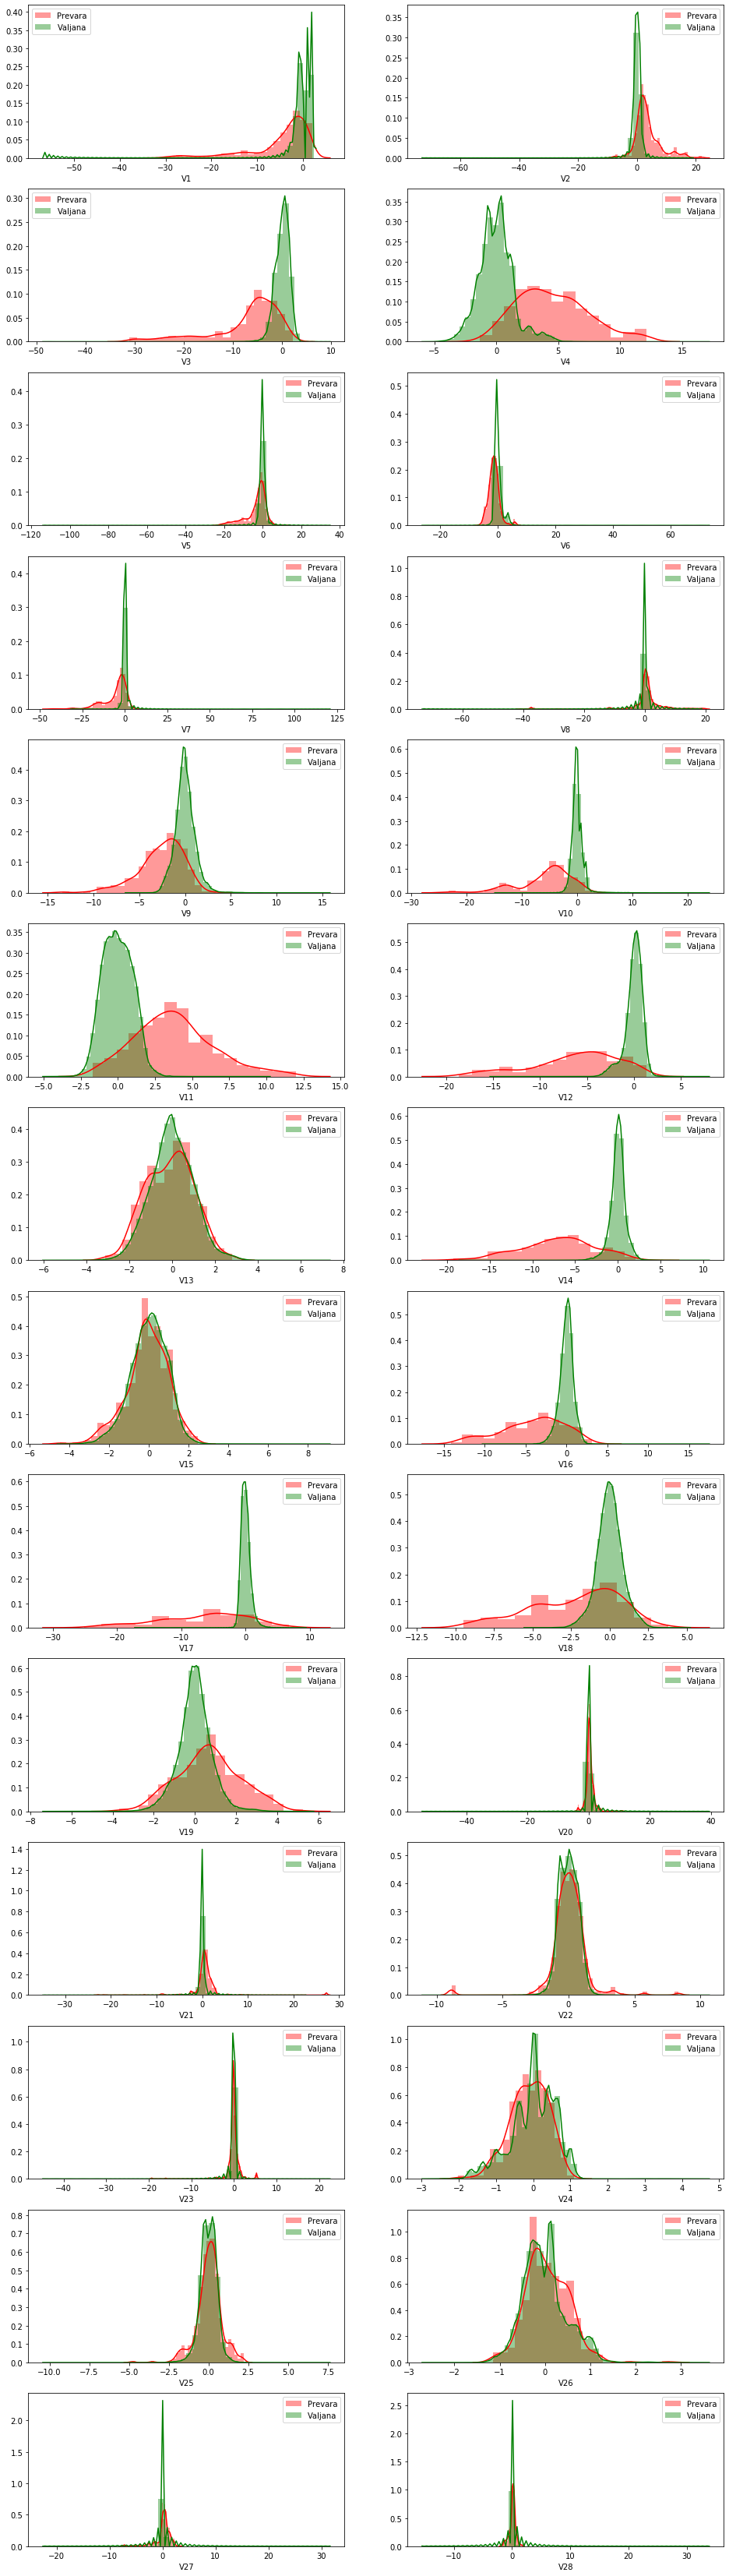

In [17]:
#ostale znacajke (V1-v28)
v_features = data.iloc[:,1:29].columns
plt.figure(figsize=(16,60))

v_grid = gridspec.GridSpec(14, 2)

for i, feature in enumerate(data[v_features]):
    ax6 = plt.subplot(v_grid[i])
    sns.distplot(data[data['Class'] == 1][feature],  color='red') 
    sns.distplot(data[data['Class'] == 0][feature],  color='green')
    plt.legend(['Prevara', 'Valjana'])
plt.show()
    

<p>Primjetimo da se grafovi valjanih i prevarantskih transakcija najviše razlikuju kod značajki: V3, V4, V9, V10, V11, V12, V14, V19. To znači da će vrijednosti tih značajki najviše pridononsiti klasifikaciji novih transakcija (jer su one najuže vezane za to je li neka transakcija prevara ili nije). Prikažimo je međusobnu koreliranost raznih značajki. Za to je najbolje koristiti korelacijsku matricu.</p>

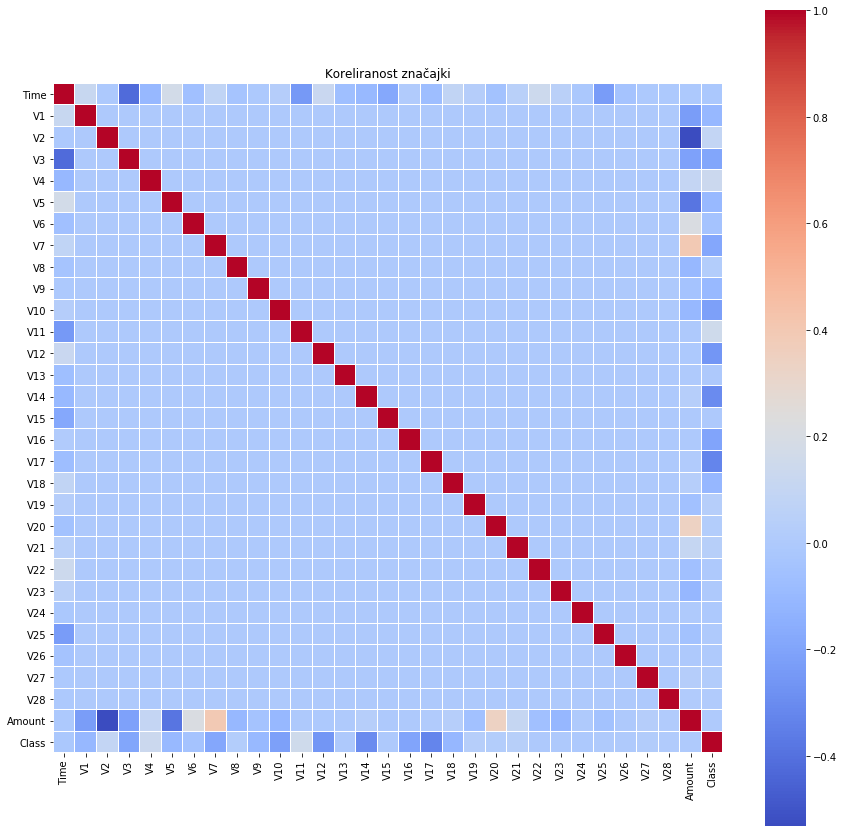

In [18]:
fig7,ax7 = plt.subplots(1,1,figsize=(15,15))
sns.heatmap(data.corr(),linewidths=0.05,vmax=1.0, 
            square=True, cmap = plt.cm.coolwarm, linecolor='white', annot=False)
ax7.set_title('Koreliranost značajki')
plt.show()

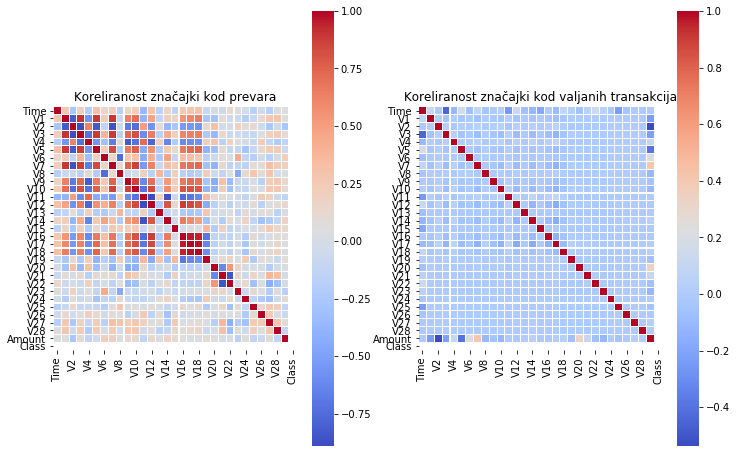

In [19]:
fig8,ax8 = plt.subplots(1,2,figsize=(12,8))
ax8[0].set_title('Koreliranost značajki kod prevara')
ax8[1].set_title('Koreliranost značajki kod valjanih transakcija')
sns.heatmap(data[data['Class'] == 1].corr(), ax=ax8[0], linewidths=0.05,vmax=1.0, 
            square=True, cmap = plt.cm.coolwarm, linecolor='white')
sns.heatmap(data[data['Class'] == 0].corr(), ax=ax8[1], linewidths=0.05,vmax=1.0, 
            square=True, cmap = plt.cm.coolwarm, linecolor='white')
plt.show()

<p>Iz prethodne 3 korelacijske matrice možemo obratiti najviše pozornosti na onu koja prikazuje međusobnu koreliranost značajki kod prevara. Vidimo da kod takvih postoji dosta velika koreliranost (posebno kod anonimiziranih značajki) nekih varijabli koja je nevidljiva na ostale dvije matrice.</p>

In [20]:
#ovdje rupa za jos EDA

### Priprema podataka
<p>Da bismo mogli učiti na podacima moramo ih pripremiti tako da budu u pogodnom obliku. Prije svega, pošto znamo da je nad anonimiziranim značajkama provedena PCA transformacija, moramo skalirati i značajku 'Amount'.
    <br><b>Napomena</b>: Značajku 'Time' ćemo samo izbaciti iz skupa jer smo ranije zaključili da generalno nema veze sa tim je li neka transakcija valjana ili prevara. Nakon skaliranja odbacujemo značajke 'Time' i 'Amount'. Umjesto toga u skup podataka vraćamo značajku 'Amount_Afte_Scaling'.
</p>


In [21]:
#priprema podataka
#skaliranje Time i Amount (pošto je nad drugima vec proveden PCA)

amount_after_scaling = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
#time_after_scaling = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)

In [22]:
#data.insert(0, 'Time_After_Scaling', time_after_scaling)
data.insert(0, 'Amount_After_Scaling', amount_after_scaling)
data.columns

Index(['Amount_After_Scaling', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
       'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Class'],
      dtype='object')

In [23]:
fraud = np.array(data[data['Class'] == 1].index)
non_fraud = np.array(data[data['Class'] == 0].index)
len(fraud), len(non_fraud)

(492, 284315)

<p>Zbog nerazmjera među klasama osim klasičnog učenja na cijelom skupu podataka (koje će često voditi do overfittinga), također ćemo upotrijebiti metode zvane undersampling i oversampling. Te dvije metode ko+ristimo kako bismo ujednačili broj primjera koji pripadaju klasama.</p>

In [24]:
#vidimo da je previse non_fraud pa zato koristimo under sampling
non_fraud_undersample = np.array(np.random.choice(non_fraud, len(fraud), replace=False))
len(non_fraud_undersample) == len(fraud)

True

In [25]:
combined = np.sort(np.concatenate([fraud, non_fraud_undersample]))
undersampled_data = data.iloc[combined]

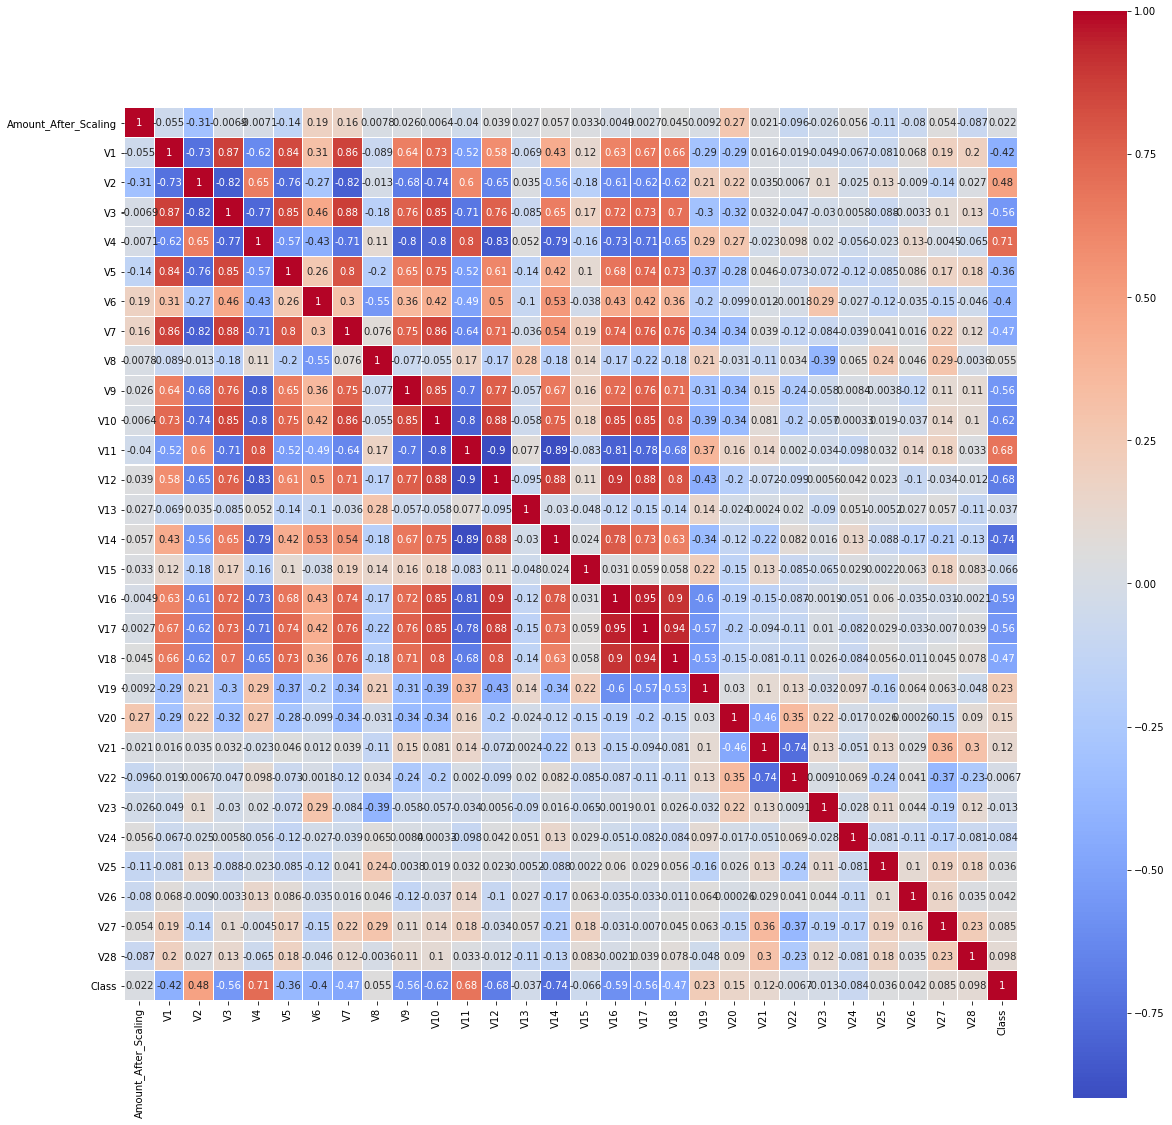

In [26]:
#pogledajmo sad korelacijsku matricu za undersampled_data
fig, ax = plt.subplots(1, 1, figsize=(20,20))
sns.heatmap(undersampled_data.corr(), ax=ax, linewidths=0.05,vmax=1.0, 
            square=True, cmap = plt.cm.coolwarm, linecolor='white', annot=True)
plt.show()

<p>Pogledajmo sada kako izgleda korelacijska matrica za skup podataka koji je dobiven undersamplom. Osvrnimo se prije svega na zadnji redak (ili stupac). Taj redak (stupac) nam govori kolika je koreliranost između varijabli koje koristimo za učenje te klase koja je pridjeljena nekoj transakciji. <br>
    Vidimo da postoji <b>pozitivna koreliranost</b> između klase te sljedećih značajki: 'V2, V4 i V11', a <b>negativna koreliranost</b> izmeđi klase te sljedećih značajki: 'V10, V12, V14' (ove su najistaknutije). </p>

<p>Sljedeći korak koji trebamo je podijeliti podatke u skup za treniranje te u skup za testiranje. To nam omogućuje metoda iz <i>sklearn</i> biblioteke zvana <em>train_test_split<em>.</p>

In [27]:
#cijeli dataset
X = data.drop('Class', axis=1)
y = data['Class']
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X,y,test_size=0.20,random_state=42)
y_data_test_non_fraud_num = y_data_test.value_counts()[0]
y_data_test_fraud_num = y_data_test.value_counts()[1]

#undersample
X_undersampled = undersampled_data.drop('Class', axis=1)
y_undersampled = undersampled_data['Class']
X_usample_train, X_usample_test, y_usample_train, y_usample_test = train_test_split(
    X_undersampled, y_undersampled, test_size=0.20, random_state=42)
y_usample_test_non_fraud_num = y_usample_test.value_counts()[0]
y_usample_test_fraud_num = y_usample_test.value_counts()[1]

#undersample 2 - koristimo NearMiss
from imblearn.under_sampling import NearMiss

#TREBA ODABRATI jednu od 3 verzije NearMissa

#adasyn = ADASYN(sampling_strategy='minority', n_neighbors=3)
# X_adasyn_train, y_adasyn_train = adasyn.fit_resample(X_data_train, y_data_train)
# y_adasyn_non_fraud_num = y_adasyn_train.value_counts()[0]
# y_adasyn_fraud_num = y_adasyn_train.value_counts()[1]

# print('Broj valjanih transakcija u trening skupu nakon ADASYN-a: ' + str(y_adasyn_non_fraud_num))
# print('Broj prevarantskih transakcija u trening skupu nakon ADASYN-a: ' + str(y_adasyn_fraud_num))
# print('Ukupan broj transakcija u trening skupu nakon ADASYN-a: ' + str(y_adasyn_fraud_num + y_adasyn_non_fraud_num))


print('-' * 100)
print('Broj transakcija korišten za treniranje (za cijeli skup podataka): ' + str(len(X_data_train)))
print('Broj transakcija korišten za testiranje (za cijeli skup podataka): ' + str(len(X_data_test)))
print('Ukupan broj transakcija (za cijeli skup podataka): ' + str(len(X_data_train)+len(X_data_test)))
print()
print('-' * 100)
print('-' * 100)
print('Broj transakcija korišten za treniranje (za undersamplirani skup podataka): ' + str(len(X_usample_train)))
print('Broj transakcija korišten za testiranje (za undersamplirani skup podataka): ' + str(len(X_usample_test)))
print('Ukupan broj transakcija (za undersamplirani skup podataka): ' + str(len(X_usample_train)+len(X_usample_test)))
print()
print('-' * 100)

----------------------------------------------------------------------------------------------------
Broj transakcija korišten za treniranje (za cijeli skup podataka): 227845
Broj transakcija korišten za testiranje (za cijeli skup podataka): 56962
Ukupan broj transakcija (za cijeli skup podataka): 284807

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Broj transakcija korišten za treniranje (za undersamplirani skup podataka): 787
Broj transakcija korišten za testiranje (za undersamplirani skup podataka): 197
Ukupan broj transakcija (za undersamplirani skup podataka): 984

----------------------------------------------------------------------------------------------------


In [28]:
#metoda 2 (undersample nad trening skupom dobivenih podataka)

#ZA NAPRAVITI 

<b>Problemi</b>: <ul>
    <li>za cijeli skup podataka: overfitting - imamo previše valjanih transakcija (spomenuli smo već nerazmjer klasa) tako da je vrlo vjerojatno da će naš algoritam proglasiti transakciju valjanom čak i ako je prevara</li>
    <li>za skup podataka nakon undersamplea: gubitak informacija - vidimo da koristimo samo 787 transakcija za učenje, što je znantno manje od 227 845 koje smo koristili u originalnom skupu podataka</li>
</ul>
<p><b>Napomena</b>: Moramo paziti kod podjele skupa podataka dobijenog undersampleom na trening skup i testni skup jer i dalje želimo testirati modele koje smo tako dobili i na cijelom skupu podataka.</p>

Za to možemo koristiti neku od dvije metode: <ol>
<li>podjelimo i undersamplirani i cijeli skup podataka na trening skup i testni skup te naučeno na <em>undersampliranom trening skupu</em> testiramo na <em>testnom skupu cijelog skupa podataka</em>.
</li>    
<li>
Prvo podijelimo cijeli skup na trening skup i testni skup, a onda izvršimo undersample samo na trening skupu.     
</li>
</ol>
Mi ćemo u ovoj bilježnici prikazati obje metode.

## Logistička regresija

Prvi od modela koje koristimo za učenje će biti logistička regresija. 

In [29]:
#logistička regresija
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#model za cijeli dataset
log_reg_data = LogisticRegression()
log_reg_data.fit(X_data_train, y_data_train)
training_score = cross_val_score(log_reg_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za logističku regresiju nad cijelim datasetom: " + 
      str(round(training_score.mean(), 4) * 100) + '%')

#undersampled
log_reg_usample = LogisticRegression()
log_reg_usample.fit(X_usample_train, y_usample_train)
training_score_usample = cross_val_score(log_reg_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za logističku regresiju nad undersampliranim datasetom: " + 
      str(round(training_score_usample.mean(), 4) * 100) + '%')




Rezultat treniranja za logističku regresiju nad cijelim datasetom: 99.92%
Rezultat treniranja za logističku regresiju nad undersampliranim datasetom: 93.14%


<p>Iz rezultata dobivenih na skupu za treniranje čini se kao da je model nad cijelim skupom podataka skoro pa savršen klasifikator, no kao što smo i ranije spomenuli overfitting može biti razlog za to. Što se tiče modela za undersamplirani model i dalje smo dobili prilično dobar rezultat. Napomenimo još da ćemo osim običnog klasifikatora za linearnu regresiju također koristiti i onaj gdje smo pažljivo izabrali parametre (za to koristimo GridSearchCV).</p>

In [30]:
#undersampled sa parametrima
from sklearn.model_selection import GridSearchCV
c_params = [0.01, 0.1, 1, 10, 100]
penalties = ['l1','l2']
log_reg_params = {"penalty": penalties, 'C': c_params}
grid_log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg.fit(X_usample_train, y_usample_train)
log_reg_params_usample = grid_log_reg.best_estimator_
params = grid_log_reg.best_params_
print('Najbolji parametri: ' + str(params))

training_score_params_usample = cross_val_score(log_reg_params_usample, X_usample_train, y_usample_train, cv=skfold)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(training_score_params_usample.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 100, 'penalty': 'l1'}
Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima): 92.88%


<p>Sada podešavamo parametre 'penalty' i 'C'. Vidimo da smo najbolje rezultate dobili da je za penalizaciju najbolja l1 regularizacija ili Lasso (defaultna vrijednost je l2 regularizacija ili Ridge), dok smo za parametar C dobili da je najbolja vrijednost 100 (defaultno je 1). </p>

Korisni termini: <ul>
    <li><em>True positives (TP)</em> - transakcije koje su prevare i naš model ih je ispravno svrstao (kao prevare) </li>
    <li><em>False positives (FP)</em> - transakcije koje su valjane, ali naš model ih je pogrešno svrstao (kao prevare) </li>
    <li><em>True negatives (TN)</em> - transakcije koje su valjane i naš model ih je ispravno svrstao (kao valjane) </li>
    <li><em>False negatives (FN)</em> - transakcije koje su prevare, ali naš model ih je pogrešno svrstao (kao valjane) </li>
    <br>
    <li><em>Precison (preciznost, oznaka P)</em> - omjer transakcija koje je model ispravno svrstao kao prevare i svih transakcija koje je svrstao kao prevare. Formulom: $\frac{TP}{TP + FP}$</li> 
    <li><em>Recall (osjetljivost, oznaka R)</em> - omjer transakcija koje je model ispravno svrstao kao prevare i svih transakcija koje su ustvari prevare. Formulom: $\frac{TP}{TP + FN}$</li> 
    <li><em>F1 score (F1 mjera)</em> - mjera koja povezuje preciznost i osjetljivost formulom: $\frac{2PR}{P + R}$</li>
    </ul>
    

In [31]:
def precision_recall_f1_scores(correct, predicted):
    print('\tPrecision score: ' + str(round(precision_score(correct, predicted), 4) * 100) + '%')
    print('\tRecall score: ' + str(round(recall_score(correct, predicted), 4) * 100) + '%')
    print('\tF1 score: ' + str(round(f1_score(correct, predicted), 4) * 100) + '%')

In [32]:

y_pred_data = log_reg_data.predict(X_data_test)
y_score_data = log_reg_data.decision_function(X_data_test)

print('-'*50)
print('Za cijeli dataset:')
precision_recall_f1_scores(y_data_test, y_pred_data)

y_pred_usample = log_reg_usample.predict(X_usample_test)
y_score_usample = log_reg_data.decision_function(X_usample_test)

print('-'*50)
print('Za undersamplirani dataset:')
precision_recall_f1_scores(y_usample_test, y_pred_usample)

#y_pred_usample_params = grid_log_reg.predict(X_usample_test)
#y_score_data_params = grid_log_reg.decision_function(X_usample_test)
y_pred_usample_params = log_reg_params_usample.predict(X_usample_test)
y_score_usample_params = log_reg_params_usample.decision_function(X_usample_test)

print('-'*50)
print('Za undersamplirani dataset (sa podešenim parametrima):')
precision_recall_f1_scores(y_usample_test, y_pred_usample_params)

print('-'*50)

--------------------------------------------------
Za cijeli dataset:
	Precision score: 86.36%
	Recall score: 58.160000000000004%
	F1 score: 69.51%
--------------------------------------------------
Za undersamplirani dataset:
	Precision score: 96.88%
	Recall score: 93.94%
	F1 score: 95.38%
--------------------------------------------------
Za undersamplirani dataset (sa podešenim parametrima):
	Precision score: 96.91%
	Recall score: 94.95%
	F1 score: 95.92%
--------------------------------------------------


<p>Iz dobivenih rezultata vidimo da je testiranje puno uspješnije za undersamplirane skupove. Problem je što nismo testirali na cjelokupnom skupu podataka već samo na malom komadu. Sada trebamo iskoristiti informacije koje je model naučio na undersampliranom skupu podataka i pomoću njih predviditi vrijednosti na cijelom skupu podataka. </p>

In [33]:
y_pred_usample_full = log_reg_usample.predict(X_data_test)
y_score_usample_full = log_reg_data.decision_function(X_data_test)

y_pred_usample_params_full = log_reg_params_usample.predict(X_data_test)
y_score_usample_params_full = log_reg_params_usample.decision_function(X_data_test)

print('-'*50)
print('Za undersamplirani dataset:')
precision_recall_f1_scores(y_data_test, y_pred_usample_full)

print('-'*50)
print('Za undersamplirani dataset (sa podešenim parametrima):')
precision_recall_f1_scores(y_data_test, y_pred_usample_params_full)

--------------------------------------------------
Za undersamplirani dataset:
	Precision score: 5.63%
	Recall score: 92.86%
	F1 score: 10.620000000000001%
--------------------------------------------------
Za undersamplirani dataset (sa podešenim parametrima):
	Precision score: 4.58%
	Recall score: 92.86%
	F1 score: 8.72%


<p>Iz dobivenih rezultata vidimo da su preciznost i f1 jako niski, ali je zato recall prilično visok. Razlog tome je što smo imali mali skup za treniranje u kojem je omjer valjanih transakcija i prevara bio 1:1, dok smo testirali na daleko većem skupu u kojem je puno više valjanih transakcija nego prevara. Dalje ćemo i pomoću drugih metoda prikazati rezultate testiranja te prokomentirati možemo li biti zadovoljni dobivenim. Počet ćemo sa konfuzijskom matricom.</p>

In [34]:

def plot_confusion_matrix(conf_mat, y_test_non_fraud, y_test_fraud):
    fig, ax = plt.subplots(1,2,figsize=(15,6))
    labels = ['Valjana', 'Prevara']
    ax[0].set_title('Konfuzijska matrica')
    sns.heatmap(conf_mat, ax=ax[0], linewidths=0.5, annot=True,
            square=True, cmap = plt.cm.coolwarm, linecolor='white',
               xticklabels=labels, yticklabels=labels)
    
    
    ax[1].set_title('Normalizirana konfuzijska matrica')
    norm_coef = np.array([[1/y_test_non_fraud, 1/y_test_non_fraud],
                         [1/y_test_fraud, 1/y_test_fraud]])
    normalized_cm = conf_mat * norm_coef 
    sns.heatmap(normalized_cm, ax=ax[1], linewidths=0.5, annot=True,
            square=True, cmap = plt.cm.coolwarm, linecolor='white',
               xticklabels=labels, yticklabels=labels)
    
    plt.show()

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962


Konfuzijska matrica za cijeli dataset


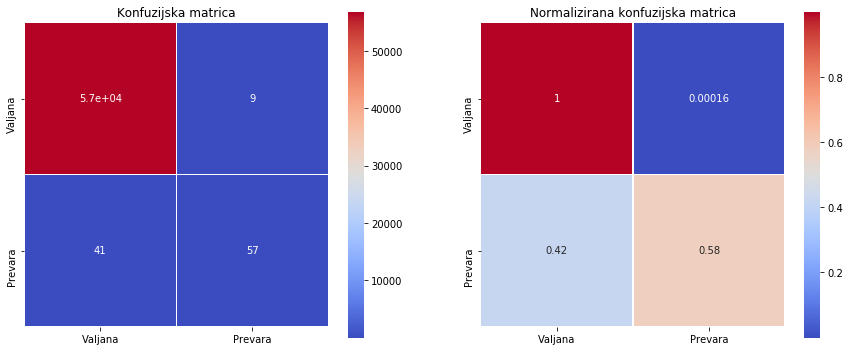

In [35]:

print('-'*50)
print(classification_report(y_data_test, y_pred_data))
print()
print('Konfuzijska matrica za cijeli dataset')
plot_confusion_matrix(confusion_matrix(y_data_test, y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)

<p>Crtamo dvije konfuzijske matrice pri ćemu je lijeva sa apsolutnim vrijednostima, a desna sa normaliziranim. Kod ove matrice konfuzije možemo primjetiti probleme prouzrokovane disbalansom klasa. Odnosno, ako pogledamo gornje lijevu ćeliju vidimo da je naš model točno klasificirao čak 57 000 valjanih transakcija što je prilično dobro. Gornja desna ćelija nam kaže da je samo 9 transakcija, koje su ustvari valjane, naš model predvidio da su prevare (što je također dosta dobro). Problem je u donje dvije ćelije. Od ukupno 98 prevara naš model je uhvatio samo njih 57 (i još onih 9 koje su ustvari bile valjane), dok je čak 41 prevaru naš model svrstao u valjane transakcije. Bolje rečeno, od 98 ljudi koji počine kartičnu prevaru, njih 41 neće biti uhvaćeno, a to je jako puno nekažnjenog kriminala.</p>

--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        98
           1       0.97      0.94      0.95        99

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197


Konfuzijska matrica za undersamplirani dataset


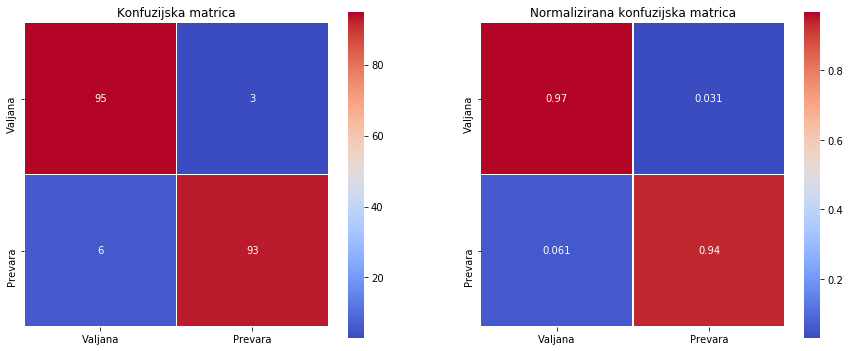

--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        98
           1       0.97      0.95      0.96        99

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197


Konfuzijska matrica za undersamplirani dataset (sa podešenim parametrima regresije)


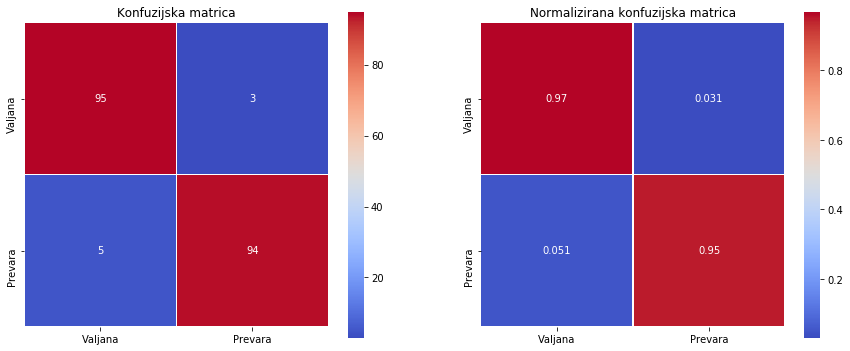

In [36]:
print('-'*50)
print(classification_report(y_usample_test, y_pred_usample))
print()
print('Konfuzijska matrica za undersamplirani dataset')
plot_confusion_matrix(confusion_matrix(y_usample_test, y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)

print('-'*50)
print(classification_report(y_usample_test, y_pred_usample_params))
print()
print('Konfuzijska matrica za undersamplirani dataset (sa podešenim parametrima regresije)')
plot_confusion_matrix(confusion_matrix(y_usample_test, y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)

<p>Iznad vidimo konfuzijske matrice za modele koji su predviđali samo na undersampliranom testnom skupu podataka. Iz toga nemamo neke korisne informacije budući da moramo provjeriti kako izgleda za cijeli skup podataka.</p>

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.93      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.98     56962


Konfuzijska matrica za testiranje na cijelom datasetu


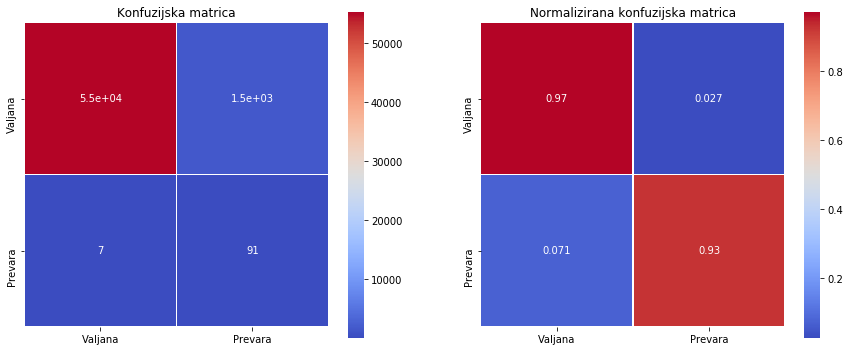

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.93      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962


Konfuzijska matrica za testiranje na cijelom datasetu (sa podešenim parametrima regresije)


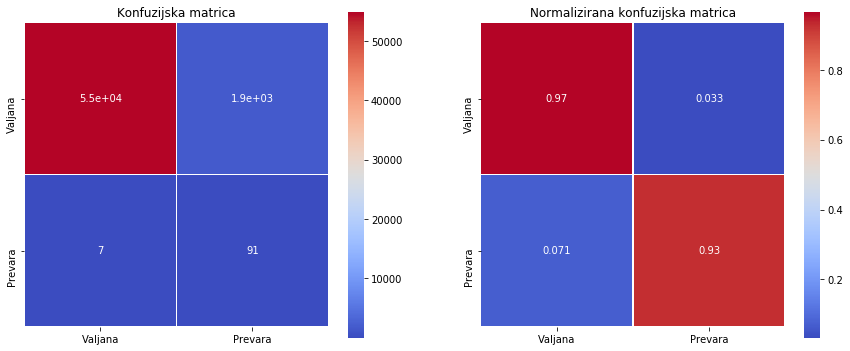

In [37]:
print('-'*50)
print(classification_report(y_data_test, y_pred_usample_full))
print()
print('Konfuzijska matrica za testiranje na cijelom datasetu')
plot_confusion_matrix(confusion_matrix(y_data_test, y_pred_usample_full), y_data_test_non_fraud_num, y_data_test_fraud_num)

print('-'*50)
print(classification_report(y_data_test, y_pred_usample_params_full))
print()
print('Konfuzijska matrica za testiranje na cijelom datasetu (sa podešenim parametrima regresije)')
plot_confusion_matrix(confusion_matrix(y_data_test, y_pred_usample_params_full), y_data_test_non_fraud_num, y_data_test_fraud_num)

<p>Na konfuzijskim matricama iznad već vidimo znantne razike u odnosu na prethodnu. Uočavamo sljedeće razlike kod tih matrica. Prvo, kada nismo birali parametre dobili smo model koji bolje prepoznaje valjane transakcije. Vidimo da je u gornjoj matrici 1700 valjanih transakcija koje je model predvidio kao prevare, dok je na donjoj matrici čak 2000 valjanih koje je taj drugi model predvidio kao prevare (to vidimo gledajući gornju desnu ćeliju matrica). S druge strane, model kojem su podešeni parametri ispravno je klasificirao 90 prevara, dok je bez podešavanja parametara ispravno klasificirao 89. Dakle, svaki od modela ima svoju prednost, no napomenimo da je razlika za pogrešno klasificirane valjane transakcije 300 (od 57 000), dok je razlika za pogrešno klasificirane prevare 1 (od 98).</p>

In [38]:
#sada koristimo undersamplirani dataset za predikcije na cijelom datasetu
#za undersamplirani ćemo koristiti dataset u kojem smo pomocu gridsearcha trazili najbolje parametre
# new_log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
# new_log_reg.fit(X_usample_train, y_usample_train)
# new_log_reg_params_usample = new_log_reg.best_estimator_
# full_pred = new_log_reg_params_usample.predict(X_data_test)
# full_pred_score = log_reg_data.decision_function(X_data_test)

# print('-'*50)
# print('Predikcija za cijeli dataset:')
# precision_recall_f1_scores(y_data_test, full_pred)
# print()
# print('-'*50)
# print(classification_report(y_data_test, full_pred))
# print()
# plot_confusion_matrix(confusion_matrix(y_data_test, full_pred), y_data_test_non_fraud_num, y_data_test_fraud_num)

<p>Krivulje nacrtane iznad se zove ROC krivulja i PR krivulja. ROC krivulja predstavlja omjer između broja transakcija koje su prevare i naš model ih je ispravno klasificirao (true positive rate) te transakcija koje je naš model svrstao među prevare, ali su ustvari valjane. S druge strane PR krivulja predstavlja omjer između dviju metrika (preciznosti i osjetljivosti). </p>

In [39]:
def plot_roc_auc_curve(correct, predicted):
    fpr, tpr, threshold = roc_curve(correct, predicted)
    area_under_curve = auc(fpr,tpr)
    plt.plot([0, 1], [0, 1], "k--")
    plt.plot(fpr, tpr, label="AUC = " + str(round(area_under_curve,3)))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()

In [40]:
def plot_precision_recall_curve(correct, predicted):
    precision, recall, threshold = precision_recall_curve(correct, predicted)
    aupr = auc(recall, precision)
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2, label="AUC = " + str(round(aupr,3)))
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.show(); 
    

ROC za cijeli dataset


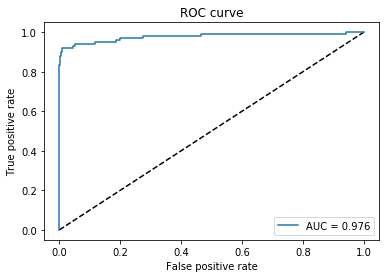

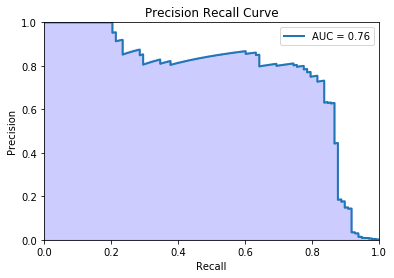

In [41]:
print('ROC za cijeli dataset')
plot_roc_auc_curve(y_data_test, y_score_data)
plot_precision_recall_curve(y_data_test, y_score_data)

ROC + PR za undersamplirani dataset


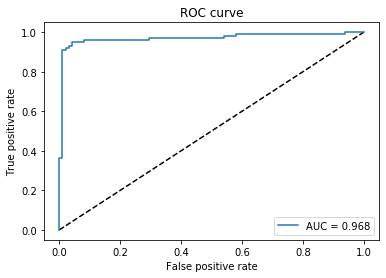

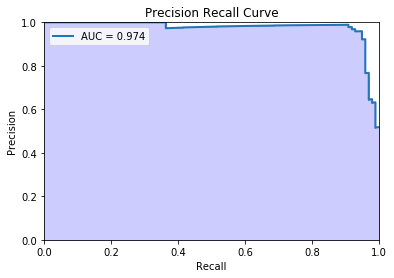

ROC + PR za undersamplirani dataset (sa parametrima)


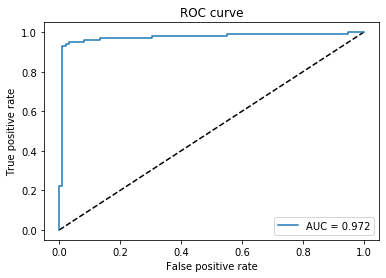

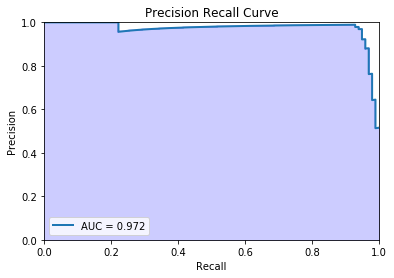

In [42]:
print('ROC + PR za undersamplirani dataset')
plot_roc_auc_curve(y_usample_test, y_score_usample)
plot_precision_recall_curve(y_usample_test, y_score_usample)

print('ROC + PR za undersamplirani dataset (sa parametrima)')
plot_roc_auc_curve(y_usample_test, y_score_usample_params)
plot_precision_recall_curve(y_usample_test, y_score_usample_params)

ROC + PR za testiranje na cijelom datasetu


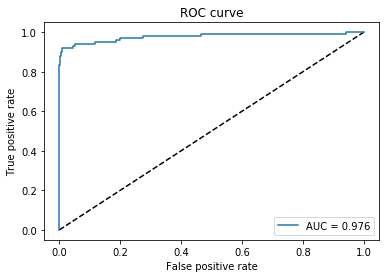

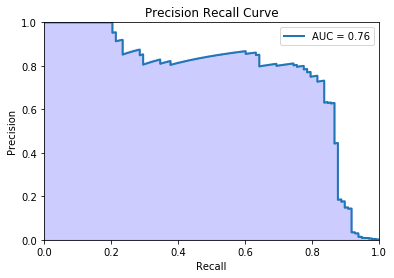

ROC + PR za testiranje na cijelom datasetu (sa parametrima)


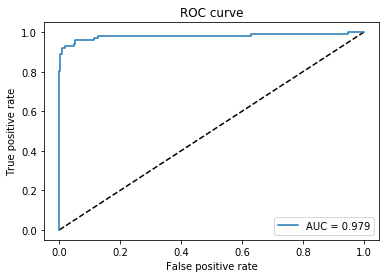

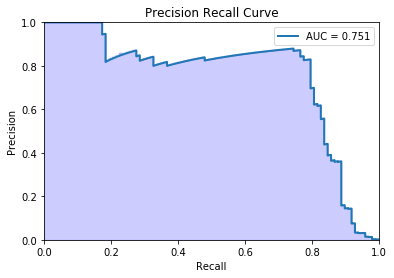

In [43]:
print('ROC + PR za testiranje na cijelom datasetu')
plot_roc_auc_curve(y_data_test, y_score_usample_full)
plot_precision_recall_curve(y_data_test, y_score_usample_full)

print('ROC + PR za testiranje na cijelom datasetu (sa parametrima)')
plot_roc_auc_curve(y_data_test, y_score_usample_params_full)
plot_precision_recall_curve(y_data_test, y_score_usample_params_full)

In [44]:
# print('ROC + PR za sve')
# plot_roc_auc_curve(y_data_test, full_pred_score)
# plot_precision_recall_curve(y_data_test, full_pred_score)

<p>Sljedeće ćemo pronaći ekstremne outliere i izbrisati ih. Time se nadamo da ćemo maknuti pristranost koju ti outlieri nose. Zato trebamo naći koje značajke najviše pridonose klasi koja će biti pridjeljena nekoj transakciji, odnosno trebamo naći koje varijable kod kojih je najveća pozitivna ili negativna korelacija.</p>

In [45]:
#bez outliera
#prvo sjetimo se koje znacajke imaju najvecu negativnu korelaciju
print('Negativne korelacije: ' + str(np.where(undersampled_data.corr()['Class'] < -0.6))) 
print('Pozitivne korelacije: ' + str(np.where(undersampled_data.corr()['Class'] > 0.6)))

Negativne korelacije: (array([10, 12, 14], dtype=int64),)
Pozitivne korelacije: (array([ 4, 11, 29], dtype=int64),)


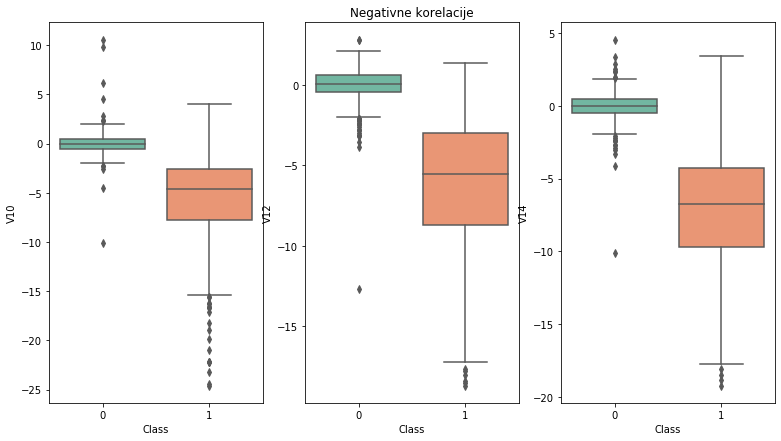

In [46]:
fig_pos, ax_pos = plt.subplots(1, 3, figsize=(13,7))
ax_pos[1].set_title('Negativne korelacije')
sns.boxplot(x='Class', y='V10', data=undersampled_data, ax=ax_pos[0], palette='Set2')
sns.boxplot(x='Class', y='V12', data=undersampled_data, ax=ax_pos[1], palette='Set2')
sns.boxplot(x='Class', y='V14', data=undersampled_data, ax=ax_pos[2], palette='Set2')
plt.show()

<p>Iz boxplotova negativnih korelacija vidimo kolika je razlika među vrijednostima koje odijeljuju valjane transakcije i prevare. Također, možemo primjetiti dosta outliera (posebno na prvomm grafu). Sada ćemo isto napraviti i za pozitivnu korelaciju (primjetimo da je uzimamo značajke V4 i V11, jer 29 u polju označava značajku Class koja je sigurno korelirana sama sa sobom). </p>

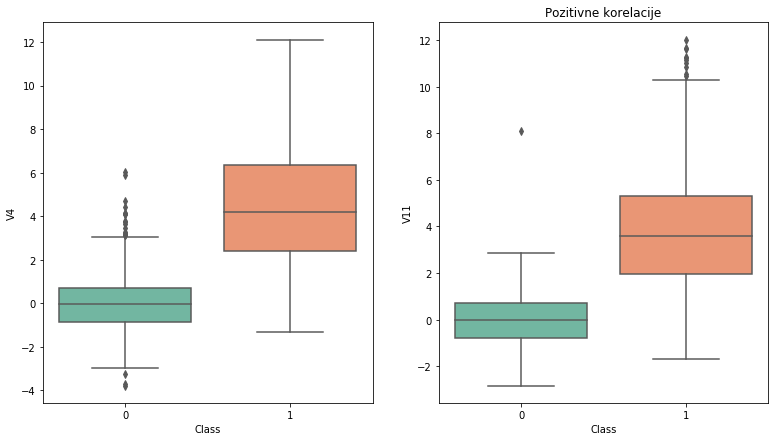

In [47]:
fig_neg, ax_neg = plt.subplots(1, 2, figsize=(13,7))
ax_neg[1].set_title('Pozitivne korelacije')
sns.boxplot(x='Class', y='V4', data=undersampled_data, ax=ax_neg[0], palette='Set2')
sns.boxplot(x='Class', y='V11', data=undersampled_data, ax=ax_neg[1], palette='Set2')
plt.show()

In [48]:
#uklanjanje outliera (za negativnu korelaciju)
v10_q1 = undersampled_data['V10'].quantile(0.25)
v10_q3 = undersampled_data['V10'].quantile(0.75)
v10_q2 = v10_q3 - v10_q1
v10_cut_off = v10_q2 * 2.0
v10_lower, v10_upper = v10_q1 - v10_cut_off, v10_q3 + v10_cut_off
v10_outliers = [out for out in undersampled_data['V10'] if out < v10_lower or out > v10_upper]
print('-' * 50)
print('Broj identificiranih outliera nad V10: ' + str(len(v10_outliers)))
# undersampled_data_cut = undersampled_data.drop(undersampled_data[undersampled_data['V10'] < v10_lower].index)
# undersampled_data_cut = undersampled_data_cut.drop(undersampled_data_cut[undersampled_data_cut['V10'] > v10_upper].index)

v12_q1 = undersampled_data['V12'].quantile(0.25)
v12_q3 = undersampled_data['V12'].quantile(0.75)
v12_q2 = v12_q3 - v12_q1
v12_cut_off = v12_q2 * 2.0
v12_lower, v12_upper = v12_q1 - v12_cut_off, v12_q3 + v12_cut_off
v12_outliers = [out for out in undersampled_data['V12'] if out < v12_lower or out > v12_upper]
print('Broj identificiranih outliera nad V12: ' + str(len(v12_outliers)))
# undersampled_data_cut = undersampled_data_cut.drop(undersampled_data_cut[undersampled_data_cut['V12'] > v12_upper].index)
# undersampled_data_cut = undersampled_data_cut.drop(undersampled_data_cut[undersampled_data_cut['V12'] < v12_lower].index)

v14_q1 = undersampled_data['V14'].quantile(0.25)
v14_q3 = undersampled_data['V14'].quantile(0.75)
v14_q2 = v14_q3 - v14_q1
v14_cut_off = v14_q2 * 2.0
v14_lower, v14_upper = v14_q1 - v14_cut_off, v14_q3 + v14_cut_off
v14_outliers = [out for out in undersampled_data['V14'] if out < v14_lower or out > v14_upper]
print('Broj identificiranih outliera nad V14: ' + str(len(v14_outliers)))
# undersampled_data_cut = undersampled_data_cut.drop(undersampled_data_cut[undersampled_data_cut['V14'] > v14_upper].index)
# undersampled_data_cut = undersampled_data_cut.drop(undersampled_data_cut[undersampled_data_cut['V14'] < v14_lower].index)
print('-' * 50)

--------------------------------------------------
Broj identificiranih outliera nad V10: 35
Broj identificiranih outliera nad V12: 13
Broj identificiranih outliera nad V14: 0
--------------------------------------------------


In [49]:
#uklanjanje outliera (za pozitivne korelaciju)
v4_q1 = undersampled_data['V4'].quantile(0.25)
v4_q3 = undersampled_data['V4'].quantile(0.75)
v4_q2 = v4_q3 - v4_q1
v4_cut_off = v4_q2 * 2.0
v4_lower, v4_upper = v4_q1 - v4_cut_off, v4_q3 + v4_cut_off
v4_outliers = [out for out in undersampled_data['V4'] if out < v4_lower or out > v4_upper]
print('-' * 50)
print('Broj identificiranih outliera nad V4: ' + str(len(v4_outliers)))
# undersampled_data_cut = undersampled_data_cut.drop(undersampled_data_cut[undersampled_data_cut['V4'] > v4_upper].index)
# undersampled_data_cut = undersampled_data_cut.drop(undersampled_data_cut[undersampled_data_cut['V4'] < v4_lower].index)

v11_q1 = undersampled_data['V11'].quantile(0.25)
v11_q3 = undersampled_data['V11'].quantile(0.75)
v11_q2 = v11_q3 - v11_q1
v11_cut_off = v11_q2 * 2.0
v11_lower, v11_upper = v11_q1 - v11_cut_off, v11_q3 + v11_cut_off
v11_outliers = [out for out in undersampled_data['V11'] if out < v11_lower or out > v11_upper]
print('Broj identificiranih outliera nad V11: ' + str(len(v11_outliers)))
# undersampled_data_cut = undersampled_data_cut.drop(undersampled_data_cut[undersampled_data_cut['V11'] > v11_upper].index)
# undersampled_data_cut = undersampled_data_cut.drop(undersampled_data_cut[undersampled_data_cut['V11'] < v11_lower].index)
print('-' * 50)

--------------------------------------------------
Broj identificiranih outliera nad V4: 0
Broj identificiranih outliera nad V11: 5
--------------------------------------------------


<p>Vidimo da je broj outliera poprilično velik čak i kad govorimo samo o undersampliranom skupu podataka. Sada moramo izbaciti te podatke iz skupa.</p>

In [50]:
undersampled_data_cut = undersampled_data.drop(
    undersampled_data[
        (undersampled_data['V10'] > v10_upper) | 
        (undersampled_data['V10'] < v10_lower) |
        (undersampled_data['V12'] > v12_upper) | 
        (undersampled_data['V12'] < v12_lower) |
        (undersampled_data['V14'] > v14_upper) | 
        (undersampled_data['V14'] < v14_lower) |
        (undersampled_data['V4'] > v4_upper) | 
        (undersampled_data['V4'] < v4_lower) |
        (undersampled_data['V11'] > v11_upper) | 
        (undersampled_data['V11'] < v11_lower) 
                     ].index)

In [51]:
len(undersampled_data_cut)

935

In [52]:
X_undersampled_cut = undersampled_data_cut.drop('Class', axis=1)
y_undersampled_cut = undersampled_data_cut['Class']
X_usample_cut_train, X_usample_cut_test, y_usample_cut_train, y_usample_cut_test = train_test_split(
    X_undersampled_cut, y_undersampled_cut, test_size=0.20, random_state=42)

print('Broj transakcija korišten za treniranje (za undersamplirani dataset bez outliera): ' + str(len(X_usample_cut_train)))
print('Broj transakcija korišten za testiranje (za undersamplirani dataset bez outliera): ' + str(len(X_usample_cut_test)))
print('Ukupan broj transakcija (za undersamplirani dataset bez outliera): ' + str(len(X_usample_cut_train)+len(X_usample_cut_test)))

Broj transakcija korišten za treniranje (za undersamplirani dataset bez outliera): 748
Broj transakcija korišten za testiranje (za undersamplirani dataset bez outliera): 187
Ukupan broj transakcija (za undersamplirani dataset bez outliera): 935


In [53]:
y_usample_cut_test_non_fraud_num = y_usample_cut_test.value_counts()[0]
y_usample_cut_test_fraud_num = y_usample_cut_test.value_counts()[1]

<p>U ovom slučaju (kada smo maknuli outliere) ćemo za učenje odmah upotrijebiti verziju u kojoj biramo najbolje parametre. </p>

In [54]:
grid_log_reg_cut = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
grid_log_reg_cut.fit(X_usample_cut_train, y_usample_cut_train)
log_reg_params_usample_cut = grid_log_reg_cut.best_estimator_
params_cut = grid_log_reg_cut.best_params_
print('Najbolji parametri: ' + str(params_cut))

training_score_params_usample_cut = cross_val_score(log_reg_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print('Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima, bez outliera): ' 
     + str(round(training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 0.1, 'penalty': 'l1'}
Rezultat treniranja za logističku regresiju nad undersampliranim datasetom (sa parametrima, bez outliera): 93.97999999999999%


--------------------------------------------------
Za undersamplirani dataset (sa podešenim parametrima, bez outliera):
	Precision score: 96.3%
	Recall score: 87.64%
	F1 score: 91.75999999999999%
----------------------------------------------------------------------------------------------------


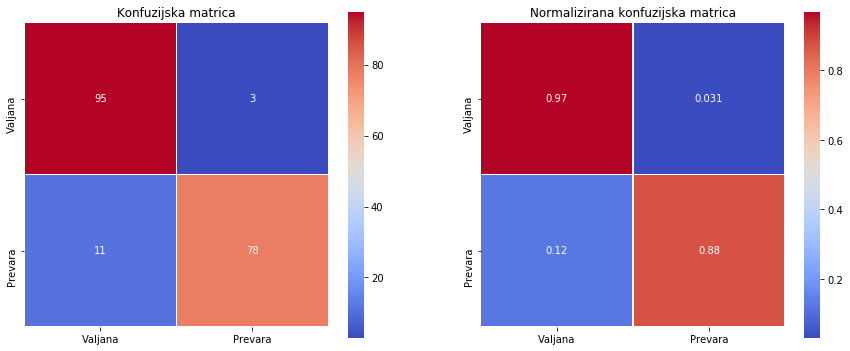

ROC + PR za undersamplirani dataset (sa parametrima, bez outliera)


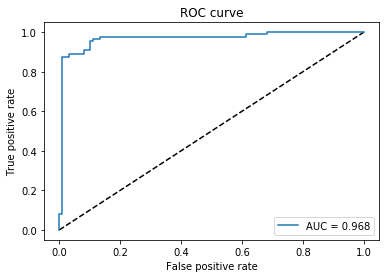

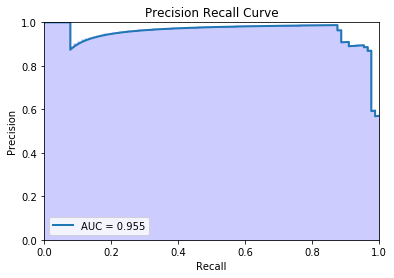

In [55]:
y_pred_usample_params_cut = log_reg_params_usample_cut.predict(X_usample_cut_test)
y_score_usample_params_cut = log_reg_params_usample.decision_function(X_usample_cut_test)

print('-'*50)
print('Za undersamplirani dataset (sa podešenim parametrima, bez outliera):')
precision_recall_f1_scores(y_usample_cut_test, y_pred_usample_params_cut)
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)

print('ROC + PR za undersamplirani dataset (sa parametrima, bez outliera)')
plot_roc_auc_curve(y_usample_cut_test, y_score_usample_params_cut)
plot_precision_recall_curve(y_usample_cut_test, y_score_usample_params_cut)


--------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.67%
	Recall score: 92.86%
	F1 score: 12.45%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962


--------------------------------------------------


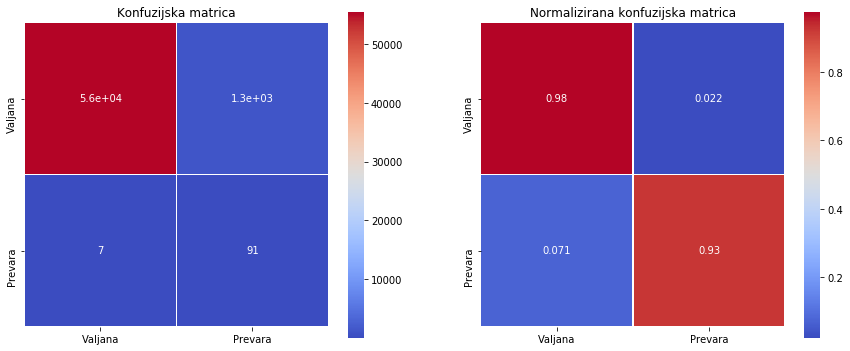

----------------------------------------------------------------------------------------------------


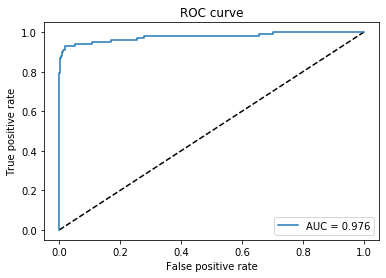

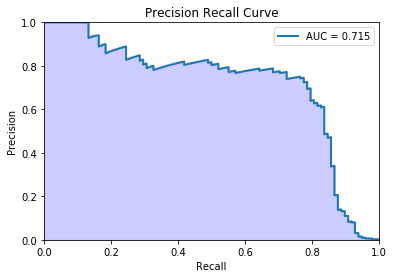

In [56]:
full_pred_cut = log_reg_params_usample_cut.predict(X_data_test)
full_pred_score_cut = log_reg_params_usample_cut.decision_function(X_data_test)

print('-'*50)
print('Predikcija za cijeli dataset:')
precision_recall_f1_scores(y_data_test, full_pred_cut)
print()
print('-'*50)
print(classification_report(y_data_test, full_pred_cut))
print()
print('-'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)
plot_roc_auc_curve(y_data_test, full_pred_score_cut)
plot_precision_recall_curve(y_data_test, full_pred_score_cut)

<p>Izgleda da je površina ispod PR krivulje nešto lošija nego prije, no pogledajmo ostale podatke. I preciznost i f1-mjera se čine dosta boljima nego prije. Ako pogledamo matricu konfuzije vidimo da je od 98 prevara sad čak 91 ispravno klasificirana kao prevara (prije smo imali 89, odnosno 90), ali uz to smo još smanjili i broj krivo klasificiranih prevara, odnosno transakcija koje je model klasificirao kao prevare, ali su ustvari valjane transakcije.</p>

In [57]:
# new_log_reg_cut = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
# new_log_reg_cut.fit(X_usample_cut_train, y_usample_cut_train)
# new_log_reg_params_usample_cut = new_log_reg_cut.best_estimator_
# full_pred_cut = new_log_reg_params_usample_cut.predict(X_data_test)
# full_pred_score_cut = new_log_reg_params.decision_function(X_data_test)

# print('Najbolji parametri: ' + str(new_log_reg_cut.best_params_))
# print('-'*50)
# print('Predikcija za cijeli dataset:')
# precision_recall_f1_scores(y_data_test, full_pred_cut)
# print()
# print('-'*50)
# print(classification_report(y_data_test, full_pred_cut))
# print()
# print('-'*50)
# plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
# print('-'*100)
# plot_roc_auc_curve(y_data_test, full_pred_score_cut)
# plot_precision_recall_curve(y_data_test, full_pred_score_cut)

<p>Za kraj učenjem logističke regresije nad undersampliranim skupom podataka ćemo još pokušati promijeniti thresholdove da vidimo bi li to poboljšalo naš model. Za parametre ćemo uzeti one koji su dobiveni kod posljednjeg GridSearchCV-a (jer treniramo na istim podacima).</p>

--------------------------------------------------
Predikcija za cijeli dataset sa thresholdom: 0.1
	Precision score: 0.42%
	Recall score: 97.96000000000001%
	F1 score: 0.84%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.60      0.75     56864
           1       0.00      0.98      0.01        98

    accuracy                           0.60     56962
   macro avg       0.50      0.79      0.38     56962
weighted avg       1.00      0.60      0.75     56962




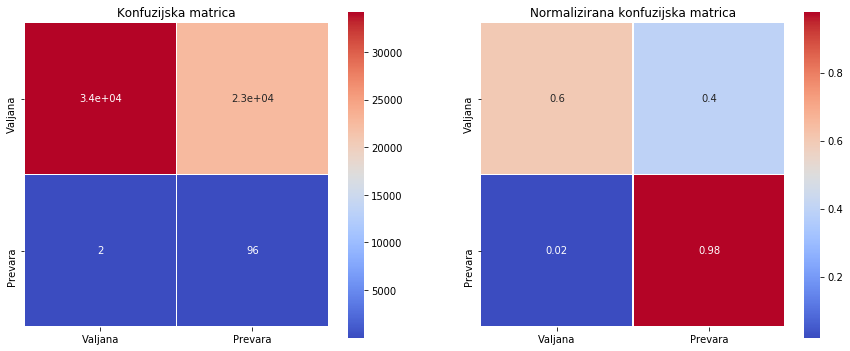

****************************************************************************************************
--------------------------------------------------
Predikcija za cijeli dataset sa thresholdom: 0.25
	Precision score: 1.63%
	Recall score: 93.88%
	F1 score: 3.2099999999999995%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56864
           1       0.02      0.94      0.03        98

    accuracy                           0.90     56962
   macro avg       0.51      0.92      0.49     56962
weighted avg       1.00      0.90      0.95     56962




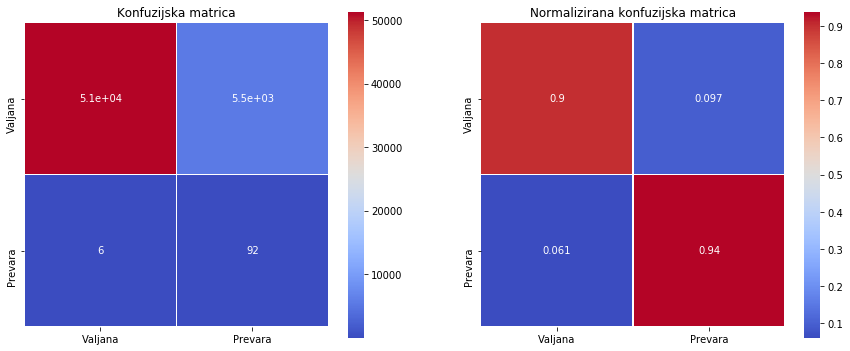

****************************************************************************************************
--------------------------------------------------
Predikcija za cijeli dataset sa thresholdom: 0.5
	Precision score: 6.710000000000001%
	Recall score: 92.86%
	F1 score: 12.509999999999998%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962




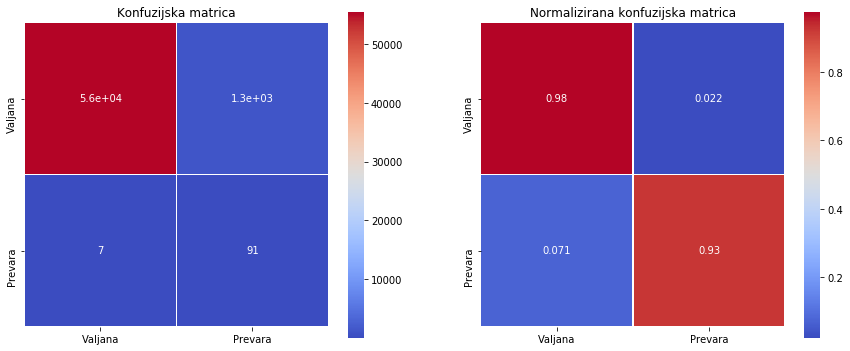

****************************************************************************************************
--------------------------------------------------
Predikcija za cijeli dataset sa thresholdom: 0.75
	Precision score: 18.78%
	Recall score: 87.76%
	F1 score: 30.94%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.19      0.88      0.31        98

    accuracy                           0.99     56962
   macro avg       0.59      0.94      0.65     56962
weighted avg       1.00      0.99      1.00     56962




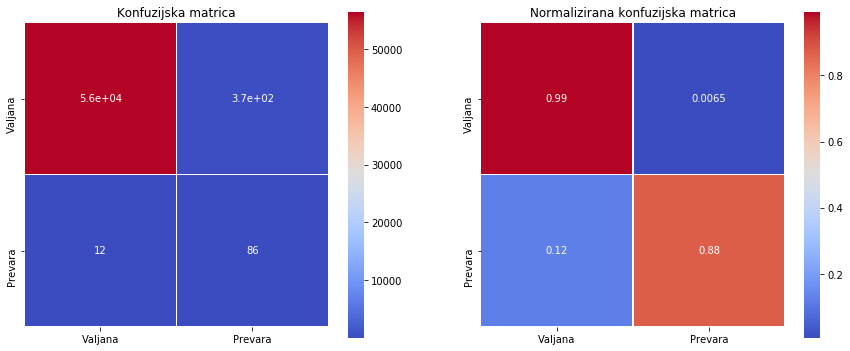

****************************************************************************************************
--------------------------------------------------
Predikcija za cijeli dataset sa thresholdom: 0.9
	Precision score: 49.4%
	Recall score: 83.67%
	F1 score: 62.12%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.49      0.84      0.62        98

    accuracy                           1.00     56962
   macro avg       0.75      0.92      0.81     56962
weighted avg       1.00      1.00      1.00     56962




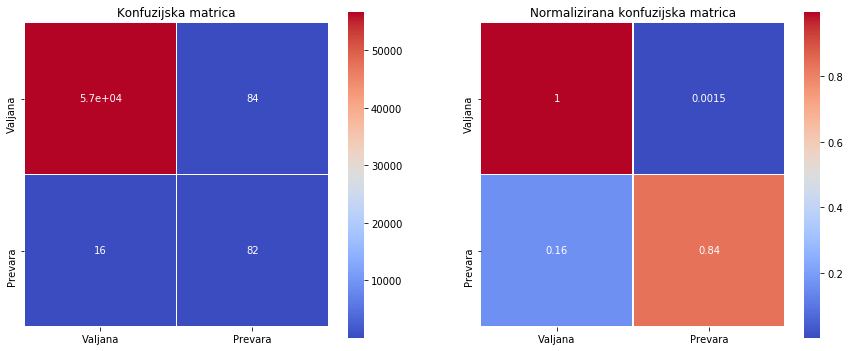

****************************************************************************************************


In [58]:
#idemo jos primjeniti za različite tresholdove pomoću predict_proba
#log_reg_thresh = LogisticRegression(C=new_log_reg_cut.best_params_['C'], penalty=new_log_reg_cut.best_params_['penalty'], solver='liblinear')
log_reg_thresh = LogisticRegression(C=params_cut['C'], penalty=params_cut['penalty'], solver='liblinear')
log_reg_thresh.fit(X_usample_cut_train, y_usample_cut_train)
full_pred_thresh = log_reg_thresh.predict_proba(X_data_test)

thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
for threshold in thresholds:
    full_pred_t = full_pred_thresh[:, 1] > threshold
    print('-'*50)
    print('Predikcija za cijeli dataset sa thresholdom: ' + str(threshold))
    precision_recall_f1_scores(y_data_test, full_pred_t)
    print()
    print('-'*50)
    print(classification_report(y_data_test, full_pred_t))
    print()
    plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_t), y_data_test_non_fraud_num, y_data_test_fraud_num)
    print('*'*100)

<p>Vidimo da za threshold 0.5 dobivamo iste rezultate kao i prije nego što smo podešavali. Također vidimo da što je manji threshold to dobivamo bolje rezultate za ispravno klasificirane prevare, no također model svrsta i više valjanih transakcija među prevare. Kako povećavamo threshold tako i propuštamo ispravno klasificirati sve više prevara. Tako možemo mijenjati threholdove dok ne dobijemo željene rezultate (pod željenim mislimo na željeni razmjer uhvaćenih prevara i pogrešno klasificiranih prevara. Također, klasama možemo pridijeliti težine. Što je veća težina neke klase to ima veći utjecaj na klasifikaciju.</p>

****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 1 puta veća od klase 0 (valjane).
	Precision score: 6.69%
	Recall score: 92.86%
	F1 score: 12.479999999999999%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.93      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962




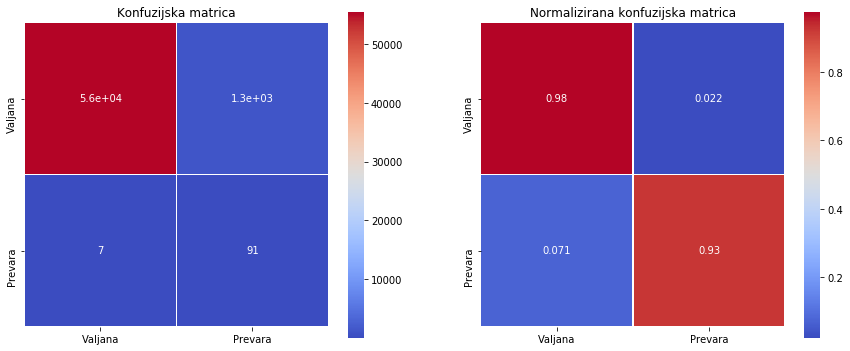

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 5 puta veća od klase 0 (valjane).
	Precision score: 1.28%
	Recall score: 94.89999999999999%
	F1 score: 2.53%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     56864
           1       0.01      0.95      0.03        98

    accuracy                           0.87     56962
   macro avg       0.51      0.91      0.48     56962
weighted avg       1.00      0.87      0.93     56962




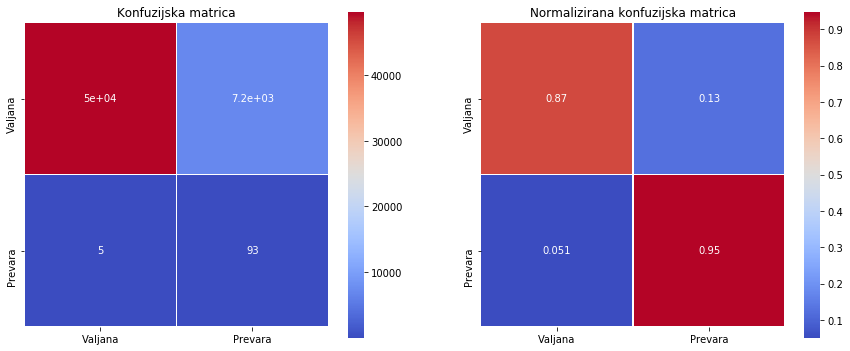

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 10 puta veća od klase 0 (valjane).
	Precision score: 0.69%
	Recall score: 95.92%
	F1 score: 1.38%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.76      0.87     56864
           1       0.01      0.96      0.01        98

    accuracy                           0.76     56962
   macro avg       0.50      0.86      0.44     56962
weighted avg       1.00      0.76      0.86     56962




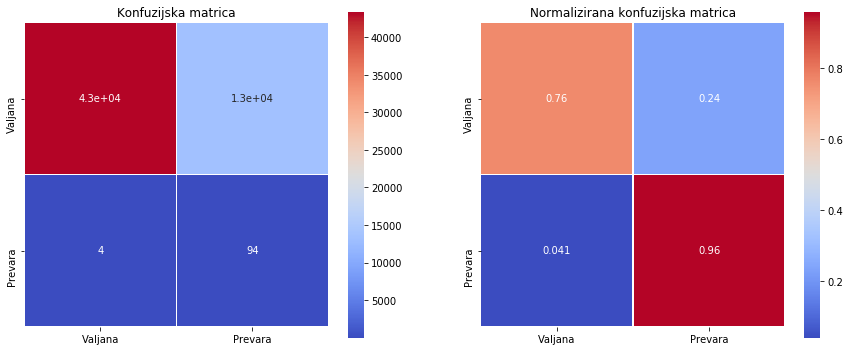

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 50 puta veća od klase 0 (valjane).
	Precision score: 0.33999999999999997%
	Recall score: 98.98%
	F1 score: 0.69%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.51      0.67     56864
           1       0.00      0.99      0.01        98

    accuracy                           0.51     56962
   macro avg       0.50      0.75      0.34     56962
weighted avg       1.00      0.51      0.67     56962




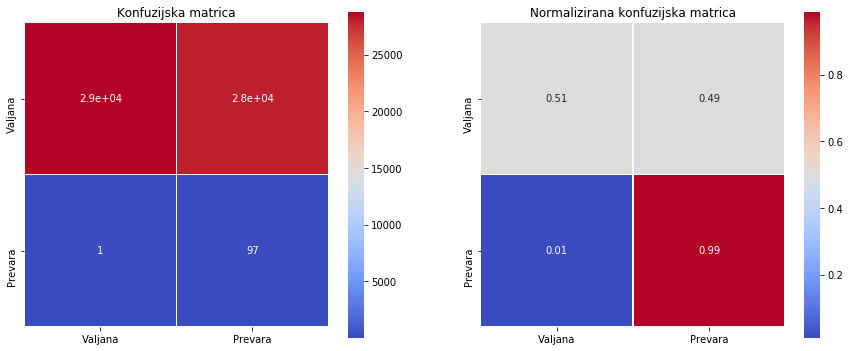

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 100 puta veća od klase 0 (valjane).
	Precision score: 0.31%
	Recall score: 100.0%
	F1 score: 0.61%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.44      0.61     56864
           1       0.00      1.00      0.01        98

    accuracy                           0.44     56962
   macro avg       0.50      0.72      0.31     56962
weighted avg       1.00      0.44      0.61     56962




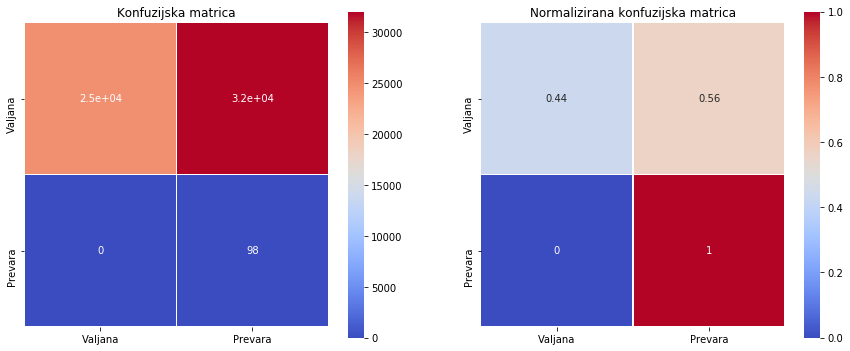

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 1000 puta veća od klase 0 (valjane).
	Precision score: 0.22%
	Recall score: 100.0%
	F1 score: 0.44%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.23      0.37     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.23     56962
   macro avg       0.50      0.61      0.19     56962
weighted avg       1.00      0.23      0.37     56962




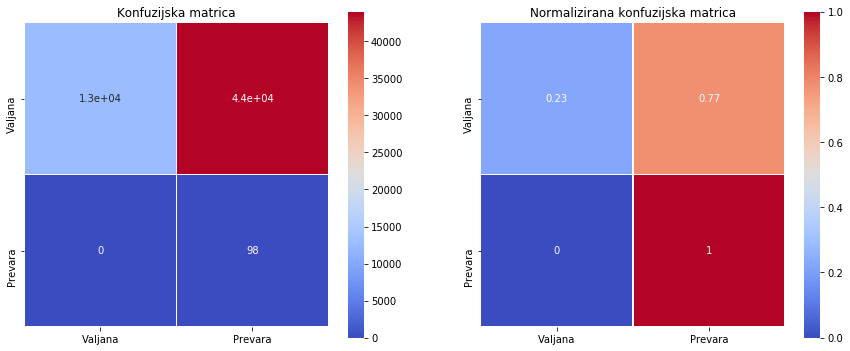

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 10000 puta veća od klase 0 (valjane).
	Precision score: 0.16999999999999998%
	Recall score: 100.0%
	F1 score: 0.35000000000000003%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.01      0.01     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.01     56962
   macro avg       0.50      0.50      0.01     56962
weighted avg       1.00      0.01      0.01     56962




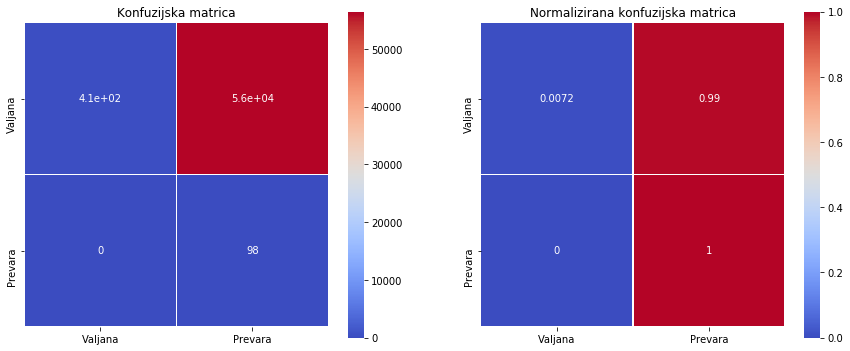

----------------------------------------------------------------------------------------------------


In [59]:
#sada cemo ubaciti tezine u logisticku regresiju


class_weights = [1, 5, 10, 50, 100, 1000, 10000]
colors = ['blue', 'yellow', 'green', 'red', 'purple', 'orange', 'pink']
i = 0
precisions = []
recalls = []
fprs = []
tprs = []
aucs = []
aprcs = []


for weight in class_weights: 
    #log_reg_weighted = LogisticRegression(C=new_log_reg_cut.best_params_['C'], 
     #                                     penalty=new_log_reg_cut.best_params_['penalty'],
      #                                    solver='liblinear', class_weight={0:1, 1:weight}
       #                                  )
    
    log_reg_weighted = LogisticRegression(C=params_cut['C'], 
                                          penalty=params_cut['penalty'],
                                          solver='liblinear', class_weight={0:1, 1:weight}
                                         )
    
    log_reg_weighted.fit(X_usample_cut_train, y_usample_cut_train)
    full_pred_w = log_reg_weighted.predict(X_data_test)
    full_score_w = log_reg_weighted.decision_function(X_data_test)
    print('*'*100)
    print('-'*100)
    print('Tezina klase 1 (prevare) je ' + str(weight) + ' puta veća od klase 0 (valjane).' )
    precision_recall_f1_scores(y_data_test, full_pred_w)
    print()
    print('-'*50)
    print(classification_report(y_data_test, full_pred_w))
    print()
    plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_w), y_data_test_non_fraud_num, y_data_test_fraud_num)
    
    precision, recall, threshold = precision_recall_curve(y_data_test, full_score_w)
    fpr, tpr, thold = roc_curve(y_data_test, full_score_w)
    area_under_curve = auc(fpr,tpr)
    au_pr_curve = auc(recall,precision)
    
    precisions.append(precision)
    recalls.append(recall)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(area_under_curve)
    aprcs.append(au_pr_curve)

    print('-'*100)
    
   
    
plt.show()
    

C:\Users\stvar\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


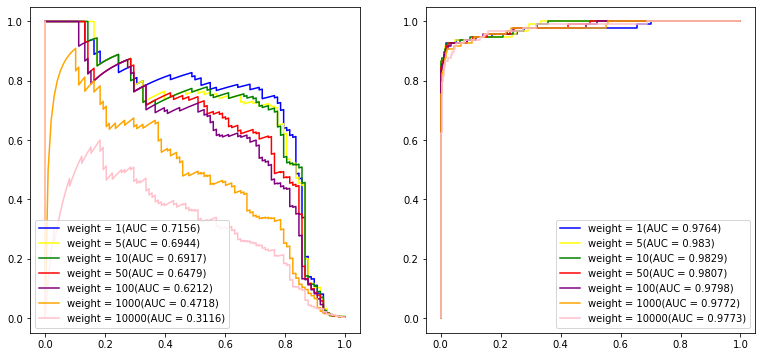

In [60]:
fig_w, ax_w = plt.subplots(1,2,figsize=(13,6))

for i in range(len(colors)):
    ax_w[0].plot(recalls[i], precisions[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aprcs[i], 4)) + ')')
    ax_w[1].plot(fprs[i], tprs[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aucs[i], 4)) + ')' )
ax_w[0].legend()
ax_w[1].legend()
plt.show()

<p>Sada pokušajmo tehniku sa težinama primjeniti za trening na velikom skupu. Tako ne gubimo vrijedne podatke koje možemo upotrijebiti prilikom učenja. </p>

****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 1 puta veća od klase 0 (valjane).
	Precision score: 86.15%
	Recall score: 57.14%
	F1 score: 68.71000000000001%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.57      0.69        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962




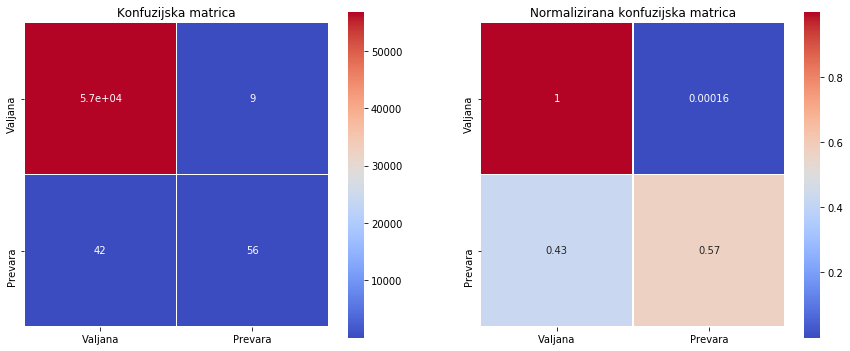

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 5 puta veća od klase 0 (valjane).
	Precision score: 81.05%
	Recall score: 78.57%
	F1 score: 79.79%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.79      0.80        98

    accuracy                           1.00     56962
   macro avg       0.91      0.89      0.90     56962
weighted avg       1.00      1.00      1.00     56962




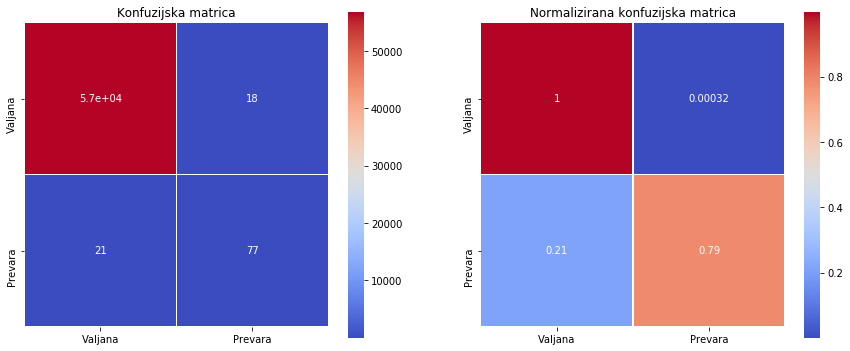

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 10 puta veća od klase 0 (valjane).
	Precision score: 79.21000000000001%
	Recall score: 81.63%
	F1 score: 80.4%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.82      0.80        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962




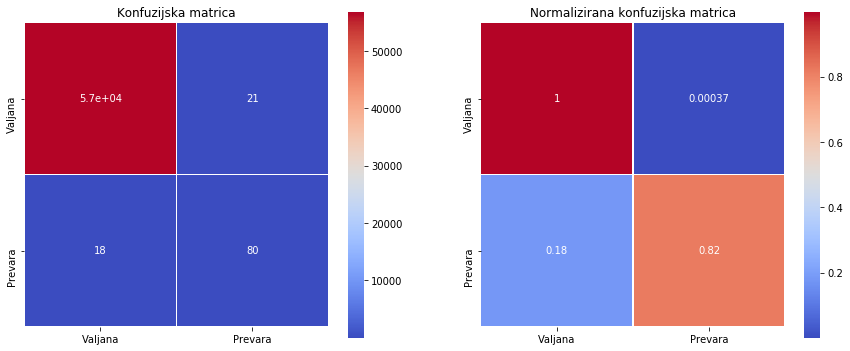

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 50 puta veća od klase 0 (valjane).
	Precision score: 55.92%
	Recall score: 86.72999999999999%
	F1 score: 68.0%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.56      0.87      0.68        98

    accuracy                           1.00     56962
   macro avg       0.78      0.93      0.84     56962
weighted avg       1.00      1.00      1.00     56962




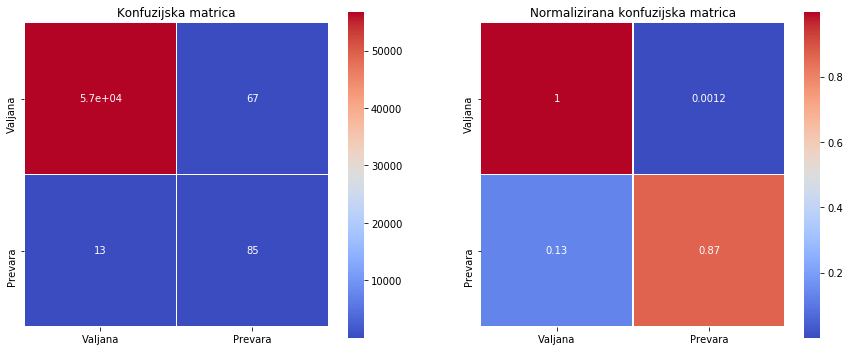

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 100 puta veća od klase 0 (valjane).
	Precision score: 28.62%
	Recall score: 86.72999999999999%
	F1 score: 43.04%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.29      0.87      0.43        98

    accuracy                           1.00     56962
   macro avg       0.64      0.93      0.71     56962
weighted avg       1.00      1.00      1.00     56962




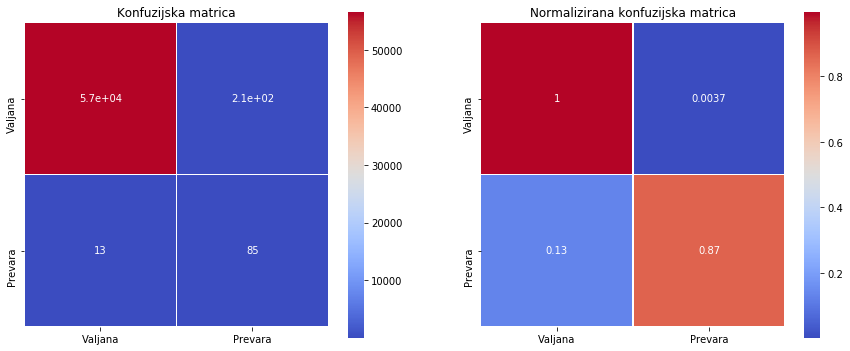

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 1000 puta veća od klase 0 (valjane).
	Precision score: 3.55%
	Recall score: 92.86%
	F1 score: 6.8500000000000005%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.93      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.52     56962
weighted avg       1.00      0.96      0.98     56962




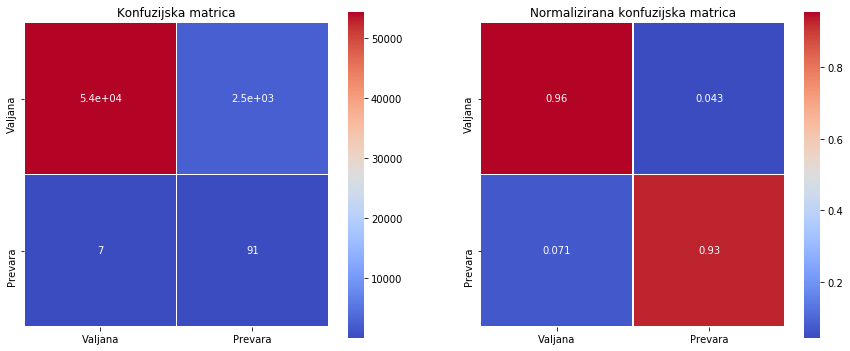

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Tezina klase 1 (prevare) je 10000 puta veća od klase 0 (valjane).
	Precision score: 0.67%
	Recall score: 97.96000000000001%
	F1 score: 1.3299999999999998%

--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.75      0.86     56864
           1       0.01      0.98      0.01        98

    accuracy                           0.75     56962
   macro avg       0.50      0.86      0.44     56962
weighted avg       1.00      0.75      0.86     56962




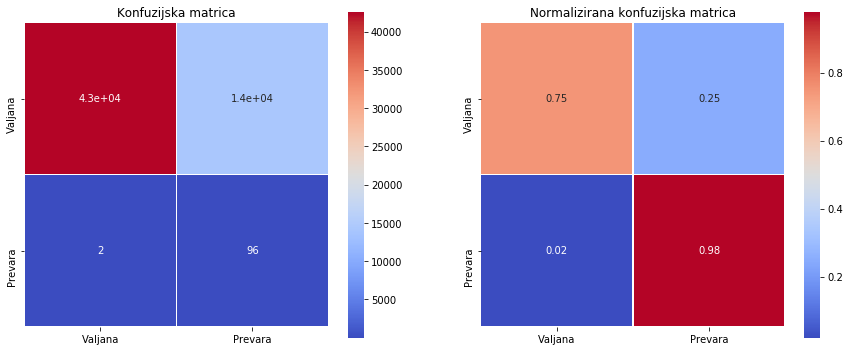

----------------------------------------------------------------------------------------------------


In [61]:
#ovdje treba ubaciti težine, ali za treniranje na cijelom skupu

#sada cemo ubaciti tezine u logisticku regresiju


i = 0
precisions_data = []
recalls_data = []
fprs_data = []
tprs_data = []
aucs_data = []
aprcs_data = []


for weight in class_weights: 
    #log_reg_weighted = LogisticRegression(C=new_log_reg_cut.best_params_['C'], 
     #                                     penalty=new_log_reg_cut.best_params_['penalty'],
      #                                    solver='liblinear', class_weight={0:1, 1:weight}
       #                                  )
    
    data_log_reg_weighted = LogisticRegression(solver='liblinear', class_weight={0:1, 1:weight})
    
    data_log_reg_weighted.fit(X_data_train, y_data_train)
    full_pred_data = data_log_reg_weighted.predict(X_data_test)
    full_score_data = data_log_reg_weighted.decision_function(X_data_test)
    print('*'*100)
    print('-'*100)
    print('Tezina klase 1 (prevare) je ' + str(weight) + ' puta veća od klase 0 (valjane).' )
    precision_recall_f1_scores(y_data_test, full_pred_data)
    print()
    print('-'*50)
    print(classification_report(y_data_test, full_pred_data))
    print()
    plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
    
    precision, recall, threshold = precision_recall_curve(y_data_test, full_score_data)
    fpr, tpr, thold = roc_curve(y_data_test, full_score_data)
    area_under_curve = auc(fpr,tpr)
    au_pr_curve = auc(recall,precision)
    
    precisions_data.append(precision)
    recalls_data.append(recall)
    fprs_data.append(fpr)
    tprs_data.append(tpr)
    aucs_data.append(area_under_curve)
    aprcs_data.append(au_pr_curve)

    print('-'*100)
    
   
    
plt.show()
    

C:\Users\stvar\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


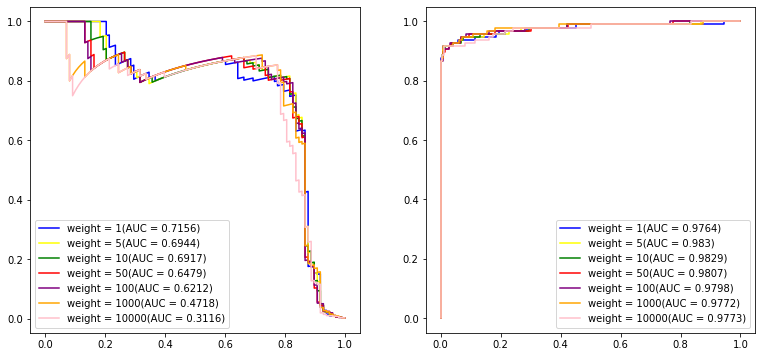

In [62]:
fig_data, ax_data = plt.subplots(1,2,figsize=(13,6))

for i in range(len(colors)):
    ax_data[0].plot(recalls_data[i], precisions_data[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aprcs[i], 4)) + ')')
    ax_data[1].plot(fprs_data[i], tprs_data[i], color=colors[i], label='weight = ' + str(class_weights[i]) + '(AUC = ' + str(round(aucs[i], 4)) + ')' )
ax_data[0].legend()
ax_data[1].legend()
plt.show()

### Redukcija dimenzionalnosti
<p> Sada ćemo se nakratko posvetiti algoritmima za redukciju dimenzionalnosti. Konkretno govorimo o <em>t-SNE</em> i <em>PCA</em>. Opišimo sada malo svaki od njih te prikažimo dobivene rezultate. </p>
<ul>
    <li><em>t-SNE (t-distributed Stochastic Neighbor Embedding)</em> - noviji algoritam koji koristi nelinearnu redukciju dimenzija. Odnosno, dijeli klase tako da granica nije ravna linija (pravac). </li>
    <li><em>PCA (Principal Component Analysis)</em> - ortogonalna linearna projekcija, inače standardan algoritam za redukciju deimnezionalnosti. </li>
</ul>

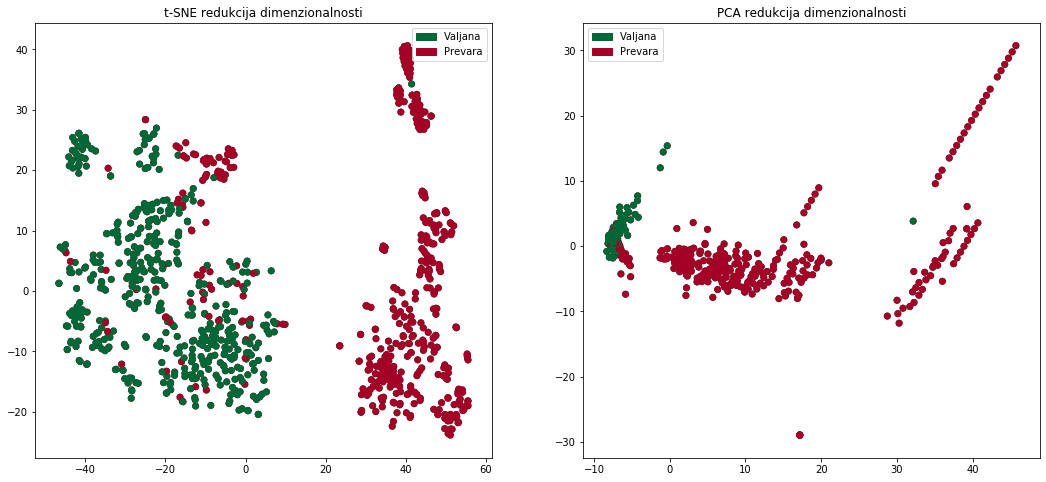

In [64]:
#t-SNE + PCA za skup podataka nakon undersamplinga
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib

cm = matplotlib.cm.get_cmap('RdYlGn_r')
red = cm(256)
green = cm(0)

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_undersampled_cut.values)
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_undersampled_cut.values)


fig_tsne_pca, ax_tsne_pca = plt.subplots(1,2,figsize=(18,8))



non_fraud_patch = mpatches.Patch(color=green, label='Valjana')
fraud_patch = mpatches.Patch(color=red, label='Prevara')

ax_tsne_pca[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y_undersampled_cut == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca[0].scatter(X_tsne[:,0], X_tsne[:,1], c=(y_undersampled_cut == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca[1].scatter(X_pca[:,0], X_pca[:,1], c=(y_undersampled_cut == 0), cmap='RdYlGn_r', label='Valjana')
ax_tsne_pca[1].scatter(X_pca[:,0], X_pca[:,1], c=(y_undersampled_cut == 1), cmap='RdYlGn_r', label='Prevara')

ax_tsne_pca[0].set_title('t-SNE redukcija dimenzionalnosti')
ax_tsne_pca[1].set_title('PCA redukcija dimenzionalnosti')

ax_tsne_pca[0].legend(handles=[non_fraud_patch, fraud_patch])
ax_tsne_pca[1].legend(handles=[non_fraud_patch, fraud_patch])

plt.show()

Iz grafova iznad vidimo da t-SNE dosta bolje odjeljuje klase. Prije svega čini se kao da na drugoj slici (za PCA) ima puno više prevara nego valjanih transakcija (trebalo bi biti podjednako).

### Oversampling

<p>Kod undersamplinga smo smanjili broj valjanih transakcija da odgovara broju prevara. Sada ćemo koristit suportnu tehniku odnosno oversampling. Kod oversamlpinga povećavamo broj prevara tako da odgovara broju valjanih transakcija (dupliciramo transakcije koje su prevare više puta). Ako se sjećamo početka spomenuli smo 2 metode za testiranje kada učimo na sampliranom skupu podatak. Kod oversamplinga ćemo koristiti onu drugu, odnosno vršit ćemo oversampling samo na skupu podataka za treniranje. </p>

In [69]:
#oversampling

non_fraud_data = X_data_train[y_data_train == 0] 
fraud_data = X_data_train[y_data_train == 1]
print('Količina podataka u trening skupovima prije oversamplinga:')
print('\tBroj valjanih transakcija: ' + str(len(non_fraud_data)))
print('\tBroj prevarantskih transakcija: ' + str(len(fraud_data)))
print('\tUkupan broj transakcija: ' + str(len(non_fraud_data)+len(fraud_data)))
y_oversampled = y_data_train.values

Količina podataka u trening skupovima prije oversamplinga:
	Broj valjanih transakcija: 227451
	Broj prevarantskih transakcija: 394
	Ukupan broj transakcija: 227845


In [70]:
non_fraud_data['Class'] = 0
fraud_data['Class'] = 1

C:\Users\stvar\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\stvar\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
collected_data = non_fraud_data
for cycle in range(len(non_fraud_data) // len(fraud_data)):
    collected_data = collected_data.append(fraud_data)
    
    
print('Količina podataka u trening skupu poslije oversamplinga:')
print('\tBroj valjanih transakcija: ' + str(len(collected_data[collected_data['Class'] == 0])))
print('\tBroj prevarantskih transakcija: ' + str(len(collected_data[collected_data['Class'] == 1])))
print('\tUkupan broj transakcija: ' + str(len(collected_data[collected_data['Class'] == 0])+len(collected_data[collected_data['Class'] == 1])))

Količina podataka u trening skupu poslije oversamplinga:
	Broj valjanih transakcija: 227451
	Broj prevarantskih transakcija: 227338
	Ukupan broj transakcija: 454789


In [72]:
#shuffle
collected_data = collected_data.sample(frac=1).reset_index(drop=True)

<p>Također, pošto oversamplingom dobijamo jako puno podataka možemo bez problema izbaciti outlire (kojih će ovdje biti puno više, jer je skup puno veći).</p>

In [74]:
#izbacivanje outliera
print('Negativne korelacije: ' + str(np.where(collected_data.corr()['Class'] < -0.6))) 
print('Pozitivne korelacije: ' + str(np.where(collected_data.corr()['Class'] > 0.6)))

Negativne korelacije: (array([10, 12, 14], dtype=int64),)
Pozitivne korelacije: (array([ 4, 11, 29], dtype=int64),)


In [75]:
#uklanjanje outliera (za negativnu korelaciju)
v10_q1 = collected_data['V10'].quantile(0.25)
v10_q3 = collected_data['V10'].quantile(0.75)
v10_q2 = v10_q3 - v10_q1
v10_cut_off = v10_q2 * 1.5
v10_lower, v10_upper = v10_q1 - v10_cut_off, v10_q3 + v10_cut_off
v10_outliers = [out for out in collected_data['V10'] if out < v10_lower or out > v10_upper]
print('-' * 100)
print('Broj identificiranih outliera nad V10: ' + str(len(v10_outliers)))

v12_q1 = collected_data['V12'].quantile(0.25)
v12_q3 = collected_data['V12'].quantile(0.75)
v12_q2 = v12_q3 - v12_q1
v12_cut_off = v12_q2 * 1.5
v12_lower, v12_upper = v12_q1 - v12_cut_off, v12_q3 + v12_cut_off
v12_outliers = [out for out in collected_data['V12'] if out < v12_lower or out > v12_upper]
print('Broj identificiranih outliera nad V12: ' + str(len(v12_outliers)))


v14_q1 = collected_data['V14'].quantile(0.25)
v14_q3 = collected_data['V14'].quantile(0.75)
v14_q2 = v14_q3 - v14_q1
v14_cut_off = v14_q2 * 1.5
v14_lower, v14_upper = v14_q1 - v14_cut_off, v14_q3 + v14_cut_off
v14_outliers = [out for out in collected_data['V14'] if out < v14_lower or out > v14_upper]
print('Broj identificiranih outliera nad V14: ' + str(len(v14_outliers)))

print('-' * 50)

#uklanjanje outliera (za pozitivne korelaciju)
v4_q1 = collected_data['V4'].quantile(0.25)
v4_q3 = collected_data['V4'].quantile(0.75)
v4_q2 = v4_q3 - v4_q1
v4_cut_off = v4_q2 * 1.5
v4_lower, v4_upper = v4_q1 - v4_cut_off, v4_q3 + v4_cut_off
v4_outliers = [out for out in collected_data['V4'] if out < v4_lower or out > v4_upper]
print('-' * 50)
print('Broj identificiranih outliera nad V4: ' + str(len(v4_outliers)))


v11_q1 = undersampled_data['V11'].quantile(0.25)
v11_q3 = undersampled_data['V11'].quantile(0.75)
v11_q2 = v11_q3 - v11_q1
v11_cut_off = v11_q2 * 1.5
v11_lower, v11_upper = v11_q1 - v11_cut_off, v11_q3 + v11_cut_off
v11_outliers = [out for out in collected_data['V11'] if out < v11_lower or out > v11_upper]
print('Broj identificiranih outliera nad V11: ' + str(len(v11_outliers)))
print('-' * 50)

----------------------------------------------------------------------------------------------------
Broj identificiranih outliera nad V10: 31689
Broj identificiranih outliera nad V12: 16159
Broj identificiranih outliera nad V14: 1154
--------------------------------------------------
--------------------------------------------------
Broj identificiranih outliera nad V4: 6359
Broj identificiranih outliera nad V11: 9813
--------------------------------------------------


In [76]:
collected_data_cut = collected_data.drop(
    collected_data[
        (collected_data['V10'] > v10_upper) | 
        (collected_data['V10'] < v10_lower) |
        (collected_data['V12'] > v12_upper) | 
        (collected_data['V12'] < v12_lower) |
        (collected_data['V14'] > v14_upper) | 
        (collected_data['V14'] < v14_lower) |
        (collected_data['V4'] > v4_upper) | 
        (collected_data['V4'] < v4_lower) |
        (collected_data['V11'] > v11_upper) | 
        (collected_data['V11'] < v11_lower) 
                     ].index)

In [68]:
# X = collected_data_cut.drop('Class', axis=1)
# y = collected_data_cut['Class']
# X_osample_train, X_osample_test, y_osample_train, y_osample_test = train_test_split(X,y,test_size=0.20,random_state=42)
# y_osample_test_non_fraud_num = y_osample_test.value_counts()[0]
# y_osample_test_fraud_num = y_osample_test.value_counts()[1]

# print('-' * 100)
# print('Broj transakcija korišten za treniranje (za oversamplirani dataset): ' + str(len(X_osample_train)))
# print('Broj transakcija korišten za testiranje (za oversamplirani dataset): ' + str(len(X_osample_test)))
# print('Ukupan broj transakcija (za ondersamplirani dataset): ' + str(len(X_osample_train)+len(X_osample_test)))
# print('-' * 100)


----------------------------------------------------------------------------------------------------
Broj transakcija korišten za treniranje (za oversamplirani dataset): 334314
Broj transakcija korišten za testiranje (za oversamplirani dataset): 83579
Ukupan broj transakcija (za ondersamplirani dataset): 417893
----------------------------------------------------------------------------------------------------


In [77]:
X_osample_train = collected_data_cut.drop('Class', axis=1)
y_osample_train = collected_data_cut['Class']


print('-' * 100)
print('Broj transakcija korišten za treniranje (za oversamplirani dataset): ' + str(len(X_osample_train)))
print('-' * 100)

----------------------------------------------------------------------------------------------------
Broj transakcija korišten za treniranje (za oversamplirani dataset): 417893
----------------------------------------------------------------------------------------------------


In [78]:
osample_log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
osample_log_reg.fit(X_osample_train, y_osample_train)
osample_log_reg_est = osample_log_reg.best_estimator_
osample_params = osample_log_reg.best_params_
print('Najbolji parametri: ' + str(osample_params))

training_score_params_osample = cross_val_score(osample_log_reg_est, X_osample_train, y_osample_train, cv=skfold)
print('Rezultat treniranja za logističku regresiju nad oversampliranim datasetom (sa parametrima): ' 
     + str(round(training_score_params_osample.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 0.1, 'penalty': 'l2'}
Rezultat treniranja za logističku regresiju nad oversampliranim datasetom (sa parametrima): 94.28%


In [79]:
# y_pred_osample_params = osample_log_reg_est.predict(X_osample_test)
# y_score_osample_params = osample_log_reg_est.decision_function(X_osample_test)

# print('-'*100)
# print('Za oversamplirani dataset (sa podešenim parametrima):')
# precision_recall_f1_scores(y_osample_test, y_pred_osample_params)
# print('-'*100)
# print(classification_report(y_osample_test, y_pred_osample_params))
# print()
# print('Konfuzijska matrica za oversamplirani dataset')
# plot_confusion_matrix(confusion_matrix(y_osample_test, y_pred_osample_params), y_osample_test_non_fraud_num, y_osample_test_fraud_num)
# print()
# print('-'*100)
# print('ROC za cijeli dataset')
# plot_roc_auc_curve(y_osample_test, y_score_osample_params)
# plot_precision_recall_curve(y_osample_test, y_score_osample_params)

<p>Kao što smo i spomenuli, testni skup u ovom slučaju je upravo originalni test skup. <br>
    <b>Napomena</b>: Važno je za primjetiti da je oversampling jako spor (jer se za testiranje koristi jako puno podataka), pa ovu tehniku nećemo upotrebljavati kod svih algoritama za učenje.</p>

----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 6.1%
	Recall score: 91.84%
	F1 score: 11.44%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


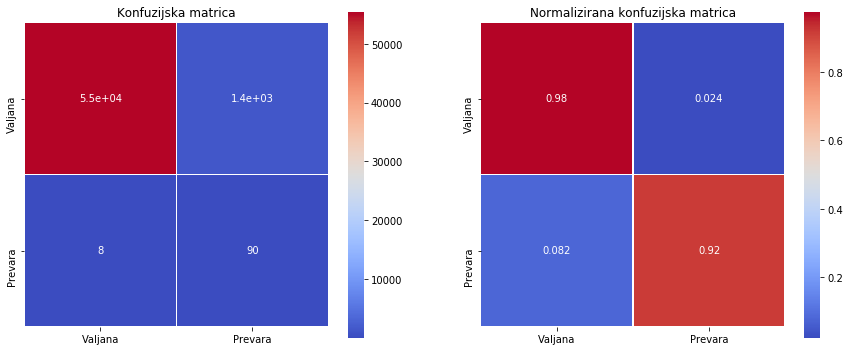

----------------------------------------------------------------------------------------------------


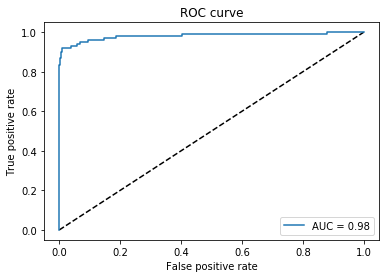

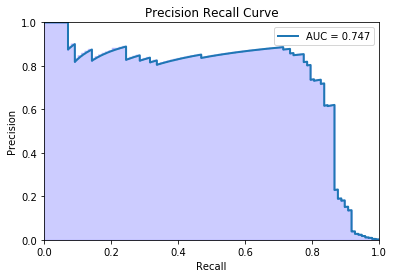

In [80]:
full_pred_osample = osample_log_reg_est.predict(X_data_test)
full_pred_score_osample = osample_log_reg_est.decision_function(X_data_test)

print('-'*100)
print('Predikcija za cijeli dataset:')
precision_recall_f1_scores(y_data_test, full_pred_osample)
print()
print('-'*100)
print(classification_report(y_data_test, full_pred_osample))
print()
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_osample), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)
plot_roc_auc_curve(y_data_test, full_pred_score_osample)
plot_precision_recall_curve(y_data_test, full_pred_score_osample)

<p>Sada ćemo umjesto klasičnog oversamplinga (u kojem smo samo dodavali duplicirane podatke o prevarama) koristiti SMOTE (Synthetic Minority Oversampling TEhnique). SMOTE koristi podatke o prevarama da bi sintetski stvorio nove podatke.</p> 

In [61]:
#SMOTE
from imblearn.over_sampling import SMOTE

smote_log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)

smote_pipeline = imbalanced_make_pipeline(SMOTE(random_state=42, sampling_strategy='minority'), smote_log_reg)
smote_model = smote_pipeline.fit(X_data_train, y_data_train)
smote_estimator = smote_log_reg.best_estimator_
smote_pred = smote_estimator.predict(X_data_test)
smote_params = smote_log_reg.best_params_
#smote = SMOTE(sampling_strategy='minority', random_state=42)
#smote_X, smote_y = smote.fit_resample(X_data_train, y_data_train)
#print('Broj valjanih transakcija nakon SMOTE-a: ' + str(len(smote_X[smote_X['Class'] == 0])))
#print('Broj valjanih transakcija nakon SMOTE-a: ' + str(len(smote_X[smote_X['Class'] == 1])))

In [62]:
print('Logistička regresija s parametrima (sa SMOTE)')
print('Najbolji parametri: ' + str(smote_params))

training_score_params_smote = cross_val_score(smote_estimator, X_data_train, y_data_train, cv=skfold)
print('Rezultat treniranja za logističku regresiju nad SMOTE-oversampliranim datasetom (sa parametrima): ' 
     + str(round(training_score_params_smote.mean(), 4) * 100) + '%')

Logistička regresija s parametrima (sa SMOTE)
Najbolji parametri: {'C': 100, 'penalty': 'l2'}
Rezultat treniranja za logističku regresiju nad SMOTE-oversampliranim datasetom (sa parametrima): 99.92%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 5.82%
	Recall score: 91.84%
	F1 score: 10.94%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


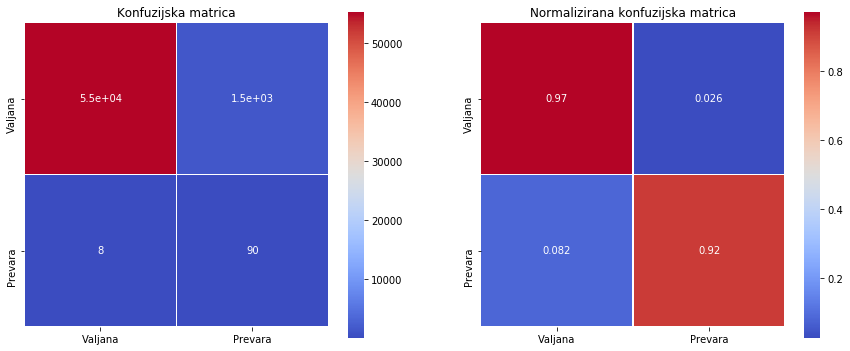

----------------------------------------------------------------------------------------------------


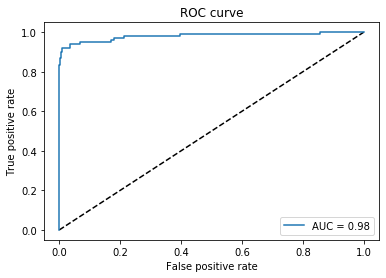

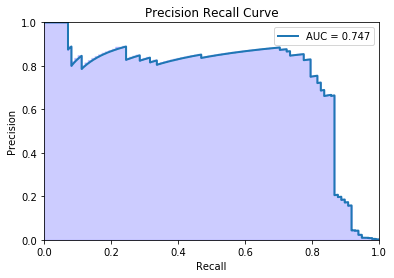

In [63]:
full_pred_smote = smote_estimator.predict(X_data_test)
full_pred_score_smote = smote_estimator.decision_function(X_data_test)

print('-'*100)
print('Predikcija za cijeli dataset:')
precision_recall_f1_scores(y_data_test, full_pred_smote)
print()
print('-'*100)
print(classification_report(y_data_test, full_pred_smote))
print()
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_smote), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)
plot_roc_auc_curve(y_data_test, full_pred_score_smote)
plot_precision_recall_curve(y_data_test, full_pred_score_smote)

<p>Prokomentirajmo sada rezultate koje smo dobili koristeći oversampling tehniku SMOTE. Vidimo da su rezultati dosta slični kao i kad smo koristili neku drugu tehniku ujednačavanja klasa. Valjalo bi spomenuti da je ovaj model ispravno prepoznao 90 od 98 prevara, dok je samo 1500 valjanih transakcija svrstao u preavare. 1500 jest dosta no može se provjeriti ručno. </p>

In [68]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_smote, y_smote = smote.fit_sample(X, y)

In [71]:
# print('Broj valjanih transakcija nakon SMOTE-a: ' + str(len(np.where(y_smote == 0)[0])))
# print('Broj prevarantskih transakcija nakon SMOTE-a: ' + str(len(np.where(y_smote == 1)[0])))
print('Broj valjanih transakcija nakon SMOTE-a: ' + str(y_smote.value_counts()[0]))
print('Broj prevarantskih transakcija nakon SMOTE-a: ' + str(y_smote.value_counts()[1]))
print('Ukupan broj transakcija nakon SMOTE-a: ' + str(y_smote.value_counts()[0]+y_smote.value_counts()[1]))

Broj valjanih transakcija nakon SMOTE-a: 284315
Broj prevarantskih transakcija nakon SMOTE-a: 284315
Ukupan broj transakcija nakon SMOTE-a: 568630


In [72]:
X_smote.head()

Amount_After_Scaling        V1        V2        V3        V4        V5  \
0              0.244964 -1.359807 -0.072781  2.536347  1.378155 -0.338321   
1             -0.342475  1.191857  0.266151  0.166480  0.448154  0.060018   
2              1.160686 -1.358354 -1.340163  1.773209  0.379780 -0.503198   
3              0.140534 -0.966272 -0.185226  1.792993 -0.863291 -0.010309   
4             -0.073403 -1.158233  0.877737  1.548718  0.403034 -0.407193   

         V6        V7        V8        V9  ...       V19       V20       V21  \
0  0.462388  0.239599  0.098698  0.363787  ...  0.403993  0.251412 -0.018307   
1 -0.082361 -0.078803  0.085102 -0.255425  ... -0.145783 -0.069083 -0.225775   
2  1.800499  0.791461  0.247676 -1.514654  ... -2.261857  0.524980  0.247998   
3  1.247203  0.237609  0.377436 -1.387024  ... -1.232622 -0.208038 -0.108300   
4  0.095921  0.592941 -0.270533  0.817739  ...  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053  
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724  
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458  
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153  

[5 rows x 29 columns]

In [67]:
#smote - undersampling combination - dovršiti
#borderlinesmote
#adasyn
#mozda podesiti k_neighbors za SMOTE i dodati drugacije sampling strategije

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter

under_sampler = RandomUnderSampler(sampling_strategy='majority')
smote_sampler = SMOTE(sampling_strategy='minority')
#smote_under_log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
smote_under_log_reg = LogisticRegression()

smote_under_pipeline = imbalanced_make_pipeline(smote_sampler, under_sampler, smote_under_log_reg)
smote_under_model = smote_under_pipeline.fit(X_data_train, y_data_train)
#smote_under_estimator = smote_under_log_reg.best_estimator_
smote_under_pred = smote_under_estimator.predict(X_data_test)
#smote_under_params = smote_under_log_reg.best_params_

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
training_smote_under_score = cross_val_score(smote_under_pipeline, X_data_train, y_data_train, cv=rskf)

print('Logistička regresija (sa kombinacijom SMOTE-a i nasumičnog undersampla)')
#print('Najbolji parametri: ' + str(smote_under_params))

print('Rezultat treniranja za logističku regresiju nad kombinacijom SMOTE-a i nasumičnog unersampla: ' 
     + str(round(traingin_smote_under_scores.mean(), 4) * 100) + '%')

In [ ]:
full_pred_smote_under = smote_under_estimator.predict(X_data_test)
full_pred_score_smote_under = smote_under_estimator.decision_function(X_data_test)

print('-'*100)
print('Predikcija za cijeli dataset:')
precision_recall_f1_scores(y_data_test, full_pred_smote_under)
print()
print('-'*100)
print(classification_report(y_data_test, full_pred_smote_under))
print()
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_smote_under), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)
plot_roc_auc_curve(y_data_test, full_pred_score_smote_under)
plot_precision_recall_curve(y_data_test, full_pred_score_smote_under)

<p>Sada ćemo iskoristit jednu posebnu varijantu SMOTE-a za oversampling zvanu Borderline SMOTE. Ta posebna vrsta SMOTE algoritma koristi rubne primjere (one koji su često pogrešno prepoznati od strane modela) i nad njima vršimo oversampling klasičnom SMOTE tehnikom. Moramo paziti da se oversampling izvršava samo na skupu za treniranje.</p> 

In [75]:
# #borderline smote
# from imblearn.over_sampling import BorderlineSMOTE
# border_smote = BorderlineSMOTE(sampling_strategy='minority', k_neighbors=3)
# X_border_smote, y_border_smote = border_smote.fit_resample(X, y)
# y_border_smote_non_fraud_num = y_border_smote.value_counts()[0]
# y_border_smote_fraud_num = y_border_smote.value_counts()[1]

# X_border_smote_train, X_border_smote_test, y_border_smote_train, y_border_smote_test = train_test_split(X_border_smote, y_border_smote, test_size=0.20, random_state=42)
# y_border_smote_test_non_fraud_num = y_border_smote_test.value_counts()[0]
# y_border_smote_test_fraud_num = y_border_smote_test.value_counts()[1]

# print('Broj valjanih transakcija nakon SMOTE-a: ' + str(y_border_smote_non_fraud_num))
# print('Broj prevarantskih transakcija nakon SMOTE-a: ' + str(y_border_smote_fraud_num))
# print('Ukupan broj transakcija nakon SMOTE-a: ' + str(y_border_smote_fraud_num + y_border_smote_non_fraud_num))

# print('Broj transakcija u skupu za treniranje nakon SMOTE-a: ' + str(len(y_border_smote_train)))
# print('Broj transakcija u skupu za testiranje nakon SMOTE-a: ' + str(len(y_border_smote_test)))

In [83]:
#borderline smote
from imblearn.over_sampling import BorderlineSMOTE
border_smote = BorderlineSMOTE(sampling_strategy='minority', k_neighbors=3)
X_border_smote_train, y_border_smote_train = border_smote.fit_resample(X_data_train, y_data_train)
y_border_smote_non_fraud_num = y_border_smote_train.value_counts()[0]
y_border_smote_fraud_num = y_border_smote_train.value_counts()[1]

# X_border_smote_train, X_border_smote_test, y_border_smote_train, y_border_smote_test = train_test_split(X_border_smote, y_border_smote, test_size=0.20, random_state=42)
# y_border_smote_test_non_fraud_num = y_border_smote_test.value_counts()[0]
# y_border_smote_test_fraud_num = y_border_smote_test.value_counts()[1]

print('Broj valjanih transakcija u trening skupu nakon SMOTE-a: ' + str(y_border_smote_non_fraud_num))
print('Broj prevarantskih transakcija u trenig skupu nakon SMOTE-a: ' + str(y_border_smote_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon SMOTE-a: ' + str(y_border_smote_fraud_num + y_border_smote_non_fraud_num))

#print('Broj transakcija u skupu za treniranje nakon SMOTE-a: ' + str(len(y_border_smote_train)))
#print('Broj transakcija u skupu za testiranje nakon SMOTE-a: ' + str(len(y_border_smote_test)))

Broj valjanih transakcija u trening skupu nakon SMOTE-a: 227451
Broj prevarantskih transakcija u trenig skupu nakon SMOTE-a: 227451
Ukupan broj transakcija u trening skupu nakon SMOTE-a: 454902


In [78]:
# border_smote_log_reg = GridSearchCV(LogisticRegression(solver='liblinear'), log_reg_params)
border_smote_log_reg = LogisticRegression(solver='liblinear')
border_smote_log_reg.fit(X_border_smote_train, y_border_smote_train)
# borer_smote_est = border_smote_log_reg.best_estimator_
# border_smote_params = border_smote_log_reg.best_params_
# print('Najbolji parametri: ' + str(border_smote_params))

border_smote_training_score = cross_val_score(border_smote_log_reg, X_border_smote_train, y_border_smote_train, cv=skfold)
print('Rezultat treniranja za logističku regresiju nad BorderlineSMOTE datasetom: ' 
     + str(round(border_smote_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad BorderlineSMOTE datasetom: 99.53999999999999%


In [79]:
#ovo je za prvu metodu

# pred_border_smote = border_smote_log_reg.predict(X_border_smote_test)
# pred_score_border_smote = border_smote_log_reg.decision_function(X_border_smote_test)

# print('-'*100)
# print('Predikcija za BorderlineSMOTE dataset:')
# precision_recall_f1_scores(y_border_smote_test, pred_border_smote)
# print()
# print('-'*100)
# print(classification_report(y_border_smote_test, pred_border_smote))
# print()
# print('-'*100)
# plot_confusion_matrix(confusion_matrix(y_border_smote_test, pred_border_smote), y_border_smote_test_non_fraud_num, y_border_smote_test_fraud_num)
# print('-'*100)
# plot_roc_auc_curve(y_border_smote_test, pred_score_border_smote)
# plot_precision_recall_curve(y_border_smote_test, pred_score_border_smote)

----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 15.78%
	Recall score: 84.69%
	F1 score: 26.6%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.16      0.85      0.27        98

    accuracy                           0.99     56962
   macro avg       0.58      0.92      0.63     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


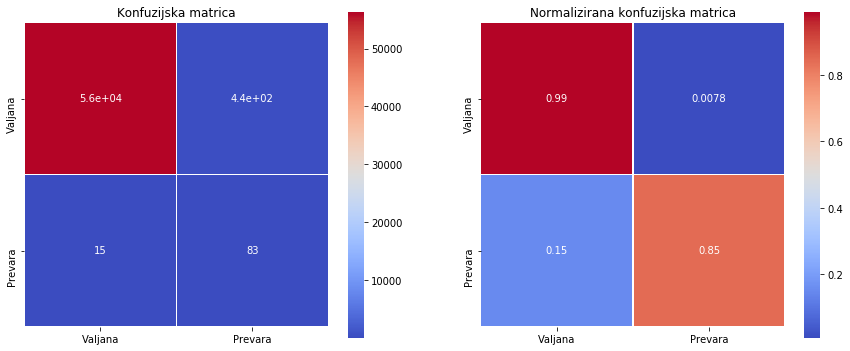

----------------------------------------------------------------------------------------------------


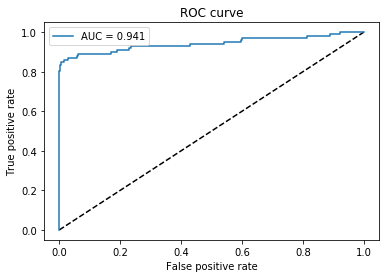

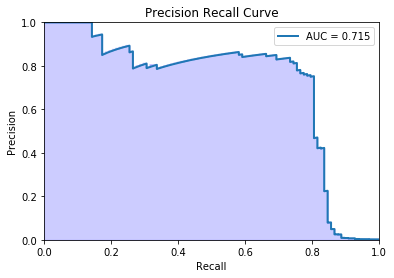

In [81]:
full_pred_border_smote = border_smote_log_reg.predict(X_data_test)
full_pred_score_border_smote = border_smote_log_reg.decision_function(X_data_test)

print('-'*100)
print('Predikcija za cijeli dataset:')
precision_recall_f1_scores(y_data_test, full_pred_border_smote)
print()
print('-'*100)
print(classification_report(y_data_test, full_pred_border_smote))
print()
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_border_smote), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)
plot_roc_auc_curve(y_data_test, full_pred_score_border_smote)
plot_precision_recall_curve(y_data_test, full_pred_score_border_smote)

<p>Vidimo da smo borderline SMOTE-om dobili dosta drugačije rezultate nego korištenjem običnog SMOTE-a. Prvo, spomenimo da smo preopznali samo 85 prevara (od 98) što je čak 5 manje nego kad smo koristili klasičan SMOTE. S druge strane, model sa klasičnim SMOTE-om je prepoznao čak 1500 valjnih transakcija kao prevare, dok je model koji je koristio BorderlineSMOTE pogrešno klasificirao samo 440 valjanih transakcija.</p>

<p>Za kraj ovog dijela o SMOTE-u ćemo iskoristiti još jednu zanimljivu modifikaciju SMOTE-a zvanu ADASYN (ADAptive SYNthetic sampling. Kod ADASYNA generiramo <em>više</em> sinstetskih primjera tamo gdje je gustoća primjera koji spadaju u malobrojniju klasu (u ovom slučaju klasa 1 - prevara) niska, dok tamo gdje je gustoća primjera koji su prevare generiramo manje sintetskih primjera.</p>


In [82]:
# #adasyn
# from imblearn.over_sampling import ADASYN

# adasyn = ADASYN(sampling_strategy='minority', n_neighbors=3)
# X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
# y_adasyn_non_fraud_num = y_adasyn.value_counts()[0]
# y_adasyn_fraud_num = y_adasyn.value_counts()[1]

# X_adasyn_train, X_adasyn_test, y_adasyn_train, y_adasyn_test = train_test_split(X_adasyn, y_adasyn, test_size=0.20, random_state=42)
# y_adasyn_test_non_fraud_num = y_adasyn_test.value_counts()[0]
# y_adasyn_test_fraud_num = y_adasyn_test.value_counts()[1]

# print('Broj valjanih transakcija nakon ADASYN-a: ' + str(y_adasyn_non_fraud_num))
# print('Broj prevarantskih transakcija nakon ADASYN-a: ' + str(y_adasyn_fraud_num))
# print('Ukupan broj transakcija nakon ADASYN-a: ' + str(y_adasyn_fraud_num + y_adasyn_non_fraud_num))

# print('Broj transakcija u skupu za treniranje nakon ADASYN-a: ' + str(len(y_adasyn_train)))
# print('Broj transakcija u skupu za testiranje nakon ADASYN-a: ' + str(len(y_adasyn_test)))

Broj valjanih transakcija nakon ADASYN-a: 284315
Broj prevarantskih transakcija nakon ADASYN-a: 284307
Ukupan broj transakcija nakon ADASYN-a: 568622
Broj transakcija u skupu za treniranje nakon ADASYN-a: 454897
Broj transakcija u skupu za testiranje nakon ADASYN-a: 113725


In [86]:
#adasyn
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy='minority', n_neighbors=3)
X_adasyn_train, y_adasyn_train = adasyn.fit_resample(X_data_train, y_data_train)
y_adasyn_non_fraud_num = y_adasyn_train.value_counts()[0]
y_adasyn_fraud_num = y_adasyn_train.value_counts()[1]

print('Broj valjanih transakcija u trening skupu nakon ADASYN-a: ' + str(y_adasyn_non_fraud_num))
print('Broj prevarantskih transakcija u trening skupu nakon ADASYN-a: ' + str(y_adasyn_fraud_num))
print('Ukupan broj transakcija u trening skupu nakon ADASYN-a: ' + str(y_adasyn_fraud_num + y_adasyn_non_fraud_num))

Broj valjanih transakcija u trening skupu nakon ADASYN-a: 227451
Broj prevarantskih transakcija u trening skupu nakon ADASYN-a: 227474
Ukupan broj transakcija u trening skupu nakon ADASYN-a: 454925


In [85]:

adasyn_log_reg = LogisticRegression(solver='liblinear')
adasyn_log_reg.fit(X_adasyn_train, y_adasyn_train)

adasyn_training_score = cross_val_score(adasyn_log_reg, X_adasyn_train, y_adasyn_train, cv=skfold)
print('Rezultat treniranja za logističku regresiju nad ADASYN datasetom: ' 
     + str(round(adasyn_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za logističku regresiju nad ADASYN datasetom: 89.7%


In [86]:
# pred_adasyn = adasyn_log_reg.predict(X_adasyn_test)
# pred_score_adasyn = adasyn_log_reg.decision_function(X_adasyn_test)

# print('-'*100)
# print('Predikcija za ADASYN dataset:')
# precision_recall_f1_scores(y_adasyn_test, pred_adasyn)
# print()
# print('-'*100)
# print(classification_report(y_adasyn_test, pred_adasyn))
# print()
# print('-'*100)
# plot_confusion_matrix(confusion_matrix(y_adasyn_test, pred_adasyn), y_adasyn_test_non_fraud_num, y_adasyn_test_fraud_num)
# print('-'*100)
# plot_roc_auc_curve(y_adasyn_test, pred_score_adasyn)
# plot_precision_recall_curve(y_adasyn_test, pred_score_adasyn)

----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.69%
	Recall score: 94.89999999999999%
	F1 score: 3.32%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56864
           1       0.02      0.95      0.03        98

    accuracy                           0.90     56962
   macro avg       0.51      0.93      0.49     56962
weighted avg       1.00      0.90      0.95     56962


----------------------------------------------------------------------------------------------------


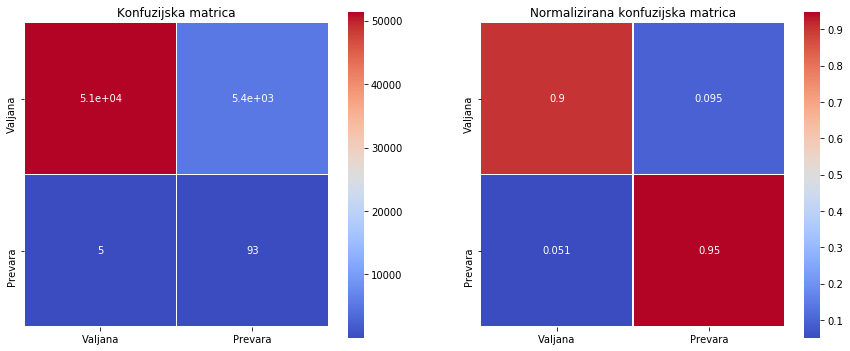

----------------------------------------------------------------------------------------------------


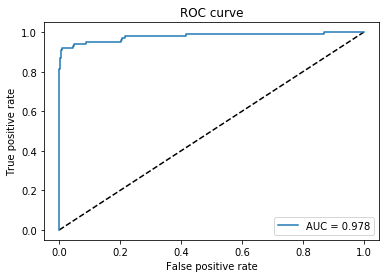

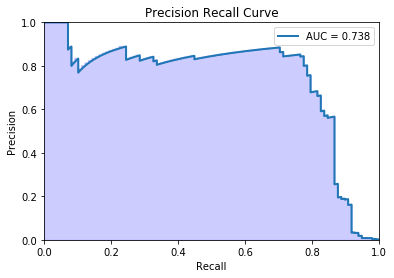

In [87]:
full_pred_adasyn = adasyn_log_reg.predict(X_data_test)
full_pred_score_adasyn = adasyn_log_reg.decision_function(X_data_test)

print('-'*100)
print('Predikcija za cijeli dataset:')
precision_recall_f1_scores(y_data_test, full_pred_adasyn)
print()
print('-'*100)
print(classification_report(y_data_test, full_pred_adasyn))
print()
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_adasyn), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)
plot_roc_auc_curve(y_data_test, full_pred_score_adasyn)
plot_precision_recall_curve(y_data_test, full_pred_score_adasyn)

<p>Rezultati dobiveni ADASYN-om se čine kao potpuna razlika u odnosu na one dobivene Borderline SMOTE-om. Korištenjem ADASYN-a model izgleda kao da je naučio preopznavati dosta više transakcija kao prevare. Tako da u tom slučaju imamo čak 93 dobro prepoznate prevare (što je puno bolje od 85 na modelu koji je koristio Borderline SMOTE), dok je čak 5400 valjanih transakcija prepoznato kao prevara (što je dosta lošije od modela koji je korsitio Borderline SMOTE i svrstao samo 440 valjanih transakcija u prevare).</p>

<p>Time smo završili sa logističkom regresijom. Sada možemo uzeti neke druge klasifikatore i vidjet hoće li njihovo korištenje davati bolje rezultate.</p>

## Stabla Odluke

Sljedeći klasifikator koji koristimo je stablo odluke. Pošto su podaci već podijeljeni u skup za treniranje i skup za testiranje jedino što trebamo jest trenirati naš model. Kao i kod logističke regresije trening ćemo prvo provesti nad cijelim skupom podataka za treniranje (<i>X_data_train</i>, <i>y_data_train</i>), a nakon toga ćemo kao i za logističku regresiju iskoristiti skup podataka dobiven undersamplingom. Zbog sporosti klasifikatora stabla odluke, ovdje nećemo koristit skup podataka dobiven oversamplingom (jer bi trajalo predugo).

In [68]:
#DecisionTree


In [88]:
#decision tree - nad svim podacima
dt_data = DecisionTreeClassifier()
dt_data.fit(X_data_train, y_data_train)
dt_data_training_score = cross_val_score(dt_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za stabla odluke nad cijelim datasetom: " + 
      str(round(dt_data_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za stabla odluke nad cijelim datasetom: 99.91%


----------------------------------------------------------------------------------------------------
Za cijeli dataset:
	Precision score: 73.83%
	Recall score: 80.61%
	F1 score: 77.07000000000001%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.81      0.77        98

    accuracy                           1.00     56962
   macro avg       0.87      0.90      0.89     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


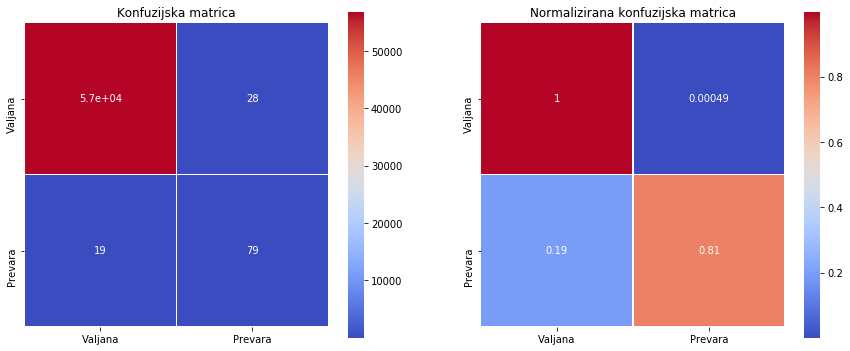

----------------------------------------------------------------------------------------------------


In [89]:
#nad svim podacima test
dt_y_pred_data = dt_data.predict(X_data_test)
#dt_y_score_data = dt_data.decision_function(X_data_test)

print('--'*50)
print('Za cijeli dataset:')
precision_recall_f1_scores(y_data_test, dt_y_pred_data)
print()
print('--'*50)
print(classification_report(y_data_test, dt_y_pred_data))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, dt_y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)
#plot_roc_auc_curve(y_data_test, dt_y_score_data)
#plot_precision_recall_curve(y_data_test, dt_y_score_data)



<p><b>Napomena</b>: Kod stabala odluke nemamo metodu <em>decision_function()</em> pa stoga ne možemo koristiti izlaz te funkcije kako bismo mogli nacrtati ROC-krivulju te PR-krivulju. <br>
Sada pogledajmo kakvi su rezultati treniranja i testiranja. Rezultat treniranja je 99.91% što znači da model skoro savršeno klasificira svaki podatak iz trening skupa. No provjerimo sada rezultate testiranja. Prvo što uočavamo je da ovaj model koji koristi stabla odluke ispravno klasificirao 79 od 98 prevara, od čega smo imali dosta boljih rezultata. Ono što je prednost ovog modela u odnosu na prethodne je preciznost i f1-mjera, koji su puno veći nego kod bilo kojeg dosadašnjeg modela. Vidimo da je samo 28 valjanih transakcija svrstano u prevare, te je 19 prevara svrstano u valjane transakcije. Odnosno, samo 47 transakcija je krivo klasificirao. Kod logističke regresije je bilo vrlo slično kada smo koristili cijeli originalni skup za trening, no razlika je što je ovdje samo 19 prevara koje su svrstane u valjane, dok je model koji koristi logističku regresiju svrstao njih 41. <br> Sada ćemo provesti undersampling i vidjeti hoćemo li i tu dobiti bolje rezultate.</p>

In [90]:
#undersample DT
dt_usample = DecisionTreeClassifier()
dt_usample.fit(X_usample_train, y_usample_train)
dt_training_score_usample = cross_val_score(dt_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za stabla odluke nad undersampliranim datasetom: " + 
      str(round(dt_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za stabla odluke nad undersampliranim datasetom: 90.85%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 87.16000000000001%
	Recall score: 94.06%
	F1 score: 90.48%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        96
           1       0.87      0.94      0.90       101

    accuracy                           0.90       197
   macro avg       0.90      0.90      0.90       197
weighted avg       0.90      0.90      0.90       197


----------------------------------------------------------------------------------------------------


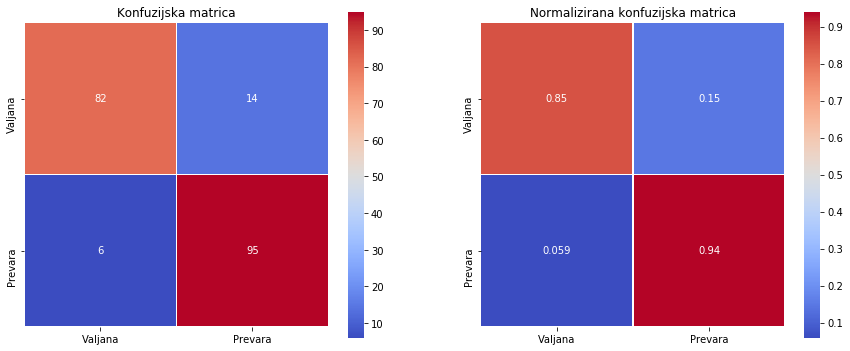

----------------------------------------------------------------------------------------------------
ROC i PR krivulje:


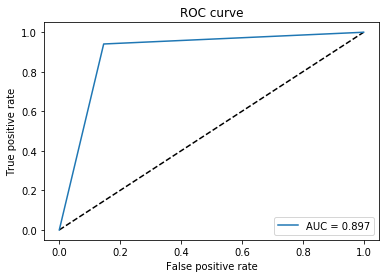

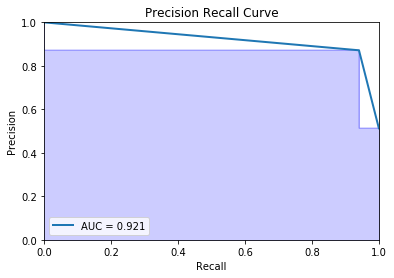

****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     56864
           1       0.02      0.99      0.03        98

    accuracy                           0.89     56962
   macro avg       0.51      0.94      0.49     56962
weighted avg       1.00      0.89      0.94     56962


----------------------------------------------------------------------------------------------------


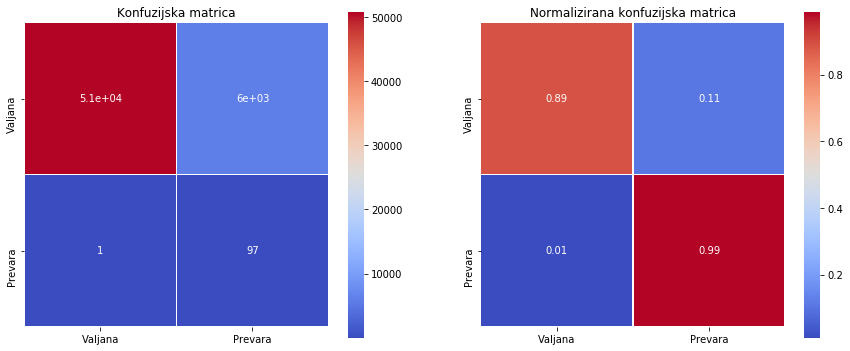

----------------------------------------------------------------------------------------------------
ROC i PR krivulje:


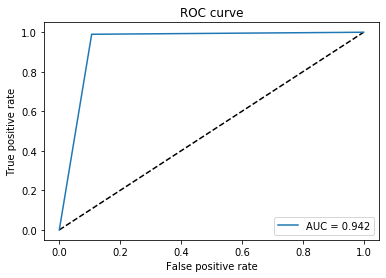

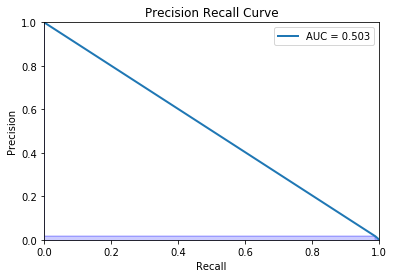

In [91]:
#nad usample test
dt_y_pred_usample = dt_usample.predict(X_usample_test)
dt_y_score_usample = dt_usample.predict_proba(X_usample_test)[:, 1]

dt_y_full_pred = dt_usample.predict(X_data_test)
dt_y_full_score = dt_usample.predict_proba(X_data_test)[:, 1]
print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, dt_y_pred_usample)
print()
print('--'*50)
print(classification_report(y_usample_test, dt_y_pred_usample))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, dt_y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('ROC i PR krivulje:')
plot_roc_auc_curve(y_usample_test, dt_y_score_usample)
plot_precision_recall_curve(y_usample_test, dt_y_score_usample)

print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
print()
print('--'*50)
print(classification_report(y_data_test, dt_y_full_pred))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, dt_y_full_pred), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)
print('ROC i PR krivulje:')
plot_roc_auc_curve(y_data_test, dt_y_full_score)
plot_precision_recall_curve(y_data_test, dt_y_full_score)







<p>Testiranje na undersampliranom skupu podataka, kao i prije, koristimo samo da provjerimo uči li model kako treba, pa njegove rezultate ne interpretiramo.<br>
Rezultati koje smo dobili testiranjem na originalnom skupu podataka su vrlo zanimljivi. Najprije napomenimo da je čak 97 prevara ispravno klasificirano (odnosno samo 1 prevaru je model svrstao u valjane transakcije). S druge strane, mana ovog klasifikatora je to što je čak 6000 valjanih transakcija svrstao kao prevare.</p>

In [95]:
np.count_nonzero(dt_y_full_score), len(dt_y_full_score)

(6146, 56962)

In [96]:
#len(np.where(dt_y_full_score == y_data_test.values)[0]), len(y_data_test.values)
#len(np.where(dt_y_score_usample == 1)[0])

In [97]:
len(np.where(dt_y_score_usample == y_usample_test.values)[0]), len(y_usample_test.values)

(177, 197)

In [98]:
#true positives
tps = len(np.intersect1d(np.where(dt_y_score_usample == 1), np.where(dt_y_score_usample == y_usample_test)))
#false negatives
fns = len(np.intersect1d(np.where(dt_y_score_usample == 0)[0], np.where(dt_y_score_usample != y_usample_test)))
pos = tps + fns

tpr = tps/pos
print('True positive rate: ' + str(tpr))



True positive rate: 0.9405940594059405


In [99]:
#false positives 
fps = len(np.intersect1d(np.where(dt_y_score_usample == 1)[0], np.where(dt_y_score_usample != y_usample_test)))
#true negatives
tns = len(np.intersect1d(np.where(dt_y_score_usample == 0), np.where(dt_y_score_usample == y_usample_test)))
neg = fps + tns

fpr = fps/neg
print('False positive rate: ' + str(fpr))

False positive rate: 0.14583333333333334


In [100]:
#np.array(np.where(dt_y_pred_data == 1)).shape[1], np.array(np.where(dt_y_pred_data == 0)).shape[1]

In [77]:
# from sklearn.tree import export_graphviz
# from subprocess import call
# from IPython.display import Image

# export_graphviz(dt_usample, out_file='tree_usample.dot', 
#                 feature_names = X_usample_train.columns.tolist(),
#                 class_names = ['Valjana','Prevara'],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# call(['dot','tree_usample.dot', '-Tpng', '-o', 'tree_usample.png'], shell=True)
# Image(filename = 'tree_usample.png')

<p>Idemo sada prikazati proces odlučivanja u stablu odluke, odnosno koje su izabrane značajke i kojim su redom birane od strane modela.</p>

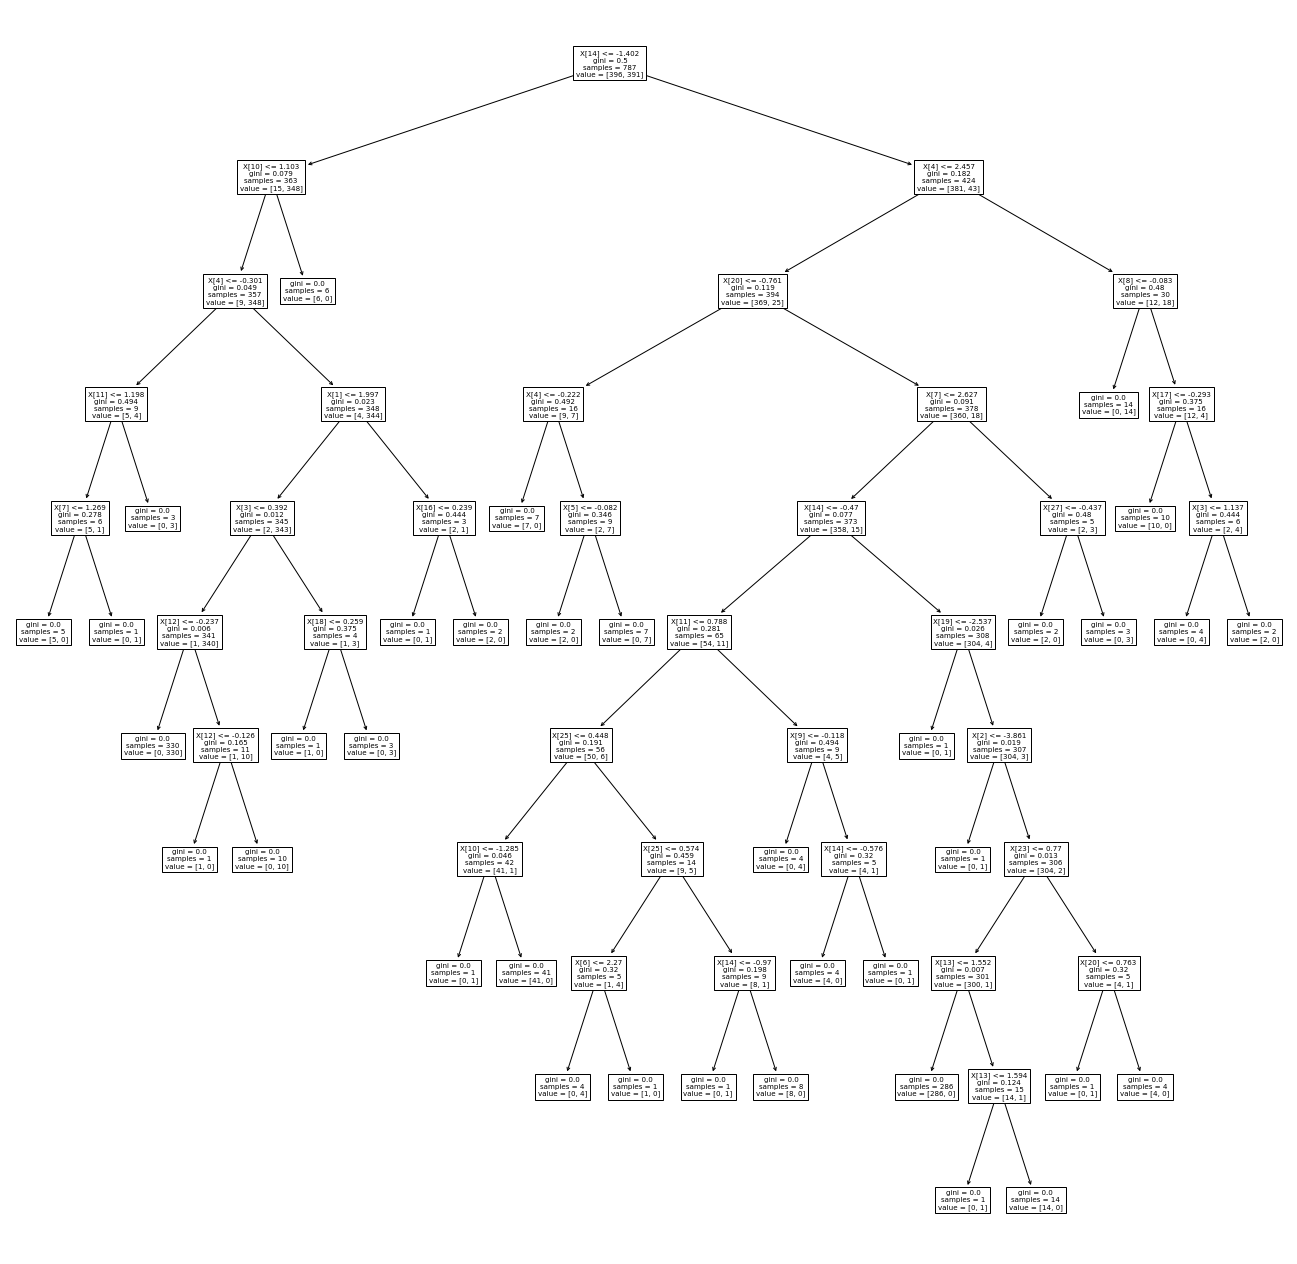

In [101]:
from sklearn import tree
fig_data_dt, ax_data_dt = plt.subplots(1,1,figsize=(23,23))
tree.plot_tree(dt_usample)
plt.show()

<p>Sljedeće ćemo kao i kod logističke regresije pokušati pretražiti polje parametara kako bi vidjeli koji su optimalni. Parametre koji ovdje promatramo su: <ul>
    <li><em>kriterij</em></li> 
    <ul>
        <li><b>Gini</b></li> - kriterij koji koristimo da smanjimo vjerojatnost pogrešnog klasificiranja. $Gini = 1 - \sum_j p_j^2$
        <li><b>Entropija</b></li> kriterij koji koristimo kao mjeru nečistoće podjela. $Entropija = -\sum_j p_j log_2 p_j$
    </ul>
    <li><em>splitter</em></li>
    <ul>
        <li><b>best</b> - model u svakom koraku bira značajku koja je najvažnija</li>  
        <li><b>random</b> - model u svakom koraku slučajno bira značajku, ali pritom pazi na važnost značajki (što je značajka važnija, veća je vjerojatnost da bude izabrana) </li> 
    </ul>
    <li><em>maksimalna dubina</em> - maksimalna dubina koju stablo može doseći (vrijednosti: $1, 2, 3, 4, 5$)</li>
    <li><em>minimalan broj za list</em> - minimalan broj primjera koji smije biti u listu (vrijednosti: $1, 3, 5, 7$)</li>
</ul></p>

In [102]:

criterion_params = ['gini', 'entropy']
splitter_params = ['best', 'random']
max_depth_params = [1, 2, 3, 4, 5]
min_samples_leaf_params = [1, 3, 5, 7]
dt_params = {'criterion': criterion_params, 'splitter': splitter_params, 'max_depth': max_depth_params, 'min_samples_leaf': min_samples_leaf_params}
grid_dt = GridSearchCV(DecisionTreeClassifier(), dt_params)
grid_dt.fit(X_usample_train, y_usample_train)
dt_params_usample = grid_dt.best_estimator_
dt_params_best = grid_dt.best_params_
print('Najbolji parametri: ' + str(dt_params_best))

dt_training_score_params_usample = cross_val_score(dt_params_usample, X_usample_train, y_usample_train, cv=skfold)
print('Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(dt_training_score_params_usample.mean(), 4) * 100) + '%')


Najbolji parametri: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'splitter': 'best'}
Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima): 93.39%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 93.94%
	Recall score: 92.08%
	F1 score: 93.0%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        96
           1       0.94      0.92      0.93       101

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197


----------------------------------------------------------------------------------------------------


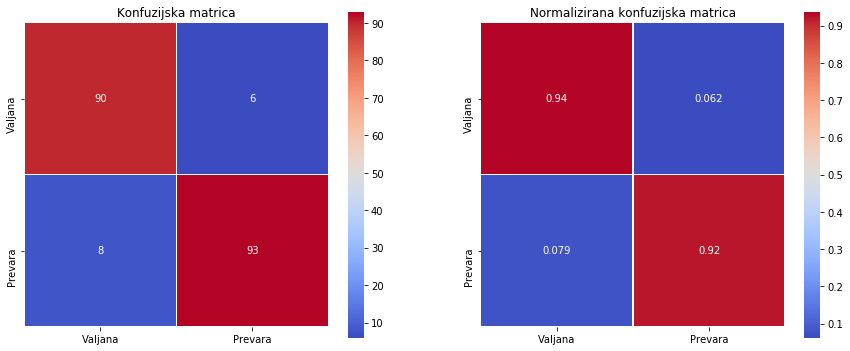

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.94      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.95      0.53     56962
weighted avg       1.00      0.96      0.98     56962


----------------------------------------------------------------------------------------------------


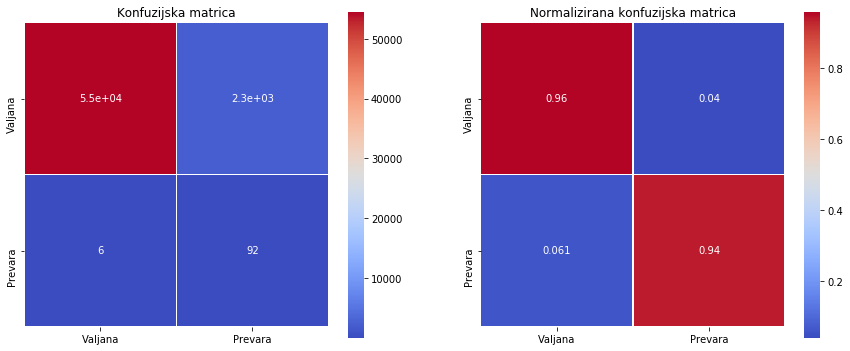

----------------------------------------------------------------------------------------------------


In [103]:
dt_y_pred_usample_params = dt_params_usample.predict(X_usample_test)
#dt_y_score_usample = dt_usample.decision_function(X_usample_test)

dt_y_full_pred_params = dt_params_usample.predict(X_data_test)
print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, dt_y_pred_usample_params)
print()
print('--'*50)
print(classification_report(y_usample_test, dt_y_pred_usample_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, dt_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
print()
print('--'*50)
print(classification_report(y_data_test, dt_y_full_pred_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, dt_y_full_pred_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Vidimo da smo podešavanjem parametara na stablu odluke dobili manje ispravno klasificiranih prevara (92, a bilo je 97), no također smo pogrešno klasificirali 'samo' 2300 valjanih transakcija (prethodno je bilo 6000). Također, pošto smo ograničili dubinu stabla puno bolje možemo grafički prikazati koje se značajke biraju u kojem koraku. <br>
    <b>Napomena</b>: Kao splitter smo dobili da je <i>best</i> najbolji tako da znamo da se u svakom koraku bira najvažnija značajka.</p>

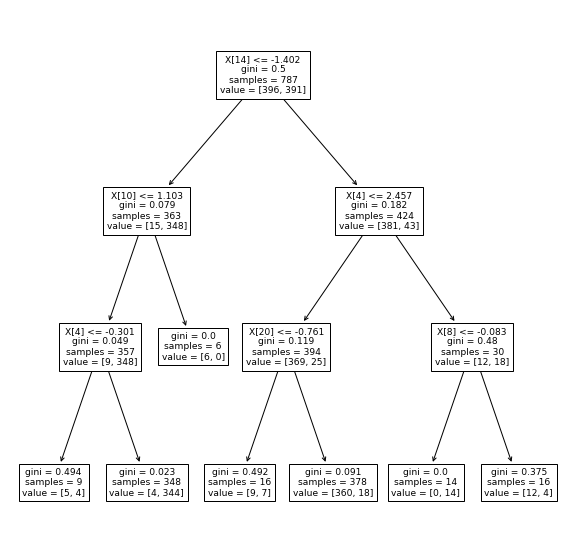

In [105]:
fig_dt, ax_dt = plt.subplots(1,1,figsize=(10,10))
tree.plot_tree(dt_params_usample)
plt.show()

Dalje nastavljamo kao i kod logističke regresije. Odnosno, sad ćemo za treniranje koristiti skup iz kojeg smo prethodno izbacili outliere.

In [107]:
# y_usample_cut_test_non_fraud_num = y_usample_cut_test.value_counts()[0]
# y_usample_cut_test_fraud_num = y_usample_cut_test.value_counts()[1]

grid_dt_cut = GridSearchCV(DecisionTreeClassifier(), dt_params)
grid_dt_cut.fit(X_usample_cut_train, y_usample_cut_train)
dt_params_usample_cut = grid_dt_cut.best_estimator_
dt_params_cut = grid_dt_cut.best_params_
print('Najbolji parametri: ' + str(dt_params_cut))

dt_training_score_params_usample_cut = cross_val_score(dt_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print('Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima, bez outliera): ' 
     + str(round(dt_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'splitter': 'random'}
Rezultat treniranja za stabla odluke nad undersampliranim datasetom (sa parametrima, bez outliera): 91.07%


--------------------------------------------------
Za undersamplirani dataset (sa podešenim parametrima, bez outliera):
	Precision score: 95.6%
	Recall score: 87.88%
	F1 score: 91.58%
----------------------------------------------------------------------------------------------------


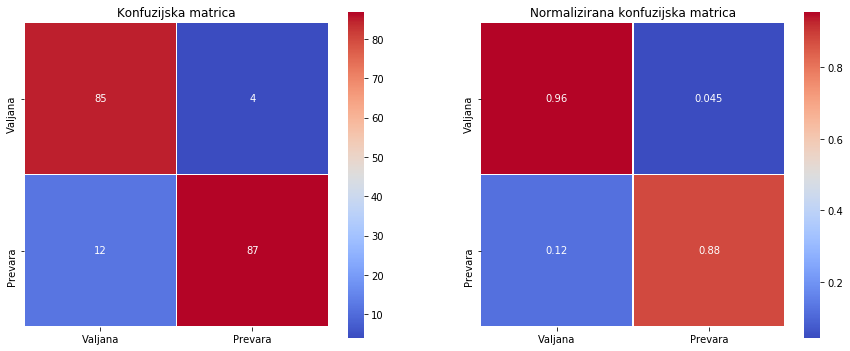

Za cijeli dataset:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.89      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.92      0.52     56962
weighted avg       1.00      0.96      0.98     56962


----------------------------------------------------------------------------------------------------


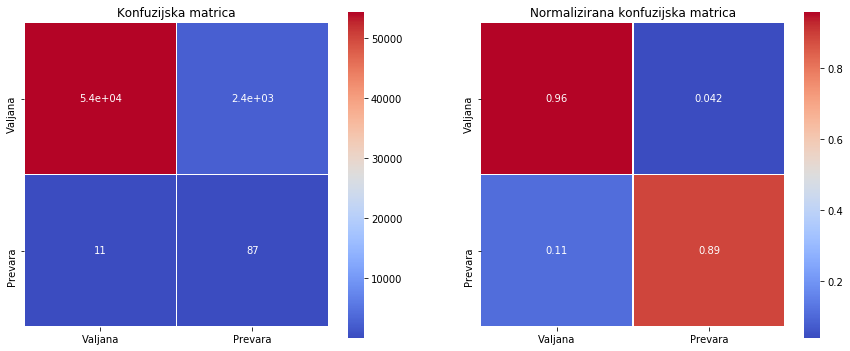

----------------------------------------------------------------------------------------------------


In [108]:
dt_y_pred_usample_params_cut = dt_params_usample_cut.predict(X_usample_cut_test)
dt_y_full_pred_params_cut = dt_params_usample_cut.predict(X_data_test)
print('-'*50)
print('Za undersamplirani dataset (sa podešenim parametrima, bez outliera):')
precision_recall_f1_scores(y_usample_cut_test, dt_y_pred_usample_params_cut)
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, dt_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('Za cijeli dataset:')
print()
print('--'*50)
print(classification_report(y_data_test, dt_y_full_pred_params_cut))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, dt_y_full_pred_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Dobili smo zanimljive rezultate. Imamo manje ispravno klasificiranih prevara (87), ali i više pogrešno klasificiranih valjanih transakcija (2400). Stoga, sa sigurnošću možemo reći da je ovaj model 'lošiji' od prethodnog.</p>

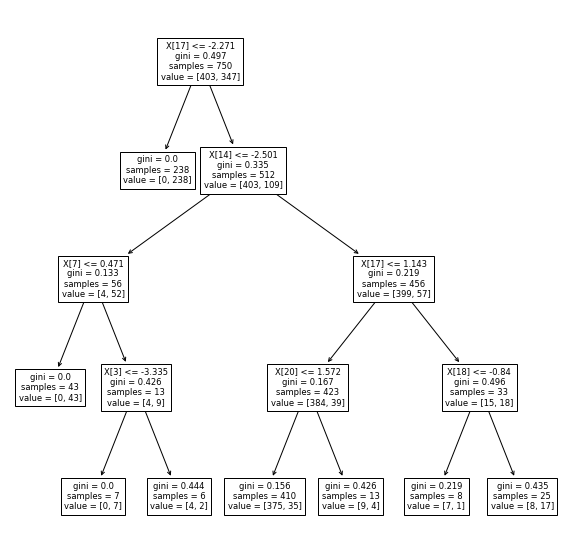

In [109]:
fig_dt_p, ax_dt_p = plt.subplots(1,1,figsize=(10,10))
tree.plot_tree(dt_params_usample_cut)
plt.show()

In [61]:
#mozda i oversampling za decision trees
#uljepsati crtanje stabala
#mozda i nesto s parametrima (+ bagging)

## Bagging

Sljedeći klasifikator koji koristimo zove se BaggingClassifier i kao bazu koristi stablo odluke.

In [68]:
from sklearn.ensemble import BaggingClassifier
bag_data = BaggingClassifier()
bag_data.fit(X_data_train, y_data_train)
bag_data_training_score = cross_val_score(bag_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za bagging klasifikator nad cijelim datasetom: " + 
      str(round(bag_data_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za bagging klasifikator nad cijelim datasetom: 99.95%


----------------------------------------------------------------------------------------------------
Za cijeli dataset:
	Precision score: 95.0%
	Recall score: 77.55%
	F1 score: 85.39%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


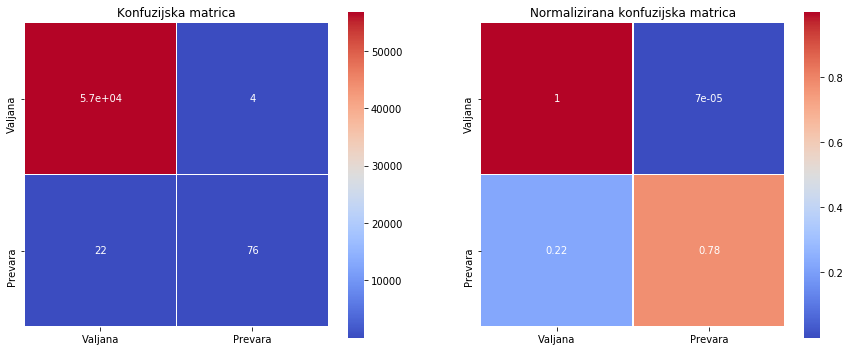

----------------------------------------------------------------------------------------------------


In [69]:
#nad svim podacima test
bag_y_pred_data = bag_data.predict(X_data_test)

print('--'*50)
print('Za cijeli dataset:')
precision_recall_f1_scores(y_data_test, bag_y_pred_data)
print()
print('--'*50)
print(classification_report(y_data_test, bag_y_pred_data))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, bag_y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)


<p>Bagging klasifikator treniran na originalnom skupu podataka je prilično sličan ostalim klasifikatorima treniranim na cijelom trening skupu. Odnosno, model je pogrešno klasificirao 4 valjane transakcije te 22 prevare.</p>

In [70]:
bag_usample = BaggingClassifier()
bag_usample.fit(X_usample_train, y_usample_train)
bag_training_score_usample = cross_val_score(bag_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za bagging nad undersampliranim datasetom: " + 
      str(round(bag_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za bagging nad undersampliranim datasetom: 91.11%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 97.85000000000001%
	Recall score: 91.92%
	F1 score: 94.78999999999999%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        98
           1       0.98      0.92      0.95        99

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197


----------------------------------------------------------------------------------------------------


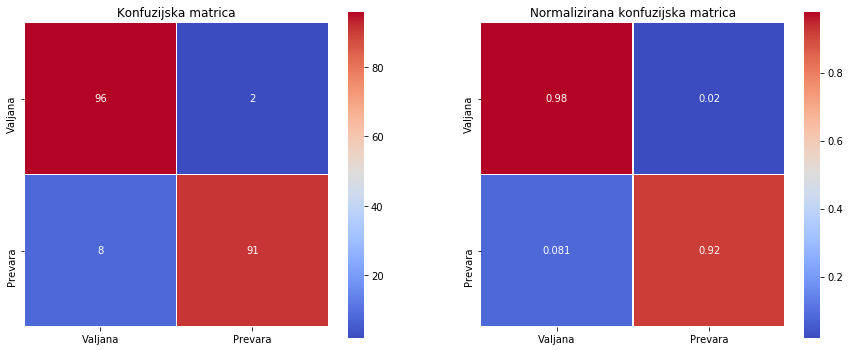

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:
	Precision score: 5.08%
	Recall score: 96.94%
	F1 score: 9.65%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.97      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.97      0.54     56962
weighted avg       1.00      0.97      0.98     56962


----------------------------------------------------------------------------------------------------


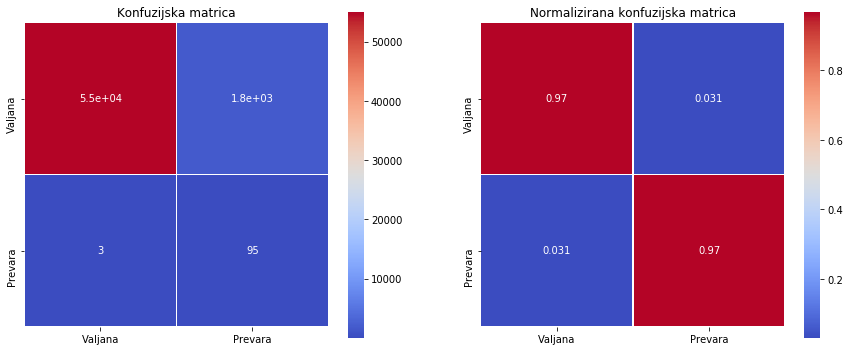

----------------------------------------------------------------------------------------------------


In [71]:
#nad usample test
bag_y_pred_usample = bag_usample.predict(X_usample_test)
bag_y_full_pred = bag_usample.predict(X_data_test)

print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, bag_y_pred_usample)
print()
print('--'*50)
print(classification_report(y_usample_test, bag_y_pred_usample))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, bag_y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
precision_recall_f1_scores(y_data_test, bag_y_full_pred)
print()
print('--'*50)
print(classification_report(y_data_test, bag_y_full_pred))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, bag_y_full_pred), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>
    Zadovoljni smo klasifikacijom prevara (odnosno imamo 95 ispravno klasificiranih). No, problem je što imamo čak 1800 pogrešno klasificiranih valjanih transakcija.
<br>Znači, rezultati koje smo dobili učenjem na undersampliranom skupu podataka su prezentabilni, ali kao i inače pokušat ćemo podesiti parametre pa vidijeti može li bolje. </p>

Parametri koje podešavamo kod bagging klasifikatora su:
<ul>
    <li><em>broj procjenitelja</em> - broj stabala u ansamblu</li>
    <li><em>maksimalan udio podataka</em> - udio koji 'vadimo' iz trening skupa za treniranje svakog procjenitelja</li>
    <li><em>maksimalan udio značajki</em> - udio značajku koje 'vadimo' iz podataka prilikom treniranja (ostale zanemarujemo)</li>
</ul>

In [76]:
#s parametrima

num_estimators_params = [5, 7, 10, 12, 20, 50, 100]
max_samples_params = [0.5, 0.7, 0.9, 1.0]
max_features_params = [0.3, 0.5, 0.7, 0.9, 1.0]
bag_params = {'n_estimators': num_estimators_params, 'max_samples': max_samples_params,
              'max_features': max_features_params}
grid_bag = GridSearchCV(BaggingClassifier(), bag_params)
grid_bag.fit(X_usample_train, y_usample_train)
bag_params_usample = grid_bag.best_estimator_
bag_params_best = grid_bag.best_params_
print('Najbolji parametri: ' + str(bag_params_best))

bag_training_score_params_usample = cross_val_score(bag_params_usample, X_usample_train, y_usample_train, cv=skfold)
print('Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(bag_training_score_params_usample.mean(), 4) * 100) + '%')


Najbolji parametri: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima): 92.25%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 98.92%
	Recall score: 92.93%
	F1 score: 95.83%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        98
           1       0.99      0.93      0.96        99

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197


----------------------------------------------------------------------------------------------------


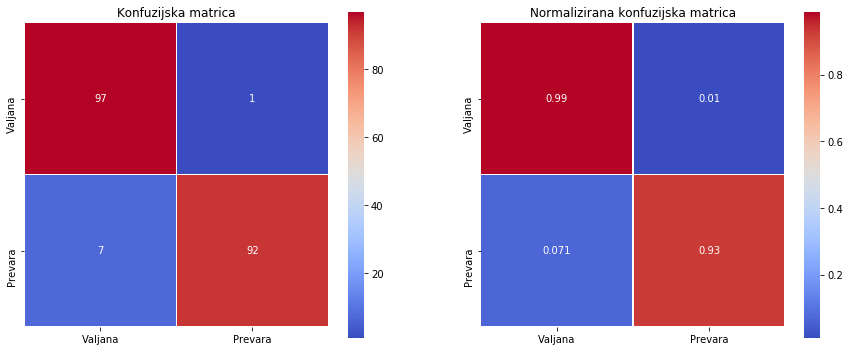

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:
	Precision score: 6.69%
	Recall score: 98.98%
	F1 score: 12.53%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.99      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.98      0.56     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


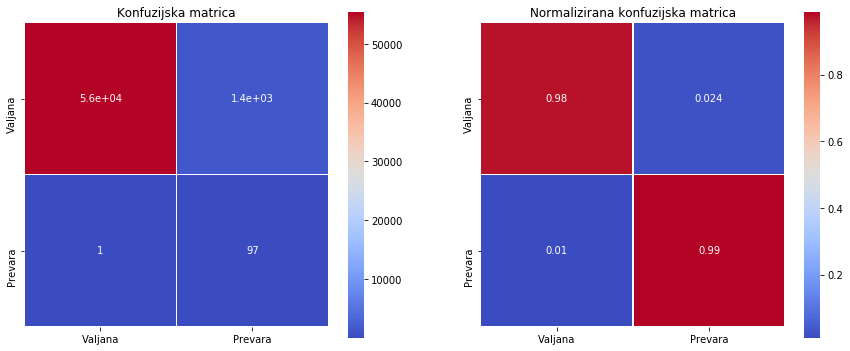

----------------------------------------------------------------------------------------------------


In [77]:
#testiranje
bag_y_pred_usample_params = bag_params_usample.predict(X_usample_test)
bag_y_full_pred_params = bag_params_usample.predict(X_data_test)

print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, bag_y_pred_usample_params)
print()
print('--'*50)
print(classification_report(y_usample_test, bag_y_pred_usample_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, bag_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
precision_recall_f1_scores(y_data_test, bag_y_full_pred_params)
print()
print('--'*50)
print(classification_report(y_data_test, bag_y_full_pred_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, bag_y_full_pred_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Vidimo da je podešavanje parametara pomoglo. Smanjili smo broj pogrešno klasificiranih valjanih transakcija sa 1800 na 1400, dok smo sa 95 ispravno klasificiranih prevara podigli taj broj na 97. Za kraj ćemo trenirati model na skupu bez outliera.</p>

In [78]:
#bez outliera
grid_bag_cut = GridSearchCV(BaggingClassifier(), bag_params)
grid_bag_cut.fit(X_usample_cut_train, y_usample_cut_train)
bag_params_usample_cut = grid_bag_cut.best_estimator_
bag_params_cut = grid_bag_cut.best_params_
print('Najbolji parametri: ' + str(bag_params_cut))

bag_training_score_params_usample_cut = cross_val_score(bag_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print('Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima, bez outliera): ' 
     + str(round(bag_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'max_features': 0.3, 'max_samples': 0.7, 'n_estimators': 7}
Rezultat treniranja za bagging klasifikator nad undersampliranim datasetom (sa parametrima, bez outliera): 92.78%


--------------------------------------------------
Za undersamplirani dataset (sa podešenim parametrima, bez outliera):
	Precision score: 93.97999999999999%
	Recall score: 87.64%
	F1 score: 90.7%
----------------------------------------------------------------------------------------------------


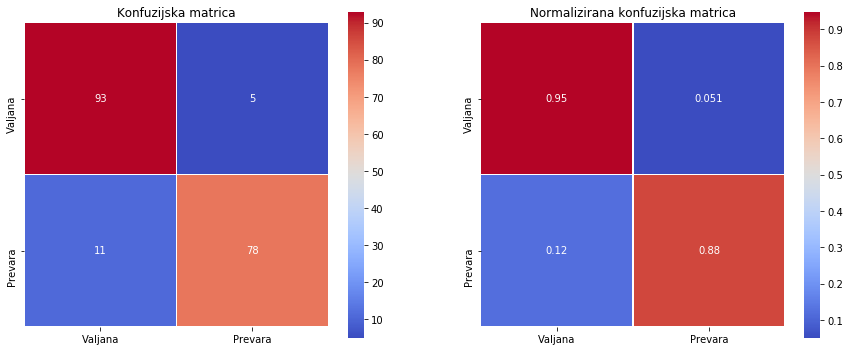

Za cijeli dataset:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.93      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.95      0.53     56962
weighted avg       1.00      0.96      0.98     56962


----------------------------------------------------------------------------------------------------


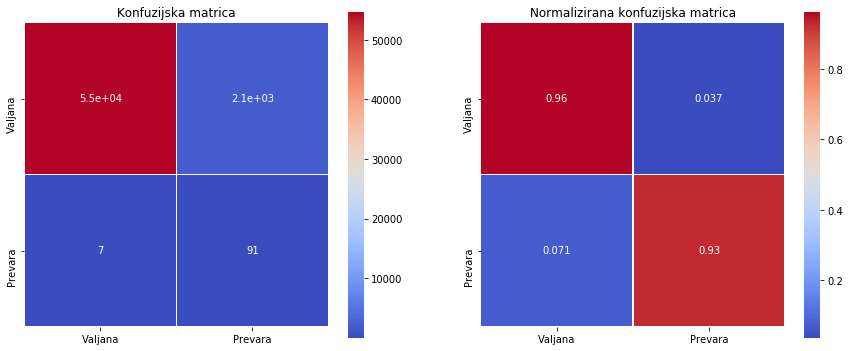

----------------------------------------------------------------------------------------------------


In [79]:
bag_y_pred_usample_params_cut = bag_params_usample_cut.predict(X_usample_cut_test)
bag_y_full_pred_params_cut = bag_params_usample_cut.predict(X_data_test)
print('-'*50)
print('Za undersamplirani dataset (sa podešenim parametrima, bez outliera):')
precision_recall_f1_scores(y_usample_cut_test, bag_y_pred_usample_params_cut)
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, bag_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('Za cijeli dataset:')
print()
print('--'*50)
print(classification_report(y_data_test, bag_y_full_pred_params_cut))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, bag_y_full_pred_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Treniranje na skupu bez outliera nije pomoglo. Broj pogrešno klasificiranih valjanih transakcija je skočio na 2100, dok je i broj ispravno klasificiranih prevara pao na 91. Razlog tome može biti i što model koristi samo 30% svih značajki, te 70% svih podataka trening skupa za trening.</p>

## Slučajne šume

<p>Sljedeći algoritam koji promatramo zove se slučajnim šumama. Prednost slučajnih šuma nad stablima odluke je to što kod slučajnih šuma uglavnom nema overfittinga. <br> Kao i kod prethodnih algoritama prvo ćemo koristiti cijeli skup za učenje i trening.</p>

In [89]:
#random forest 

In [62]:
#vrlo, vrlo sporo, skoro neizvedivo
#mozda ubaciti stopericu, pa usporedivat, ali ovo se mozda nikad nit ne izvrsi
rf_data = RandomForestClassifier()
rf_data.fit(X_data_train, y_data_train)
rf_data_training_score = cross_val_score(rf_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za slučajne šume nad cijelim datasetom: " + 
      str(round(rf_data_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za slučajne šume nad cijelim datasetom: 99.95%


<p><b>Napomena</b>: Velika mana slučajnih šuma je vrijeme potrebno za treniranje. Odnosno, slučajne šume su puno sporiji algoritam od logističke regresije.</p>

----------------------------------------------------------------------------------------------------
Za cijeli dataset:
	Precision score: 97.44%
	Recall score: 77.55%
	F1 score: 86.36%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


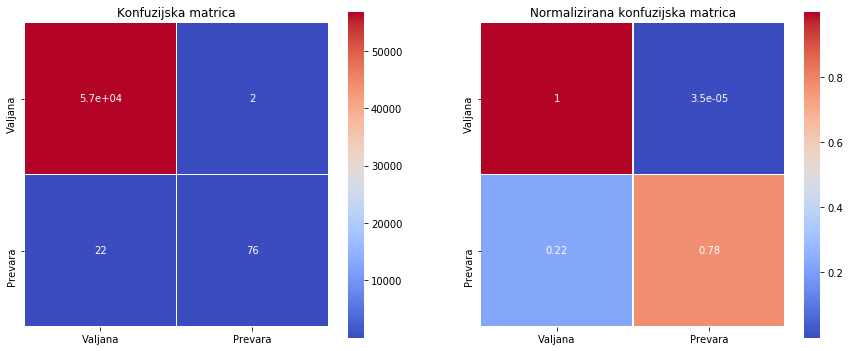

----------------------------------------------------------------------------------------------------


In [63]:
#nad svim podacima test
rf_y_pred_data = rf_data.predict(X_data_test)
#dt_y_score_data = dt_data.decision_function(X_data_test)

print('--'*50)
print('Za cijeli dataset:')
precision_recall_f1_scores(y_data_test, rf_y_pred_data)
print()
print('--'*50)
print(classification_report(y_data_test, rf_y_pred_data))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, rf_y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)
#plot_roc_auc_curve(y_data_test, dt_y_score_data)
#plot_precision_recall_curve(y_data_test, dt_y_score_data)

<p>Prokomentirajmo ukratko dobivene rezultate. Prednost ovog klasifikatora je što radi jako malo pogrešaka (24 ukupno, pri čemu su samo 2 valjane transakcije klasificirane kao prevare), što je najbolji rezultat od svih klasifikatora dosad. Doduše, ovaj model je čak 22 prevare klasificirao kao valjane transakcije (što je skoro četvrtina svih prevara). To bi značilo da bismo ulovili samo 3 od 4 prevaranta, dok bi se 1 izvukao (što i nije jako dobro).</p>

<p>Kao i prije, sada ćemo koristiti skup podataka koji smo dobili undersamplingom. Prednost undersamplinga je što dobijamo manji skup podataka, pa u ovom slučaju učenje neće biti toliko dugotrajno.</p>

In [64]:
rf_usample = RandomForestClassifier()
rf_usample.fit(X_usample_train, y_usample_train)
rf_training_score_usample = cross_val_score(rf_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za slučajne šume nad undersampliranim datasetom: " + 
      str(round(rf_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za slučajne šume nad undersampliranim datasetom: 93.77%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 96.84%
	Recall score: 90.2%
	F1 score: 93.4%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.97      0.90      0.93       102

    accuracy                           0.93       197
   macro avg       0.94      0.94      0.93       197
weighted avg       0.94      0.93      0.93       197


----------------------------------------------------------------------------------------------------


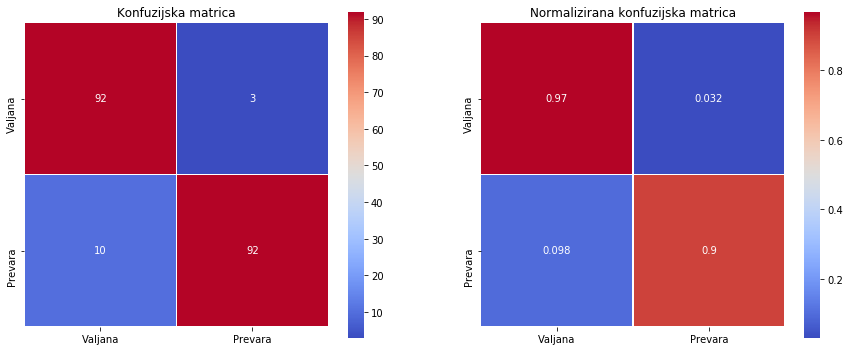

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:
	Precision score: 7.9%
	Recall score: 97.96000000000001%
	F1 score: 14.62%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.98      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.98      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


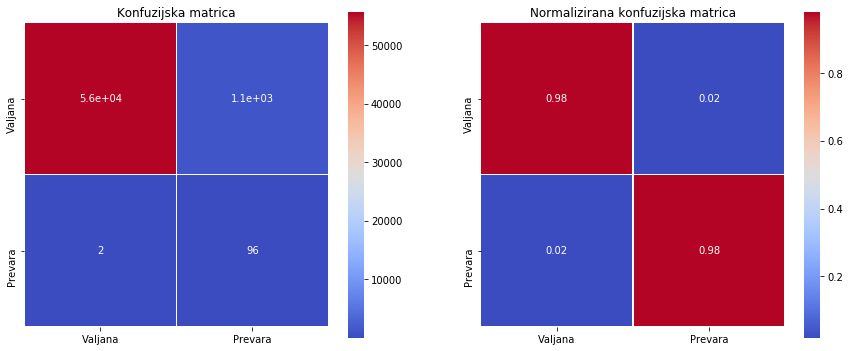

----------------------------------------------------------------------------------------------------


In [70]:
#nad usample test
rf_y_pred_usample = rf_usample.predict(X_usample_test)
#dt_y_score_usample = dt_usample.decision_function(X_usample_test)

rf_y_full_pred = rf_usample.predict(X_data_test)
print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, rf_y_pred_usample)
print()
print('--'*50)
print(classification_report(y_usample_test, rf_y_pred_usample))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, rf_y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
precision_recall_f1_scores(y_data_test, rf_y_full_pred)
print()
print('--'*50)
print(classification_report(y_data_test, rf_y_full_pred))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, rf_y_full_pred), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Kao i ranije zanemarujemo testiranje na undersampliranom skupu. Tako da najbolje da odmah provjerimo rezultate testiranja na cijelom testnom skupu. Vidimo da su samo 2 prevare pogrešno klasificirane kao valjane transakcije (što je jako dobro). Također imamo samo 1100 valjanih transakcija koje su pogrešno klasificirane (kao prevare) što je bolje od većine drugih klasifikatora. Dakle, možemo reći da je učenje korištenjem slučajnih šuma prilično uspješno.</p>

<p>Sljedeće ćemo uvesti parametre kako bi potencijalno još poboljšali prethodno dobivene rezultate.</p>
Parametri koje promatramo kod slučajnih šuma:
    <ul>
    <li><em>kriterij</em> - poprima vrijednosti <i>gini</i> ili <i>entropy</i> koji imaju isto značenje kao i kod stabala odluke</li>
    <li><em>broj stabala</em> - određuje broj stabala u slučajnoj šumi (5, 10, 50, 100)</li>
    <li><em>maksimalna dubina</em> - određuje maksimalnu dubinu svakog stabla u šumi (1, 2, 3, 4, 5)</li>
    <li><em>minimalan broj za list</em> - određuje koliko primjera najmanje može biti u listu (1, 3, 5, 7)</li>
    <li><em>težina klase</em> - težine koje pridajemo klasama (valjanim i prevarama)
        <ul><li><b>balanced</b> - podešava težine tako da uzima broj pojavljivanja klasa u ulaznim podacima</li>
            <li><b>balanced_subsample</b> - isto kao i balanced, samo što su težine bazirane na bootstrap primjerku svakog stabla koje gradimo</li>
        </ul>
    </li> 
    </ul>

In [68]:
#s parametrima

criterion_params = ['gini', 'entropy']
num_estimators_params = [5, 10, 50, 100]
max_depth_params = [1, 2, 3, 4, 5]
min_samples_leaf_params = [1, 3, 5, 7]
class_weight_params = ['balanced', 'balanced_subsample']
rf_params = {'criterion': criterion_params, 'n_estimators': num_estimators_params, 'max_depth': max_depth_params,
             'min_samples_leaf': min_samples_leaf_params, 'class_weight': class_weight_params}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_usample_train, y_usample_train)
rf_params_usample = grid_rf.best_estimator_
rf_params_best = grid_rf.best_params_
print('Najbolji parametri: ' + str(rf_params_best))

rf_training_score_params_usample = cross_val_score(rf_params_usample, X_usample_train, y_usample_train, cv=skfold)
print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(rf_training_score_params_usample.mean(), 4) * 100) + '%')


Najbolji parametri: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}
Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima): 93.01%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 95.78999999999999%
	Recall score: 89.22%
	F1 score: 92.39%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.96      0.89      0.92       102

    accuracy                           0.92       197
   macro avg       0.93      0.93      0.92       197
weighted avg       0.93      0.92      0.92       197


----------------------------------------------------------------------------------------------------


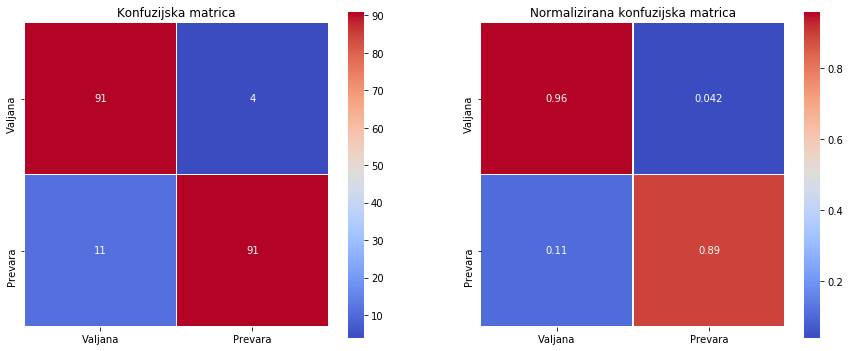

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:
	Precision score: 8.23%
	Recall score: 90.82000000000001%
	F1 score: 15.1%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.91      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


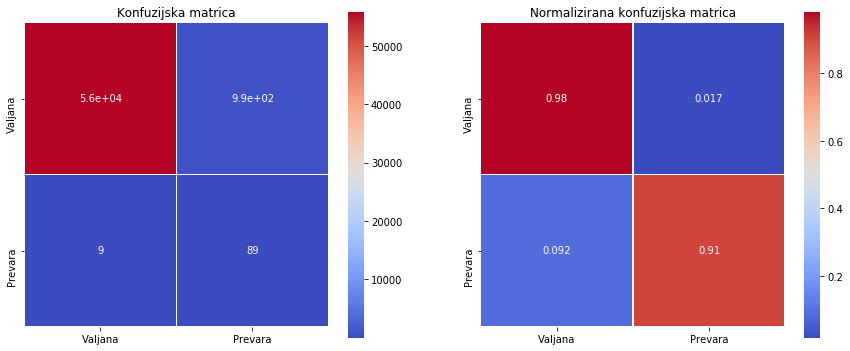

----------------------------------------------------------------------------------------------------


In [71]:
#testiranje
rf_y_pred_usample_params = rf_params_usample.predict(X_usample_test)

rf_y_full_pred_params = rf_params_usample.predict(X_data_test)
print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, rf_y_pred_usample_params)
print()
print('--'*50)
print(classification_report(y_usample_test, rf_y_pred_usample_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, rf_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
precision_recall_f1_scores(y_data_test, rf_y_full_pred_params)
print()
print('--'*50)
print(classification_report(y_data_test, rf_y_full_pred_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, rf_y_full_pred_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Vidimo da je podešavanje parametara smanjilo broj ispravno klasificiranih prevara (što je problem). Jedina prednost je što smo dobili manje pogrešno klasificiranih valjanih transakcija. <br> Pokušat ćemo upotrijebiti isti postupak nakon što maknemo outliere da vidimo hoće li se poboljšati.</p>

In [72]:
#bez outliera
grid_rf_cut = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf_cut.fit(X_usample_cut_train, y_usample_cut_train)
rf_params_usample_cut = grid_rf_cut.best_estimator_
rf_params_cut = grid_rf_cut.best_params_
print('Najbolji parametri: ' + str(rf_params_cut))

rf_training_score_params_usample_cut = cross_val_score(rf_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print('Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima, bez outliera): ' 
     + str(round(rf_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Rezultat treniranja za slučajne šume nad undersampliranim datasetom (sa parametrima, bez outliera): 93.31%


--------------------------------------------------
Za undersamplirani dataset (sa podešenim parametrima, bez outliera):
	Precision score: 98.77%
	Recall score: 85.11%
	F1 score: 91.43%
----------------------------------------------------------------------------------------------------


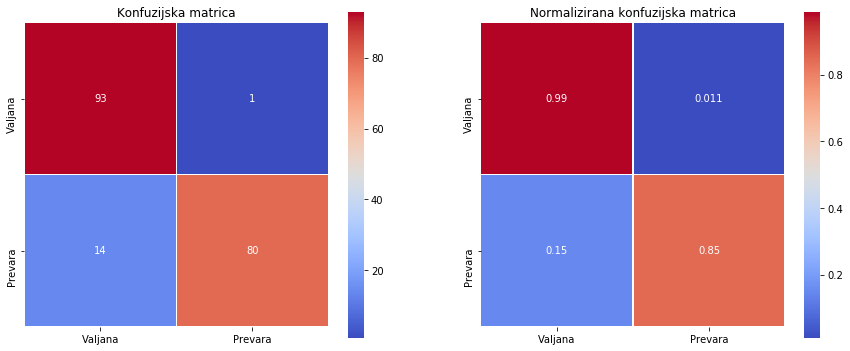

Za cijeli dataset:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.94      0.20        98

    accuracy                           0.99     56962
   macro avg       0.55      0.96      0.59     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


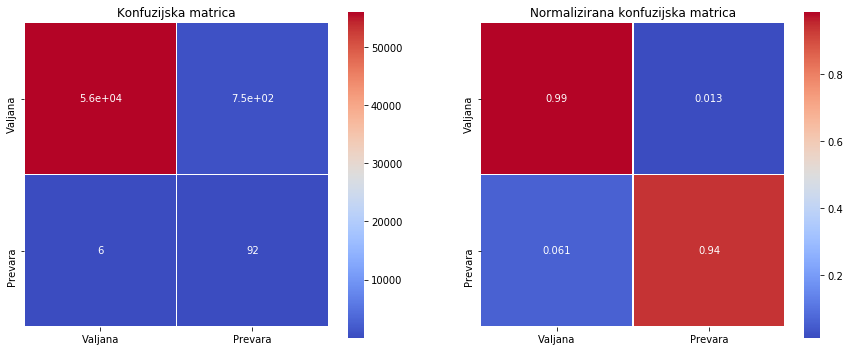

----------------------------------------------------------------------------------------------------


In [73]:
rf_y_pred_usample_params_cut = rf_params_usample_cut.predict(X_usample_cut_test)
rf_y_full_pred_params_cut = rf_params_usample_cut.predict(X_data_test)
print('-'*50)
print('Za undersamplirani dataset (sa podešenim parametrima, bez outliera):')
precision_recall_f1_scores(y_usample_cut_test, rf_y_pred_usample_params_cut)
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, rf_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('Za cijeli dataset:')
print()
print('--'*50)
print(classification_report(y_data_test, rf_y_full_pred_params_cut))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, rf_y_full_pred_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Vidimo da je micanje outliera pomoglo čak u oba slučaja. Odnosno, ovim smo modelom uspjeli ispravno klasificirati čak 92 prevare (bilo je 89), te smo samo 750 valjanih transakcija klasificirali kao prevare (bilo je 990).</p>

In [74]:
rf_params_cut['n_estimators']

50

<p>Sada možemo prikazati kako izgleda jedno slučajno odabrano stablo naše slučajne šume.</p>

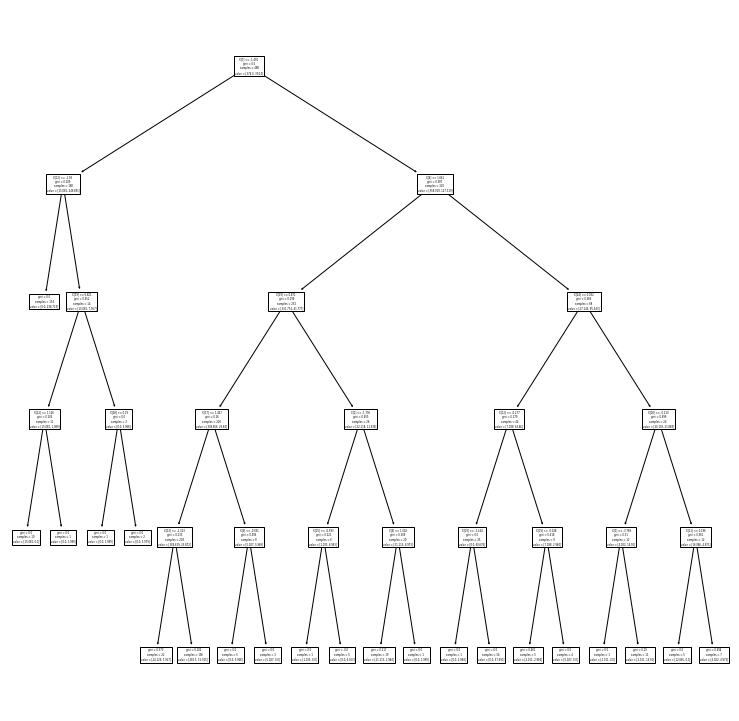

In [75]:
from sklearn import tree
import random
fig_rf_p, ax_rf_p = plt.subplots(1,1,figsize=(13,13))
tree.plot_tree(rf_params_usample_cut[random.randint(0, rf_params_cut['n_estimators']-1)])
plt.show()

<p>Pošto smo korištenjem slučajnih šuma dobili jako dobre rezultate treniranjem na skupu podataka dobivenim undersamplingom, onda ćemo pokušati iskoristiti i drugu sampling tehniku s kojom smo se ranije susreli. To je tehnika oversamplinga zvana SMOTE.</p> 

In [77]:
# #smote rf
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(sampling_strategy='minority', random_state=42)
# X_smote, y_smote = smote.fit_sample(X, y)

# X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote,y_smote,test_size=0.20,random_state=42)
# y_smote_test_non_fraud_num = y_data_test.value_counts()[0]
# y_smote_test_fraud_num = y_data_test.value_counts()[1]
# train_num = len(X_smote_train)
# test_num = len(X_smote_test)
# print("Broj podataka u trening skupu nakon SMOTE-a: " + str(train_num))
# print("Broj podataka u testnom skupu nakon SMOTE-a: " + str(test_num))
# print("Ukupan broj podataka nakon SMOTE-a: " + str(train_num+test_num))

In [78]:
#smote rf
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_smote_train, y_smote_train = smote.fit_sample(X_data_train, y_data_train)

train_num = len(X_smote_train)
print("Broj podataka u trening skupu nakon SMOTE-a: " + str(train_num))

Broj podataka u trening skupu nakon SMOTE-a: 454902


<p>Kao i prije, oversampling vršimo samo na podacima za trening. Sada ćemo te podatke ubaciti u klasifikator.</p>

In [79]:
rf_smote = RandomForestClassifier()
rf_smote.fit(X_smote_train, y_smote_train)
rf_training_score_smote = cross_val_score(rf_smote, X_smote_train, y_smote_train, cv=skfold)
print("Rezultat treniranja za slučajne šume nad SMOTE datasetom: " + 
      str(round(rf_training_score_smote.mean(), 4) * 100) + '%')

Rezultat treniranja za slučajne šume nad SMOTE datasetom: 99.99%


<p>Prokomentirajmo sada rezultate treniranja i testiranja za ovaj model koji je uz slučajne šume koristio SMOTE-oversampling tehniku. Što se tiče rezultata treniranja, oni su jako visoki (99.99%), čime bi mogli naslutiti da se radi o overfittingu, ali slučajne šume su tip algoritma koji je napravljen kako ne bi dolazilo do overfittinga. Pogledajmo sada jesu li rezultati treniranja prilično lošiji ili su također vrlo dobri. <br>
    <b>Napomena</b>: Treniranje nakon SMOTE-a je užasno dugotrajno ako koristimo slučajne šume.</p>

In [80]:
# rf_y_pred_smote = rf_smote.predict(X_smote_test)
# rf_y_full_pred_smote = rf_smote.predict(X_data_test)
# print('--'*50)
# print('Testiranje na SMOTE datasetu:')
# precision_recall_f1_scores(y_smote_test, rf_y_pred_smote)
# print()
# print('--'*50)
# print(classification_report(y_smote_test, rf_y_pred_smote))
# print()
# print('--'*50)
# plot_confusion_matrix(confusion_matrix(y_smote_test, rf_y_pred_smote), y_smote_test_non_fraud_num, y_smote_test_fraud_num)
# print('-'*100)
# print('*'*100)
# print('-'*100)
# print('Testiranje na originalnom datasetu:')
# print()
# print('--'*50)
# print(classification_report(y_data_test, rf_y_full_pred_smote))
# print()
# print('--'*50)
# plot_confusion_matrix(confusion_matrix(y_data_test, rf_y_full_pred_smote), y_data_test_non_fraud_num, y_data_test_fraud_num)
# print('-'*100)

Testiranje na originalnom datasetu:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.85      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


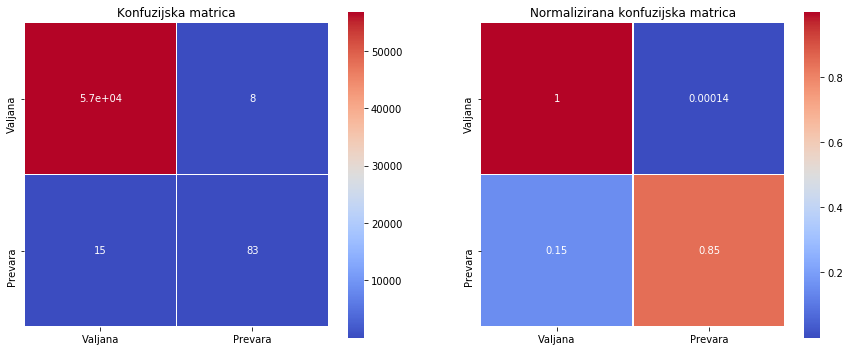

----------------------------------------------------------------------------------------------------


In [81]:

rf_y_full_pred_smote = rf_smote.predict(X_data_test)
print('Testiranje na originalnom datasetu:')
print()
print('--'*50)
print(classification_report(y_data_test, rf_y_full_pred_smote))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, rf_y_full_pred_smote), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Rezultati testiranja su također jako dobri. Imamo malo više pogrešno klasificiranih prevara (15), ali i manje pogrešno klasificiranih valjanih transakcija (8), čime smo dobili bolji model nego da smo učili na originalnom skupu za trening. Sada ćemo pokušati iskoristiti i BorderlineSMOTE, te ADASYN (kao i kod logističke regresije).</p>

In [84]:

border_smote_rf = RandomForestClassifier()
border_smote_rf.fit(X_border_smote_train, y_border_smote_train)


rf_border_smote_training_score = cross_val_score(border_smote_rf, X_border_smote_train, y_border_smote_train, cv=skfold)
print('Rezultat treniranja za slučajne šume nad BorderlineSMOTE datasetom: ' 
     + str(round(rf_border_smote_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za slučajne šume nad BorderlineSMOTE datasetom: 99.98%


<p>Vidimo da su rezultati treniranja minimalno lošiji (99.98%) u odnosu na prošli model. Provjerimo sada na skupu za testiranje.</p>

----------------------------------------------------------------------------------------------------
Predikcija za originalni dataset:
	Precision score: 95.24000000000001%
	Recall score: 81.63%
	F1 score: 87.91%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.82      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


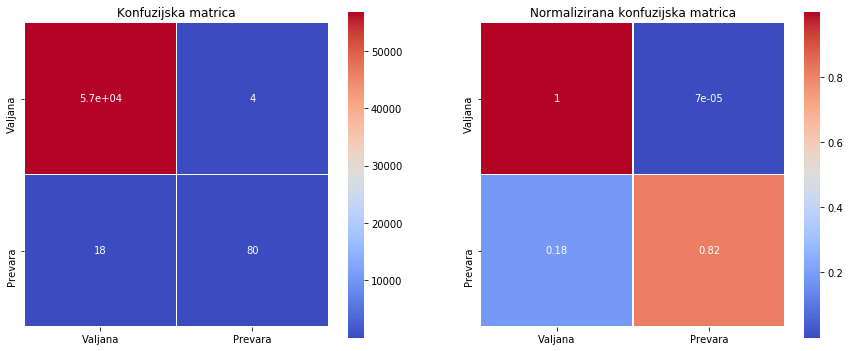

----------------------------------------------------------------------------------------------------


In [85]:
full_pred_border_smote_rf = border_smote_rf.predict(X_data_test)

print('-'*100)
print('Predikcija za originalni dataset:')
precision_recall_f1_scores(y_data_test, full_pred_border_smote_rf)
print()
print('-'*100)
print(classification_report(y_data_test, full_pred_border_smote_rf))
print()
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_border_smote_rf), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)


<p>Testiranjem smo dobili nešto lošije rezultate nego na prošlom modelu. Imamo samo 4 pogrešno klasificirane valjane transakcije (prošli model je imao 8), ali imamo i 18 pogrešno klasificirnih prevara (prošli model je imao 15). Iako ukupno imamo manje promašaja, moramo uzeti u obzir da je bolje valjanu transakciju proglasiti prevarom nego obratno. Stoga možemo reći da je ovaj model i dalje bolji od prvog modela koji smo trenirali na originalnom skupu podataka.</p>

In [89]:

adasyn_rf = LogisticRegression(solver='liblinear')
adasyn_rf.fit(X_adasyn_train, y_adasyn_train)

rf_adasyn_training_score = cross_val_score(adasyn_rf, X_adasyn_train, y_adasyn_train, cv=skfold)
print('Rezultat treniranja za slučajne šume nad ADASYN datasetom: ' 
     + str(round(rf_adasyn_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za slučajne šume nad ADASYN datasetom: 89.74%


----------------------------------------------------------------------------------------------------
Predikcija za cijeli dataset:
	Precision score: 1.69%
	Recall score: 94.89999999999999%
	F1 score: 3.3300000000000005%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.95      0.03        98

    accuracy                           0.91     56962
   macro avg       0.51      0.93      0.49     56962
weighted avg       1.00      0.91      0.95     56962


----------------------------------------------------------------------------------------------------


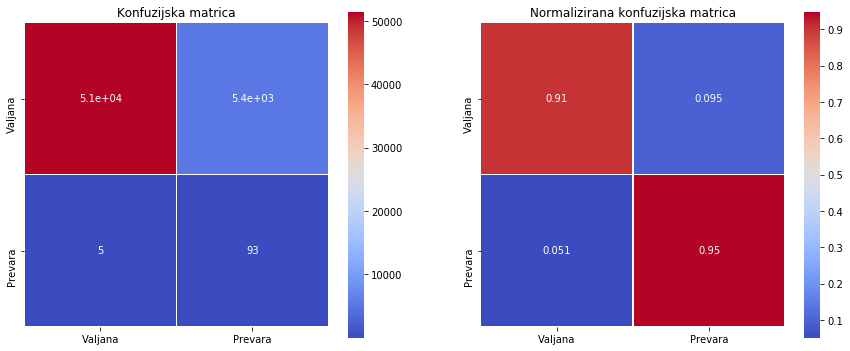

In [90]:
full_pred_adasyn_rf = adasyn_rf.predict(X_data_test)

print('-'*100)
print('Predikcija za cijeli dataset:')
precision_recall_f1_scores(y_data_test, full_pred_adasyn_rf)
print()
print('-'*100)
print(classification_report(y_data_test, full_pred_adasyn_rf))
print()
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_data_test, full_pred_adasyn_rf), y_data_test_non_fraud_num, y_data_test_fraud_num)


<p>Ovaj model daje poprilično različite rezultate od prethodna 2. Vidimo da ima dosta pogrešno klasificiranih valjanih transakcija (čak 5400), ali i samo 5 pogrešno klasificiranih prevara. Zaključujemo da ovo i nije najbolji pokušaj.</p>

## Algoritam najbližih susjeda

<p>Sljedeći algoritam koji promatramo je algoritam najbližih susjeda (standardno gledamo 5-najbližih susjeda). Kao i kod dosadašnjih algoritama prvo ćemo pokušati sa treningom na originalnom skupu podataka, a kasnije ćemo upotrijebiti i undersampling te micanje outliera.</p>

In [76]:
#k-nearest neighbors


In [91]:
#na cijelom datasetu
knn_data = KNeighborsClassifier()
knn_data.fit(X_data_train, y_data_train)
knn_data_training_score = cross_val_score(knn_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za k (defaultno = 5) najbližih susjeda nad cijelim datasetom: " + 
      str(round(knn_data_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za k (defaultno = 5) najbližih susjeda nad cijelim datasetom: 99.94%


----------------------------------------------------------------------------------------------------
Za cijeli dataset:
	Precision score: 93.83%
	Recall score: 77.55%
	F1 score: 84.92%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.78      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


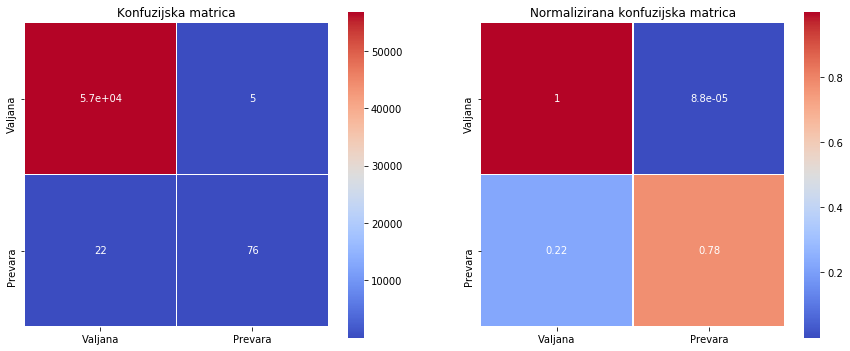

----------------------------------------------------------------------------------------------------


In [92]:
#cak je i ovo dugotrajno
knn_y_pred_data = knn_data.predict(X_data_test)

print('--'*50)
print('Za cijeli dataset:')
precision_recall_f1_scores(y_data_test, knn_y_pred_data)
print()
print('--'*50)
print(classification_report(y_data_test, knn_y_pred_data))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, knn_y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p> Prvo što zapažamo kod algoritma najbližih susjeda je da je i treniranje i testiranje dugotrajno. Od treniranja na tako velikom skupu podataka i očekujemo da bude dugo tako da to nije ništa neuobičajeno. S druge strane testiranje je dugo jer u svakom koraku algoritam računa udaljenosti od okolnih primjera i onda bira one koje su najkraće (za što je potrebno dosta vremena). <br>
Prokomentirajmo sad rezultate koje smo dobili. Vidimo da su trening rezultati jako visoki (kao i kod većine modela). Što se tiče rezultata testiranja vidimo da je model pogrešno klasificirao samo 5 valjanih transakcija (što je dosta dobro), međutim model je također pogrešno klasificirao čak 22 prevare (što je gotovo četvrtina).   
</p>

In [94]:
#usample
knn_usample = KNeighborsClassifier()
knn_usample.fit(X_usample_train, y_usample_train)
knn_training_score_usample = cross_val_score(knn_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za k (5) najbližih susjeda nad undersampliranim datasetom: " + 
      str(round(knn_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za k (5) najbližih susjeda nad undersampliranim datasetom: 93.26%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 97.87%
	Recall score: 90.2%
	F1 score: 93.88%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        95
           1       0.98      0.90      0.94       102

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197


----------------------------------------------------------------------------------------------------


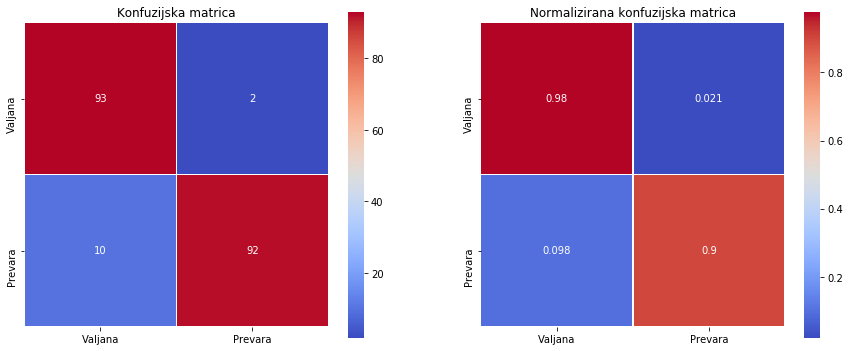

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.92      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


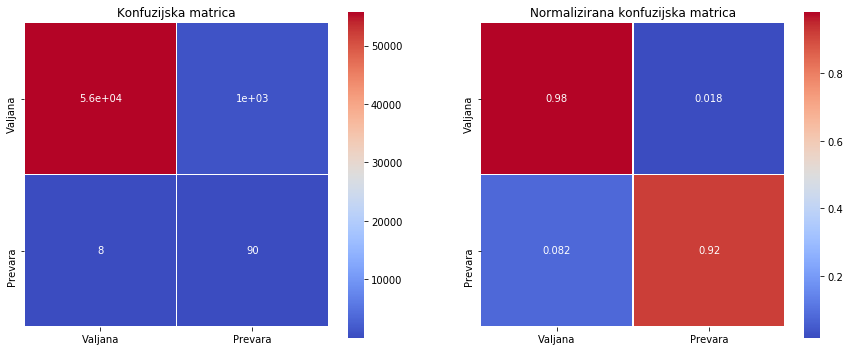

----------------------------------------------------------------------------------------------------


In [95]:
#nad usample test
knn_y_pred_usample = knn_usample.predict(X_usample_test)

knn_y_full_pred = knn_usample.predict(X_data_test)
print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, knn_y_pred_usample)
print()
print('--'*50)
print(classification_report(y_usample_test, knn_y_pred_usample))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, knn_y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
print()
print('--'*50)
print(classification_report(y_data_test, knn_y_full_pred))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, knn_y_full_pred), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)




<p>Što se tiče rezulatata koji smo dobili modelom koji je treniran na undersampliranom skupu podataka, oni su poprilično dobri.
Vidimo da je  pogrešno klasificirano 1000 valjanih transakcija (od čega smo sigurno imali dosta lošije rezultate), ali i samo 8 pogrešno klasificiranih prevara (što je dosta dobro).</p>

<p>Kao i kod prethodnih algoritama pokušavamo poboljšati model podešavanjem parametara. U slučaju algoritma najbližih susjeda podešavamo sljedeće parametre:</p>
<ul>
    <li><em>broj najbližih susjeda</em> - određuje koliko najbližih susjeda 'glasa' prilikom klasifikacije novog primjerka (koristimo: 1, 2, 3, 4, 5)</li>
    <li><em>algoritam</em> - određuje koji algoritam koristimo da bi dobili najbliže susjede
        <ul>
            <li><i>Ball Tree</i> - dijeli primjerke podataka u ugniježđene skupove hipersfera (koje zovemo loptama)</li>
            <li><i>KD Tree</i> - dijeli primjerke podataka u k-dimenzionalne kocke</li>
            <li><i>Brute</i> - koristi klaičan pristup grubom silom </li>
            <li><i>Auto</i> - automatski pokušava utvrditi koji je najprikladniji algoritam na temelju podataka koje prima fit metoda </li>
        </ul>
    </li>
    <li><em>p (power)</em> - biramo koji algoritam udaljenosti koristimo
        <ul>
            <li><i>1</i> - koristi manhattan udaljenost, formulom: $d_1(p,q) = \sum_{i=1}^n \mid p_i - q_i \mid$</li>
            <li><i>2</i> - koristi euklidsku udaljenost, formulom: $d_2(p,q) = \sqrt{\sum_{i=1}^n (p_i - q_i)^2}$</li>
        </ul>
    </li>
</ul>

In [96]:
#s parametrima

num_neighbors_params = [1, 2, 3, 4, 5]
alg_params = ['auto', 'brute', 'ball_tree', 'kd_tree']
p_params = [1, 2]

knn_params = {'n_neighbors': num_neighbors_params, 'algorithm': alg_params, 'p': p_params, 'metric': ['minkowski']}
grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn.fit(X_usample_train, y_usample_train)
knn_params_usample = grid_knn.best_estimator_
knn_params_best = grid_knn.best_params_
print('Najbolji parametri: ' + str(knn_params_best))

knn_training_score_params_usample = cross_val_score(knn_params_usample, X_usample_train, y_usample_train, cv=skfold)
print('Rezultat treniranja za k (' +  str(knn_params_best['n_neighbors']) + 
      ')  najbližih susjeda nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(knn_training_score_params_usample.mean(), 4) * 100) + '%')


Najbolji parametri: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 2, 'p': 2}
Rezultat treniranja za k (2)  najbližih susjeda nad undersampliranim datasetom (sa parametrima): 93.77%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 98.9%
	Recall score: 88.24%
	F1 score: 93.26%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        95
           1       0.99      0.88      0.93       102

    accuracy                           0.93       197
   macro avg       0.94      0.94      0.93       197
weighted avg       0.94      0.93      0.93       197


----------------------------------------------------------------------------------------------------


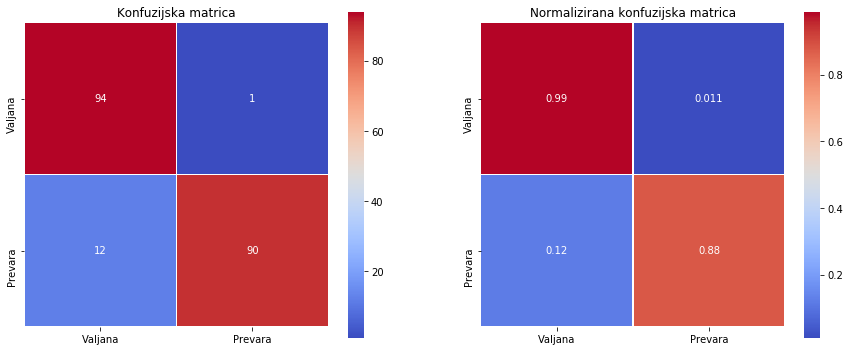

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.92      0.25        98

    accuracy                           0.99     56962
   macro avg       0.57      0.95      0.62     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


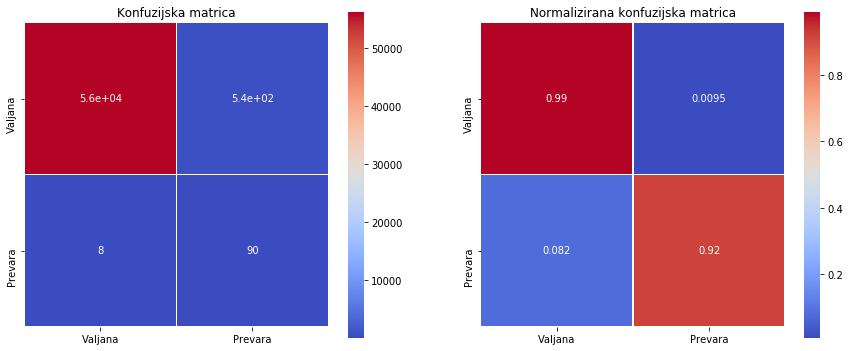

----------------------------------------------------------------------------------------------------


In [97]:
#testiranje
knn_y_pred_usample_params = knn_params_usample.predict(X_usample_test)

knn_y_full_pred_params = knn_params_usample.predict(X_data_test)
print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, knn_y_pred_usample_params)
print()
print('--'*50)
print(classification_report(y_usample_test, knn_y_pred_usample_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, knn_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
print()
print('--'*50)
print(classification_report(y_data_test, knn_y_full_pred_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, knn_y_full_pred_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Ovdje jasno vidimo da je bilo isplativo podešavanje parametara jer smo dobili jednak broj pogrešno klasificiranih prevara (8), ali smo broj pogrešno klasificiranih valjanih transakcija skoro prepolovili (bilo je 1000, sad je 540). <br>
Za kraj algoritma najbližih susjeda još ćemo maknut ouliere u nadi da ćemo time još poboljšati model.</p>

In [98]:
#bez outliera
grid_knn_cut = GridSearchCV(KNeighborsClassifier(), knn_params)
grid_knn_cut.fit(X_usample_cut_train, y_usample_cut_train)
knn_params_usample_cut = grid_knn_cut.best_estimator_
knn_params_cut = grid_knn_cut.best_params_
print('Najbolji parametri: ' + str(knn_params_cut))

knn_training_score_params_usample_cut = cross_val_score(knn_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print('Rezultat treniranja za k (' + str(knn_params_cut['n_neighbors']) +
      ') nad undersampliranim datasetom (sa parametrima, bez outliera): ' 
     + str(round(knn_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 3, 'p': 1}
Rezultat treniranja za k (3) nad undersampliranim datasetom (sa parametrima, bez outliera): 93.72%


--------------------------------------------------
Za undersamplirani dataset (sa podešenim parametrima, bez outliera):
	Precision score: 95.28999999999999%
	Recall score: 86.17%
	F1 score: 90.5%
----------------------------------------------------------------------------------------------------


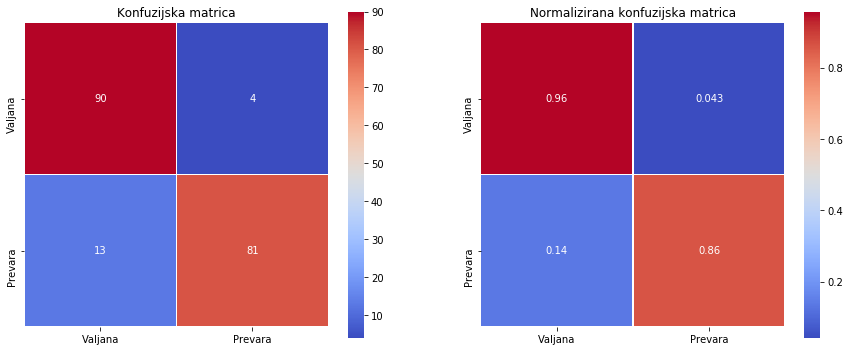

Za cijeli dataset:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.94      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.97      0.99     56962


----------------------------------------------------------------------------------------------------


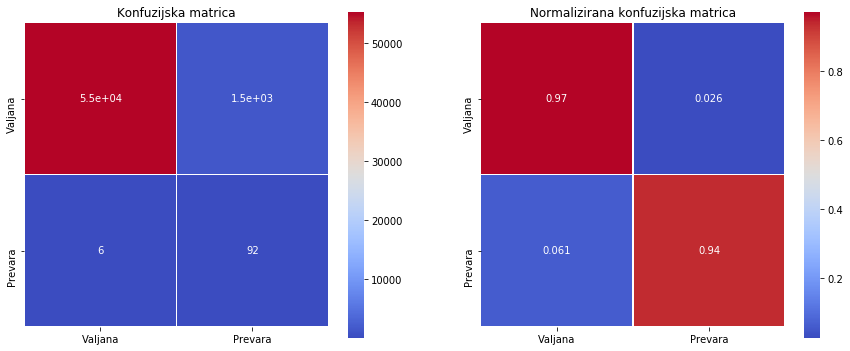

----------------------------------------------------------------------------------------------------


In [99]:
knn_y_pred_usample_params_cut = knn_params_usample_cut.predict(X_usample_cut_test)
knn_y_full_pred_params_cut = knn_params_usample_cut.predict(X_data_test)
print('-'*50)
print('Za undersamplirani dataset (sa podešenim parametrima, bez outliera):')
precision_recall_f1_scores(y_usample_cut_test, knn_y_pred_usample_params_cut)
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, knn_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('Za cijeli dataset:')
print()
print('--'*50)
print(classification_report(y_data_test, knn_y_full_pred_params_cut))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, knn_y_full_pred_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Micanjem outliera smanjili smo broj pogrešno klasificiranih prevara (bilo je 8, sad je 6), ali i povećali broj pogrešno klasificiranih valjanih transakcija (bilo je 540, sad je 1500). Prilikom odabira modela koji nam je po želji moramo uzeti te obje stvari u obzir i odlučiti.</p>

## Metoda potpornih vektora

Sljedeća metoda koju koristimo u ovoj bilježnici je možda i najpopularnija metoda strojnog učenja zvana metodom potpornih vektora. I ovdje ćemo koristiti isti pristup kao i kod prethodnih metoda.</p>

In [70]:
#SVC

In [100]:
#ovo je novi nivo sporosti
svc_data = SVC()
svc_data.fit(X_data_train, y_data_train)
svc_data_training_score = cross_val_score(svc_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za metodu potpornih vektora nad cijelim datasetom: " + 
      str(round(svc_data_training_score.mean(), 4) * 100) + '%')

Rezultat treniranja za metodu potpornih vektora nad cijelim datasetom: 99.94%


----------------------------------------------------------------------------------------------------
Za cijeli dataset:
	Precision score: 96.83%
	Recall score: 62.239999999999995%
	F1 score: 75.78%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.62      0.76        98

    accuracy                           1.00     56962
   macro avg       0.98      0.81      0.88     56962
weighted avg       1.00      1.00      1.00     56962


----------------------------------------------------------------------------------------------------


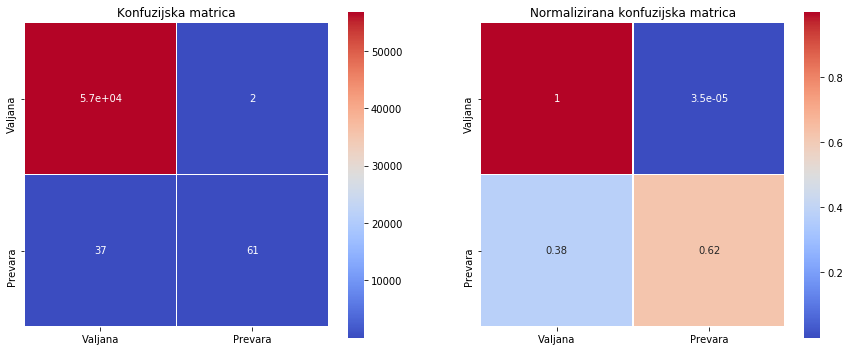

----------------------------------------------------------------------------------------------------


In [101]:

svc_y_pred_data = svc_data.predict(X_data_test)

print('--'*50)
print('Za cijeli dataset:')
precision_recall_f1_scores(y_data_test, svc_y_pred_data)
print()
print('--'*50)
print(classification_report(y_data_test, svc_y_pred_data))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, svc_y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Rezultati ovog prvog modela se čine prilično loši (iako je samo 2 pogrešno klasificirane valjane transakcije. Razlog tome je što model pogrešno klasificira čak 37 prevara (što je skoro 38%). Tako da najbolje da odmah pređemo na undersampling.</p>

In [105]:
#usample
svc_usample = SVC()
svc_usample.fit(X_usample_train, y_usample_train)
svc_training_score_usample = cross_val_score(svc_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom: " + 
      str(round(svc_training_score_usample.mean(), 4) * 100) + '%')

Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom: 93.39%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 96.77%
	Recall score: 88.24%
	F1 score: 92.31%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        95
           1       0.97      0.88      0.92       102

    accuracy                           0.92       197
   macro avg       0.93      0.93      0.92       197
weighted avg       0.93      0.92      0.92       197


----------------------------------------------------------------------------------------------------


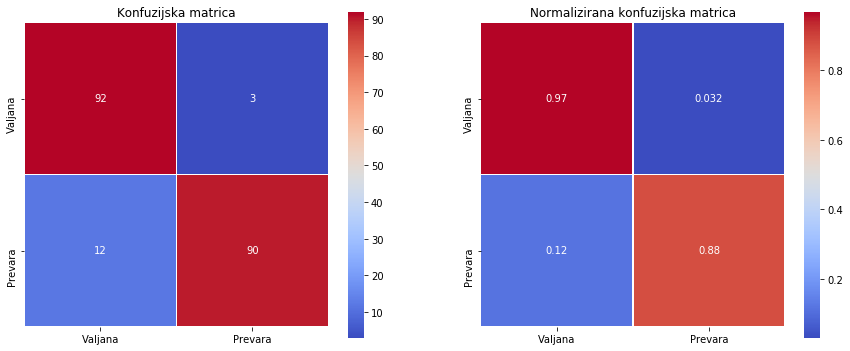

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.89      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


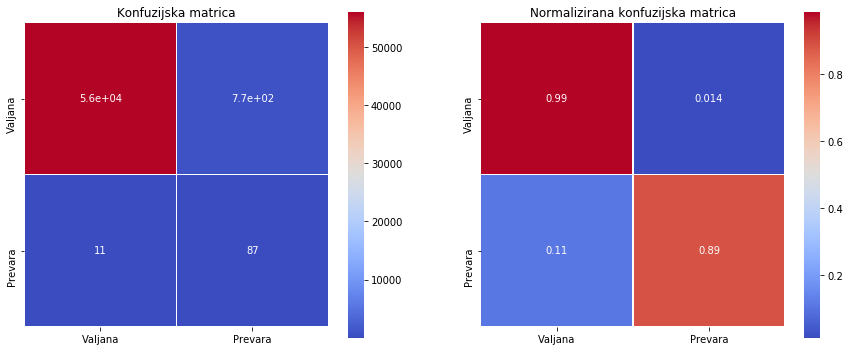

----------------------------------------------------------------------------------------------------


In [106]:
#nad usample test
svc_y_pred_usample = svc_usample.predict(X_usample_test)

svc_y_full_pred = svc_usample.predict(X_data_test)
print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, svc_y_pred_usample)
print()
print('--'*50)
print(classification_report(y_usample_test, svc_y_pred_usample))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, svc_y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
print()
print('--'*50)
print(classification_report(y_data_test, svc_y_full_pred))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, svc_y_full_pred), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)




<p>Ovdje već dobivamo solidne rezultate (11 pogrešno klasificiranih prevara i 770 pogrešno klasificirnaih valjanih transakcija). No očekujemo da će se to još popraviti.</p>

<p>Kao i kod ranijih metoda i ovdje ćemo pokušati podesiti parametre kako bismo dobili bolje rezultate. Parametri koje podešavamo kod metode potpornih vektora su:</p>
<ul>
    <li><em>C</em> - regularizacijski parametar (inverzno proporcionalan sa snagom regularizacije, vrijednosti: 0.01, 0.05, 0.1 ,0.2, 0.5, 0.75, 0.9, 1.00)</li>
    <li><em>kernel</em> - funkcija koja omogućava rad u više-dimenzionalnom prostoru bez da ikad izračuna koordinate u tom višedimenzionalnom prostoru, već koristi unutarnje produkte slika svih parova podataka u prostoru značajki.
        <ul>
            <li><i>linear</i> - koristi linearnu plohu da podijeli podatke (u 2D slučaju crtu), formulom: $K(X,Y) = X^TY$</li>
            <li><i>poly</i> - koristi polinom da podijeli podatke, formulom: $K(X,Y) = (\gamma \cdot X^TY + r)^d$</li>
            <li><i>sigomid</i> - koristi sigmoidalnu funkciju (nešto kao tangens hiperbolni), formulom: $K(X,Y) = \tanh(\gamma \cdot X^TY + r)$</li>
            <li><i>rbf</i> - koristi krivulje koje okružuju podatke i sumira ih tako da granica podjele bude definirana topološkim uvjetom (primjerice krivulje u kojima je suma veća od 0.5), formulom: $K(X,Y) = \exp\Big(\frac{\mid\mid X - Y \mid\mid^2}{2 \sigma^2}\Big)$</li>
        </ul>
    </li>
    <li><em>stupanj (oznaka u formuli: $d$)</em> - u slučaju da je kernel='poly', ovim parametrom biramo stupanj polinoma (vrijednosti: 1, 2, 3, 4, 5)</li>
    <li><em>gamma (oznaka u formulama: $\gamma$)</em> - koeficijent koji ubacujemo u kernel  
    <ul>
        <li><i>scale</i> - kao vrijednost uzima $\frac{1}{brojZnačajki * varijanca}$</li>
        <li><i>auto</i> - kao vrijednost uzima $\frac{1}{brojZnačajki}$</li>
    </ul>
    </li>
    <li><em>coef0</em> - slobodni koeficijent (0, 0.5, 1) </li>
</ul>

In [109]:
#s parametrima

svc_c_params = [0.01, 0.05, 0.1 ,0.2, 0.5, 0.75, 0.9, 1]
kernel_params = ['linear', 'poly', 'sigmoid', 'rbf']
degree_params = [1, 2, 3, 4, 5]
gamma_params = ['scale', 'auto']
coef0_params = [0, 0.5, 1]


svc_params = {'C': svc_c_params, 'kernel': kernel_params, 'degree': degree_params, 'gamma': gamma_params, 'coef0': coef0_params}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_usample_train, y_usample_train)
svc_params_usample = grid_svc.best_estimator_
svc_params_best = grid_svc.best_params_
print('Najbolji parametri: ' + str(svc_params_best))

svc_training_score_params_usample = cross_val_score(svc_params_usample, X_usample_train, y_usample_train, cv=skfold)
print('Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima): ' 
     + str(round(svc_training_score_params_usample.mean(), 4) * 100) + '%')


Najbolji parametri: {'C': 0.2, 'coef0': 0.5, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima): 94.03%


----------------------------------------------------------------------------------------------------
Testiranje na undersampliranom datasetu:
	Precision score: 96.84%
	Recall score: 90.2%
	F1 score: 93.4%

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.97      0.90      0.93       102

    accuracy                           0.93       197
   macro avg       0.94      0.94      0.93       197
weighted avg       0.94      0.93      0.93       197


----------------------------------------------------------------------------------------------------


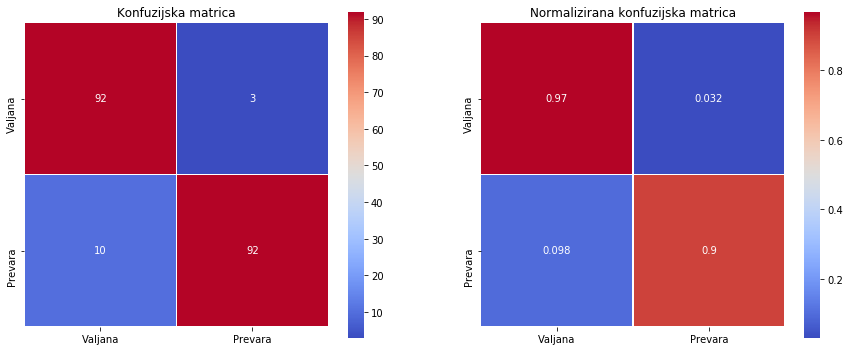

----------------------------------------------------------------------------------------------------
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Testiranje na cijelom datasetu:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.14      0.93      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.96      0.62     56962
weighted avg       1.00      0.99      0.99     56962


----------------------------------------------------------------------------------------------------


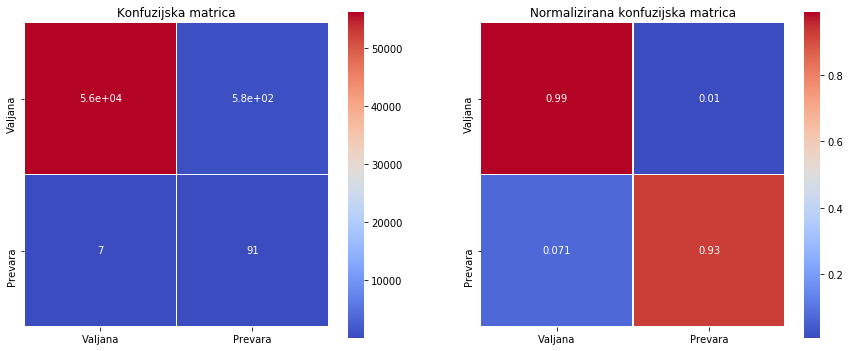

----------------------------------------------------------------------------------------------------


In [110]:
#testiranje
svc_y_pred_usample_params = svc_params_usample.predict(X_usample_test)

svc_y_full_pred_params = svc_params_usample.predict(X_data_test)
print('--'*50)
print('Testiranje na undersampliranom datasetu:')
precision_recall_f1_scores(y_usample_test, svc_y_pred_usample_params)
print()
print('--'*50)
print(classification_report(y_usample_test, svc_y_pred_usample_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_usample_test, svc_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('-'*100)
print('*'*100)
print('-'*100)
print('Testiranje na cijelom datasetu:')
print()
print('--'*50)
print(classification_report(y_data_test, svc_y_full_pred_params))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, svc_y_full_pred_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Kao što smo i očekivali, parametri čine čuda za metodu potpornih vektora. U ovom slučaju konkretno model je pogrešno klasificirao samo 7 prevara (bez podešenih parametara je bilo 11), te je također i smanjio broj pogrešno klasificiranih valjanih transakcija (sada je 580, a bilo je 770). Za kraj ove metode odbacit ćemo outliere i vidjeti hoće li to donijeti još veći napredak.</p>

In [111]:
#bez outliera
grid_svc_cut = GridSearchCV(SVC(), svc_params)
grid_svc_cut.fit(X_usample_cut_train, y_usample_cut_train)
svc_params_usample_cut = grid_svc_cut.best_estimator_
svc_params_cut = grid_svc_cut.best_params_
print('Najbolji parametri: ' + str(svc_params_cut))

svc_training_score_params_usample_cut = cross_val_score(svc_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print('Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima, bez outliera): ' 
     + str(round(svc_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Najbolji parametri: {'C': 0.5, 'coef0': 0.5, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Rezultat treniranja za metodu potpornih vektora nad undersampliranim datasetom (sa parametrima, bez outliera): 93.31%


--------------------------------------------------
Za undersamplirani dataset (sa podešenim parametrima, bez outliera):
	Precision score: 98.78%
	Recall score: 86.17%
	F1 score: 92.05%
----------------------------------------------------------------------------------------------------


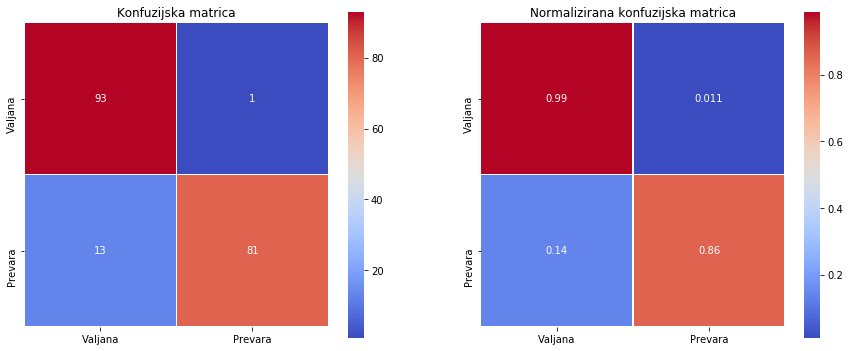

Za cijeli dataset:

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.95      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.97      0.58     56962
weighted avg       1.00      0.98      0.99     56962


----------------------------------------------------------------------------------------------------


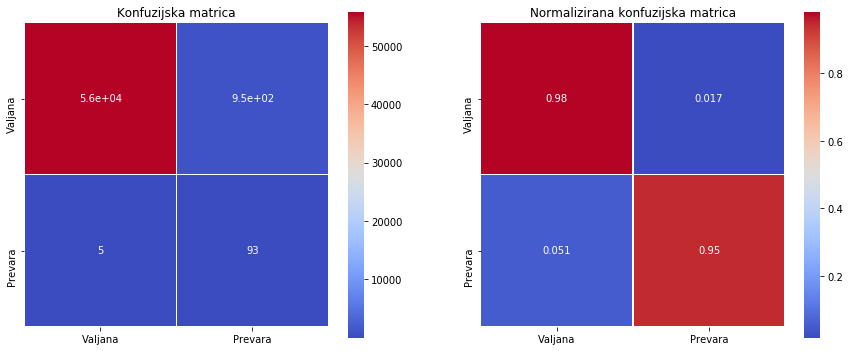

----------------------------------------------------------------------------------------------------


In [112]:
svc_y_pred_usample_params_cut = svc_params_usample_cut.predict(X_usample_cut_test)
svc_y_full_pred_params_cut = svc_params_usample_cut.predict(X_data_test)
print('-'*50)
print('Za undersamplirani dataset (sa podešenim parametrima, bez outliera):')
precision_recall_f1_scores(y_usample_cut_test, svc_y_pred_usample_params_cut)
print('-'*100)
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, svc_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('Za cijeli dataset:')
print()
print('--'*50)
print(classification_report(y_data_test, svc_y_full_pred_params_cut))
print()
print('--'*50)
plot_confusion_matrix(confusion_matrix(y_data_test, svc_y_full_pred_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('-'*100)

<p>Nakon što smo izbacili outliere dobili smo s jedne strane bolje, s druge strane gore rezultate. Poboljšali smo prepoznavanje prevara (samo 5 pogrešno klasificiranih), ali pogoršali prepoznavanje valjanih transakcija (950 pogrešno klasificiranih).
    Unatoč tome možemo reći da se metoda potpornih vektora pokazala kao jedna od najboljih.
<br>Ovime smo gotovi s metodom potpornih vektora.
</p>

## Boosting

Kad je riječ o boostingu promatrat ćemo 4 različita algoritma i usporedit rezultate dobivene svakim od njih.
Algoritmi koje promatramo su: <br>
<ol>
<li>XGB (eXtreme Gradient Boosting)</li>
<li>LGBM (Light Gradient Boosting Method)</li>
<li>CatBoost (Categorical Boosting)</li>
<li>AdaBoost (Adaptive Boosting)</li>
</ol>
<br> Kao i kod ranijih metoda počet ćemo s treniranjem na oriiginalnom skupu podataka.

In [75]:
#boosting algoritmi



In [60]:
#dalje boosting
#mozemo dodati usporedbe brzina
#mozda dodati i neku optimizaciju
#roc, pr za ostale osim log reg

#voting classifier (nakon boostinga)

In [113]:
print("XGB (eXtreme Gradient Boosting)")
xgb_data = XGBClassifier()
xgb_data.fit(X_data_train, y_data_train)
xgb_data_training_score = cross_val_score(xgb_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za XGB (extreme gradient boosting) nad cijelim datasetom: " + 
       str(round(xgb_data_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
lgbm_data = LGBMClassifier()
lgbm_data.fit(X_data_train, y_data_train)
lgbm_data_training_score = cross_val_score(lgbm_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za LGBM (light gradient boosting) nad cijelim datasetom: " + 
       str(round(lgbm_data_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("CatBoost (CATegorical Boosting)")
cat_data = CatBoostClassifier(silent=True)
cat_data.fit(X_data_train, y_data_train)
cat_data_training_score = cross_val_score(cat_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za CatBoost (categorical boosting) nad cijelim datasetom: " + 
       str(round(cat_data_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("AdaBoost (ADAptive Boosting)")
ada_data = AdaBoostClassifier()
ada_data.fit(X_data_train, y_data_train)
ada_data_training_score = cross_val_score(ada_data, X_data_train, y_data_train, cv=skfold)
print("Rezultat treniranja za AdaBoost (adaptive boosting) nad cijelim datasetom: " + 
       str(round(ada_data_training_score.mean(), 4) * 100) + '%')

XGB (eXtreme Gradient Boosting)
Rezultat treniranja za XGB (extreme gradient boosting) nad cijelim datasetom: 99.95%
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
Rezultat treniranja za LGBM (light gradient boosting) nad cijelim datasetom: 99.53%
----------------------------------------------------------------------------------------------------
CatBoost (CATegorical Boosting)
Rezultat treniranja za CatBoost (categorical boosting) nad cijelim datasetom: 99.96000000000001%
----------------------------------------------------------------------------------------------------
AdaBoost (ADAptive Boosting)
Rezultat treniranja za AdaBoost (adaptive boosting) nad cijelim datasetom: 99.92%


In [114]:
print('Rezultati treniranja:')
print('\t     XGB: ' + str(round(xgb_data_training_score.mean(), 4) * 100) + '%')
print('\t    LGBM: ' + str(round(lgbm_data_training_score.mean(), 4) * 100) + '%')
print('\tCatBoost: ' + str(round(cat_data_training_score.mean(), 4) * 100) + '%')
print('\tAdaBoost: ' + str(round(ada_data_training_score.mean(), 4) * 100) + '%')

Rezultati treniranja:
	     XGB: 99.95%
	    LGBM: 99.53%
	CatBoost: 99.96000000000001%
	AdaBoost: 99.92%


----------------------------------------------------------------------------------------------------
Testiranje:
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
XGB
	Precision score: 93.02%
	Recall score: 81.63%
	F1 score: 86.96000000000001%
----------------------------------------------------------------------------------------------------
LGBM
	Precision score: 40.82%
	Recall score: 61.22%
	F1 score: 48.980000000000004%
----------------------------------------------------------------------------------------------------
CatBoost
	Precision score: 97.5%
	Recall score: 79.59%
	F1 score: 87.64%
----------------------------------------------------------------------------------------------------
AdaBoost
	Precision score: 83.72%
	Recall score: 73.47%
	F1 score: 78.25999999999999%
--------------------------------------

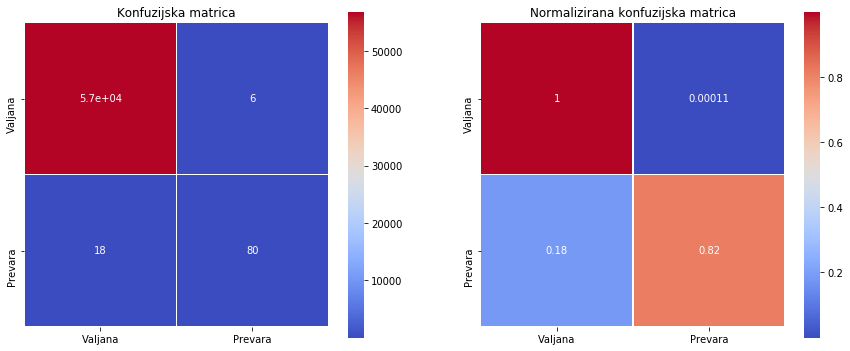

----------------------------------------------------------------------------------------------------
LGBM


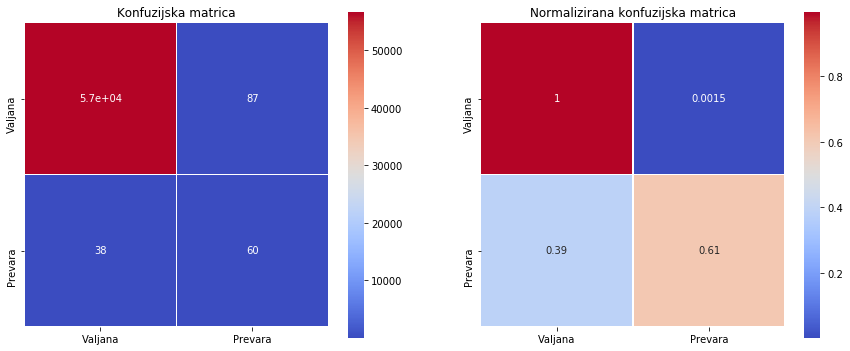

----------------------------------------------------------------------------------------------------
CatBoost


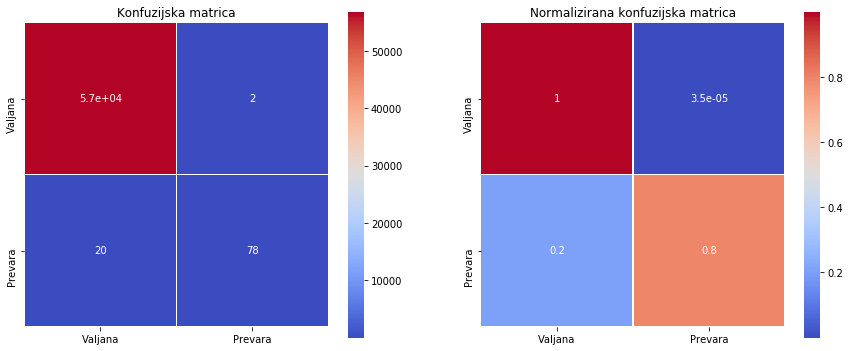

----------------------------------------------------------------------------------------------------
AdaBoost


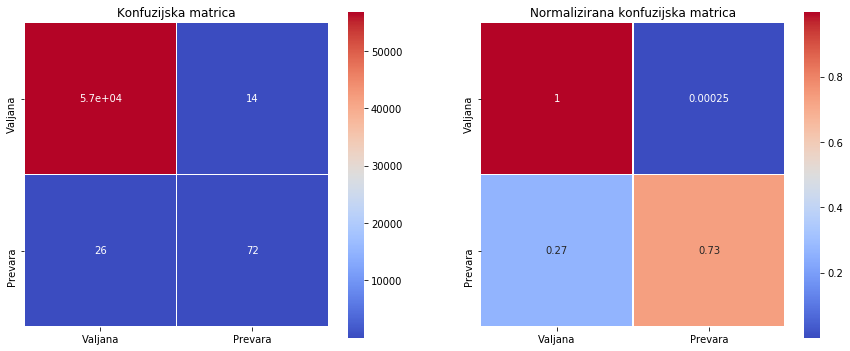

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [118]:
xgb_y_pred_data = xgb_data.predict(X_data_test)
lgbm_y_pred_data = lgbm_data.predict(X_data_test)
cat_y_pred_data = cat_data.predict(X_data_test)
ada_y_pred_data = ada_data.predict(X_data_test)

print('--'*50)
print('Testiranje:')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('XGB')
precision_recall_f1_scores(y_data_test, xgb_y_pred_data)
print('--'*50)
print('LGBM')
precision_recall_f1_scores(y_data_test, lgbm_y_pred_data)
print('--'*50)
print('CatBoost')
precision_recall_f1_scores(y_data_test, cat_y_pred_data)
print('--'*50)
print('AdaBoost')
precision_recall_f1_scores(y_data_test, ada_y_pred_data)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('XGB')
print(classification_report(y_data_test, xgb_y_pred_data))
print('--'*50)
print('LGBM')
print(classification_report(y_data_test, lgbm_y_pred_data))
print('--'*50)
print('CatBoost')
print(classification_report(y_data_test, cat_y_pred_data))
print('--'*50)
print('AdaBoost')
print(classification_report(y_data_test, ada_y_pred_data))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('XGB')
plot_confusion_matrix(confusion_matrix(y_data_test, xgb_y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('LGBM')
plot_confusion_matrix(confusion_matrix(y_data_test, lgbm_y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('CatBoost')
plot_confusion_matrix(confusion_matrix(y_data_test, cat_y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('AdaBoost')
plot_confusion_matrix(confusion_matrix(y_data_test, ada_y_pred_data), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('*'*100)


<p>Usporedimo sada rezultate koje smo dobili korištenjem ovih boosting modela. <br>
Vidimo da je XGB bio najuspješniji sa 80 točno klasificiranih prevara i samo 6 pogrešno klasificiranih valjanih transakcija. Nasuprot tome LGBM je bio dosta neprecizan (čak 38 pogrešno klasificiranih prevara ili 39%) te 87 pogrešno klasificiranih valjanih transakcija (čime je najneuspješniji od 4 boosting algoritama). Catboost je također bio prilično uspješan sa 78 ispravno klasificiranih prevara, te samo 2 pogrešno klasificirane valjane transakcije. Adaboost, koji je možda i najpoznatiji boosting algoritam, se također nije proslavio. Njegov model je pogrešno klasificirao 26 prevara (27%) te 14 valjanih transakcija.

<br>Sljedeće ćemo provesti treniranje na podacima dobivenim nakon undersamplinga. Ovo je puno puta pokazalo bolje rezultate s time da je i trening značajno brži.</p>

In [121]:
print('Undersample: ')
print('-------------------------------')
print("XGB (eXtreme Gradient Boosting)")
xgb_usample = XGBClassifier()
xgb_usample.fit(X_usample_train, y_usample_train)
xgb_usample_training_score = cross_val_score(xgb_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za XGB (extreme gradient boosting) nad undersampliranim datasetom: " + 
       str(round(xgb_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("LGBM (Light Gradient Boosting Method)")
lgbm_usample = LGBMClassifier()
lgbm_usample.fit(X_usample_train, y_usample_train)
lgbm_usample_training_score = cross_val_score(lgbm_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za LGBM (light gradient boosting) nad undersampliranim datasetom: " + 
       str(round(lgbm_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("CatBoost (CATegorical Boosting)")
cat_usample = CatBoostClassifier(silent=True)
cat_usample.fit(X_usample_train, y_usample_train)
cat_usample_training_score = cross_val_score(cat_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za CatBoost (categorical boosting) nad undersampliranim datasetom: " + 
       str(round(cat_usample_training_score.mean(), 4) * 100) + '%')

print('-'*100)
print("AdaBoost (ADAptive Boosting)")
ada_usample = AdaBoostClassifier()
ada_usample.fit(X_usample_train, y_usample_train)
ada_usample_training_score = cross_val_score(ada_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za AdaBoost (adaptive boosting) nad undersampliranim datasetom: " + 
       str(round(ada_usample_training_score.mean(), 4) * 100) + '%')

Undersample: 
-------------------------------
XGB (eXtreme Gradient Boosting)
Rezultat treniranja za XGB (extreme gradient boosting) nad undersampliranim datasetom: 93.52000000000001%
----------------------------------------------------------------------------------------------------
LGBM (Light Gradient Boosting Method)
Rezultat treniranja za LGBM (light gradient boosting) nad undersampliranim datasetom: 93.01%
----------------------------------------------------------------------------------------------------
CatBoost (CATegorical Boosting)
Rezultat treniranja za CatBoost (categorical boosting) nad undersampliranim datasetom: 93.89999999999999%
----------------------------------------------------------------------------------------------------
AdaBoost (ADAptive Boosting)
Rezultat treniranja za AdaBoost (adaptive boosting) nad undersampliranim datasetom: 92.36999999999999%


In [122]:
print('Rezultati treniranja:')
print('\t     XGB: ' + str(round(xgb_usample_training_score.mean(), 4) * 100) + '%')
print('\t    LGBM: ' + str(round(lgbm_usample_training_score.mean(), 4) * 100) + '%')
print('\tCatBoost: ' + str(round(cat_usample_training_score.mean(), 4) * 100) + '%')
print('\tAdaBoost: ' + str(round(ada_usample_training_score.mean(), 4) * 100) + '%')

Rezultati treniranja:
	     XGB: 93.52000000000001%
	    LGBM: 93.01%
	CatBoost: 93.89999999999999%
	AdaBoost: 92.36999999999999%


----------------------------------------------------------------------------------------------------
Testiranje (na undersampleu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
XGB
	Precision score: 96.0%
	Recall score: 94.12%
	F1 score: 95.05%
----------------------------------------------------------------------------------------------------
LGBM
	Precision score: 96.91%
	Recall score: 92.16%
	F1 score: 94.47%
----------------------------------------------------------------------------------------------------
CatBoost
	Precision score: 96.88%
	Recall score: 91.18%
	F1 score: 93.94%
----------------------------------------------------------------------------------------------------
AdaBoost
	Precision score: 94.89999999999999%
	Recall score: 91.18%
	F1 score: 93.0%
----------------------------------------------

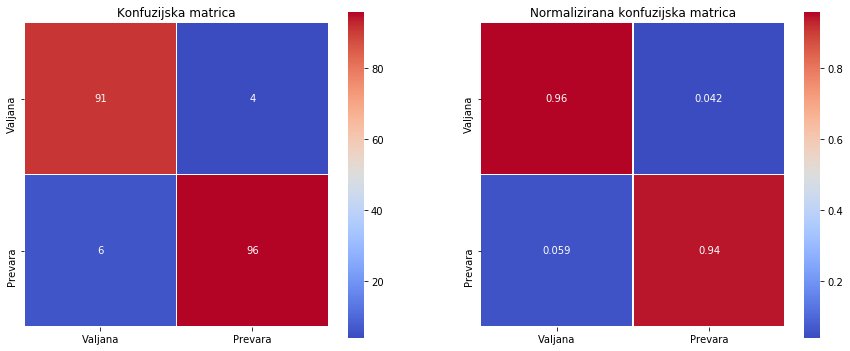

----------------------------------------------------------------------------------------------------
LGBM


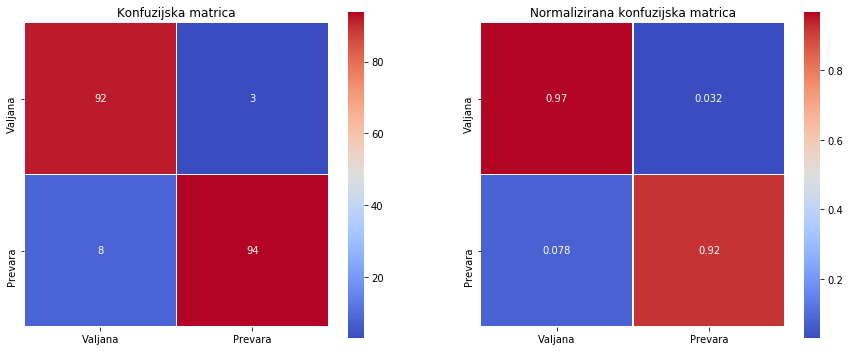

----------------------------------------------------------------------------------------------------
CatBoost


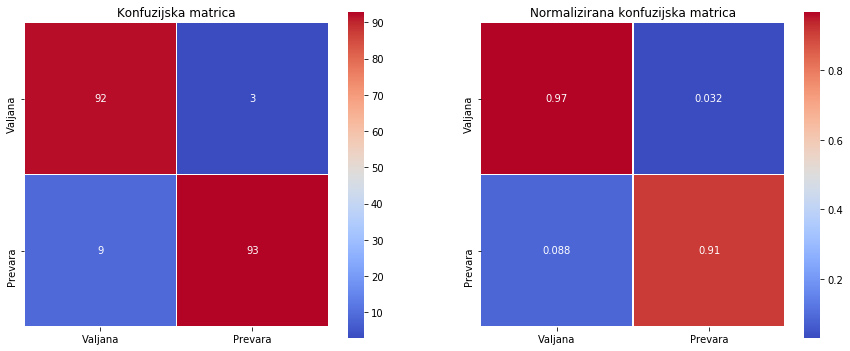

----------------------------------------------------------------------------------------------------
AdaBoost


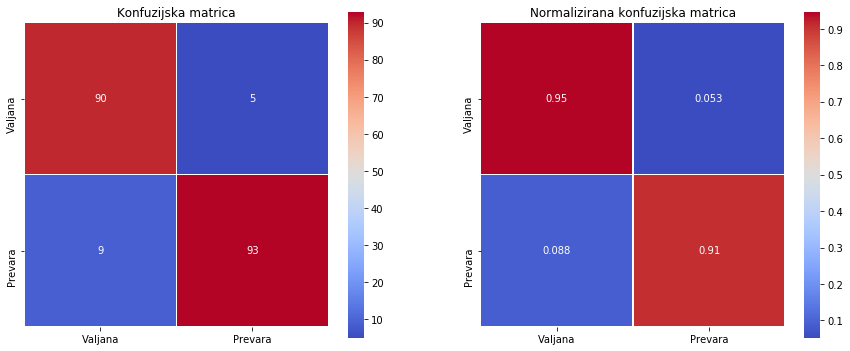

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [123]:
xgb_y_pred_usample = xgb_usample.predict(X_usample_test)
lgbm_y_pred_usample = lgbm_usample.predict(X_usample_test)
cat_y_pred_usample = cat_usample.predict(X_usample_test)
ada_y_pred_usample = ada_usample.predict(X_usample_test)

print('--'*50)
print('Testiranje (na undersampleu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('XGB')
precision_recall_f1_scores(y_usample_test, xgb_y_pred_usample)
print('--'*50)
print('LGBM')
precision_recall_f1_scores(y_usample_test, lgbm_y_pred_usample)
print('--'*50)
print('CatBoost')
precision_recall_f1_scores(y_usample_test, cat_y_pred_usample)
print('--'*50)
print('AdaBoost')
precision_recall_f1_scores(y_usample_test, ada_y_pred_usample)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('XGB')
print(classification_report(y_usample_test, xgb_y_pred_usample))
print('--'*50)
print('LGBM')
print(classification_report(y_usample_test, lgbm_y_pred_usample))
print('--'*50)
print('CatBoost')
print(classification_report(y_usample_test, cat_y_pred_usample))
print('--'*50)
print('AdaBoost')
print(classification_report(y_usample_test, ada_y_pred_usample))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('XGB')
plot_confusion_matrix(confusion_matrix(y_usample_test, xgb_y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('LGBM')
plot_confusion_matrix(confusion_matrix(y_usample_test, lgbm_y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('CatBoost')
plot_confusion_matrix(confusion_matrix(y_usample_test, cat_y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('AdaBoost')
plot_confusion_matrix(confusion_matrix(y_usample_test, ada_y_pred_usample), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('*'*100)


----------------------------------------------------------------------------------------------------
Testiranje (na cijelom datasetu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
XGB
	Precision score: 6.52%
	Recall score: 97.96000000000001%
	F1 score: 12.23%
----------------------------------------------------------------------------------------------------
LGBM
	Precision score: 7.93%
	Recall score: 97.96000000000001%
	F1 score: 14.67%
----------------------------------------------------------------------------------------------------
CatBoost
	Precision score: 11.540000000000001%
	Recall score: 97.96000000000001%
	F1 score: 20.65%
----------------------------------------------------------------------------------------------------
AdaBoost
	Precision score: 3.2399999999999998%
	Recall score: 96.94%
	F1 score:

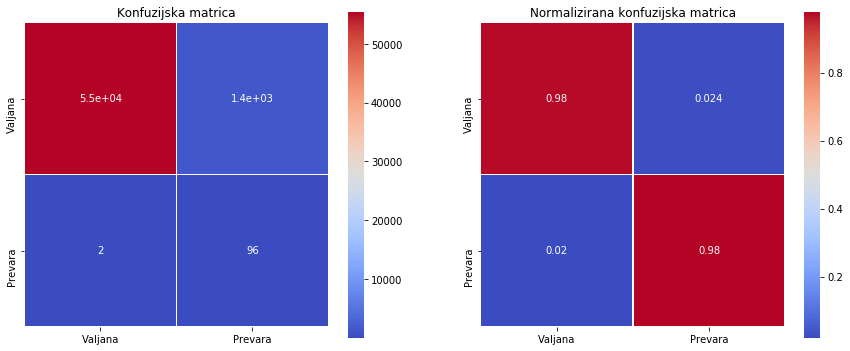

----------------------------------------------------------------------------------------------------
LGBM


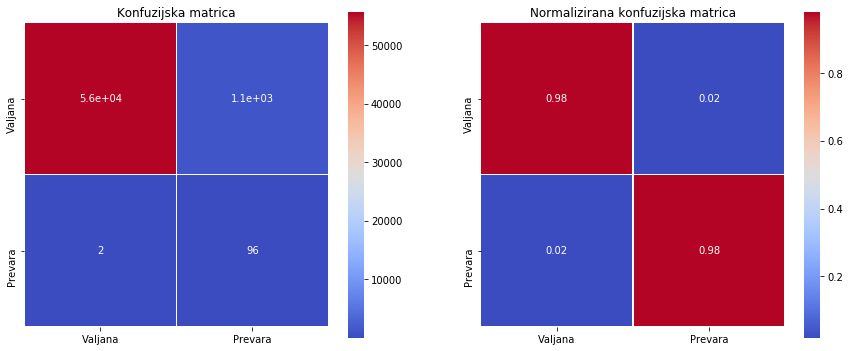

----------------------------------------------------------------------------------------------------
CatBoost


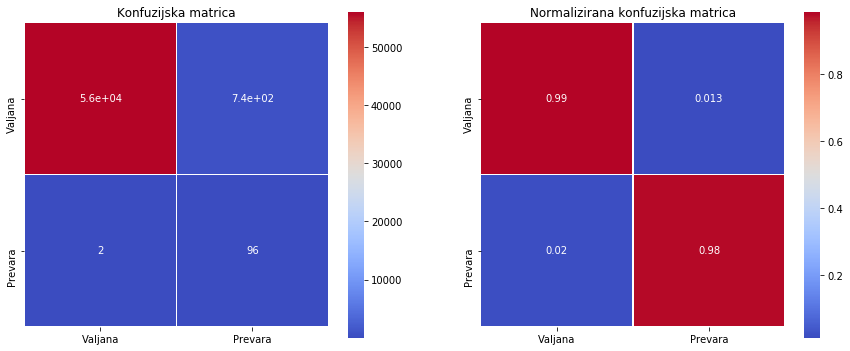

----------------------------------------------------------------------------------------------------
AdaBoost


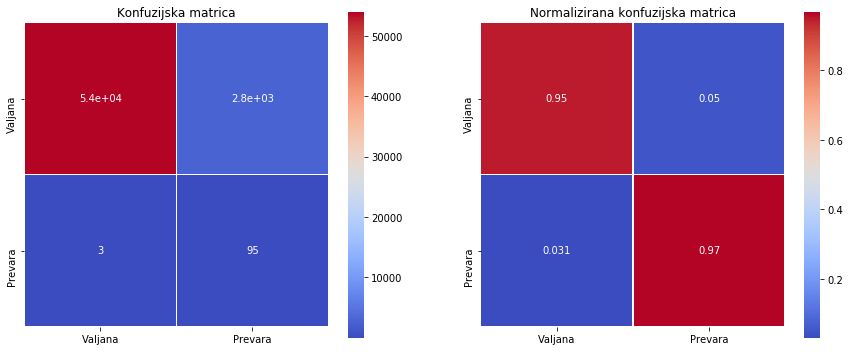

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [124]:
xgb_y_pred_full = xgb_usample.predict(X_data_test)
lgbm_y_pred_full = lgbm_usample.predict(X_data_test)
cat_y_pred_full = cat_usample.predict(X_data_test)
ada_y_pred_full = ada_usample.predict(X_data_test)

print('--'*50)
print('Testiranje (na cijelom datasetu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('XGB')
precision_recall_f1_scores(y_data_test, xgb_y_pred_full)
print('--'*50)
print('LGBM')
precision_recall_f1_scores(y_data_test, lgbm_y_pred_full)
print('--'*50)
print('CatBoost')
precision_recall_f1_scores(y_data_test, cat_y_pred_full)
print('--'*50)
print('AdaBoost')
precision_recall_f1_scores(y_data_test, ada_y_pred_full)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('XGB')
print(classification_report(y_data_test, xgb_y_pred_full))
print('--'*50)
print('LGBM')
print(classification_report(y_data_test, lgbm_y_pred_full))
print('--'*50)
print('CatBoost')
print(classification_report(y_data_test, cat_y_pred_full))
print('--'*50)
print('AdaBoost')
print(classification_report(y_data_test, ada_y_pred_full))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('XGB')
plot_confusion_matrix(confusion_matrix(y_data_test, xgb_y_pred_full), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('LGBM')
plot_confusion_matrix(confusion_matrix(y_data_test, lgbm_y_pred_full), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('CatBoost')
plot_confusion_matrix(confusion_matrix(y_data_test, cat_y_pred_full), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('AdaBoost')
plot_confusion_matrix(confusion_matrix(y_data_test, ada_y_pred_full), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('*'*100)


<p>Kao i u ostatku bilježnice, nećemo previše obraćati pozornost na testiranje na undersampliranom skupu podataka. <br>
Vidimo da su rezultati testiranja na originalnom testnom skupu dosta impersivni. XGB je pogrešno klasificirao samo 2 prevare, te 1400 valjanih transakcija. Od njega je još bolji bio LGBM (koji je prije imao slabe rezultate) koji je također pogrešno klasificirao samo 2 prevare, ali i samo 1100 valjanih transakcija (što je 300 manje od XGB-a). Catboost je bio još bolji. Taj model je imao samo 740 pogrešno klasificiranih valjanih transakcija (uz 2 pogrešno klasificirane valjene transakcije - kao i XGB i LGBM). Adaboost je bio najlošiji u ovom krugu. Taj model je za razliku od ostalih imao 3 pogrešno klasificirane prevare (što je i dalje vrlo dobro), dok je pogrešno klasificirao čak 2800 valjanih transakcija (što je duplo više XGB-a).
</p>

<p>Sljedeće ćemo pokušati podesiti parametre, nadajući se da će to popraviti broj pogrešno klasificiranih valjanih transakcija. Parametri za XGB:</p>
<ul>
    <li><em>gamma</em> - regularizacijski parametar 'kroz sva stabla' (vrijednosti: 0, 1, 5, 10)</li>
    <li><em>maksimalna dubina</em> - maksimalna dubina stabala (vrijednosti: 1, 2, 3, 4, 5)</li>
    <li><em>udio stupaca po drvu</em> - udio stupaca korišten za konstrukciju svakog stabla (vrijednosti: 0.3, 0.5, 0.8) </li>
    <li><em>brzina učenja </em> - što je brzina učenja manja imamo više koraka, ali potencijalno i precizniji model (vrijednosti: 0.3, 0.1, 0.05, 0.01)</li>
    <li><em>broj procjenitelja</em> - koliko je stabala u slučajnoj šumi (vrijednosti: 10, 20, 50, 100)
</ul>

In [125]:
#parametri

xgb_gamma = [0, 1, 5, 10]
xgb_max_depth = [1, 2, 3, 4, 5]
xgb_colsample_bytree = [0.3, 0.5, 0.8]
xgb_learning_rate = [0.3, 0.1, 0.05, 0.01]
xgb_n_estimators = [10, 20, 50, 100]
xgb_params = {'gamma': xgb_gamma, 'max_depth': xgb_max_depth, 'colsample_bytree': xgb_colsample_bytree, 
              'learning_rate': xgb_learning_rate, 'n_estimators': xgb_n_estimators}

grid_xgb = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb.fit(X_usample_train, y_usample_train)
xgb_params_usample = grid_xgb.best_estimator_
xgb_params_best = grid_xgb.best_params_

Parametri za LGBM:
<ul>
    <li><em>tip boostinga</em> - određuje koju metodu će koristiti prilikom boostinga
        <ul>
            <li><i>gbdt</i> (Gradient Boosting Decision Tree) - tradicionalna stabla odluke trenirana u nekom redoslijedu (u svakom koraku model pokušava naučiti razliku između stvarnog izlaza i težinske sume predikcija prethodne iteracije) </li>
            <li><i>goss</i> (Gradient-based One Sided Sampling) - metoda koja se zasniva na odbacivanju instanci s malim gradijentom (jer su te već dobro trenirane), te se fokusira samo na one s većim gradijentom</li>
            <li><i>rf</i> (Random Forest) - klasičan pristup korištenjem slučajnih šuma </li>
            <li><i>dart</i> (Dropouts meets multiple Additive Regression Trees) - novija metoda u koju je dropout tehnika korištena najviše kod dubokih neuronskih mreža</li>
        </ul>
    </li>
    <li><em>maksimalna dubina</em> - isto značenje kao i kod XGB-a</li>
    <li><em>udio stupaca po stablu</em> - isto značenje kao i kod XGB-a</li>
    <li><em>broj procjenitelja</em> - isto značenje kao i kod XGB-a</li>
    <li><em>brzina učenja</em>- isto značenje kao i kod XGB-a</li>
</ul>

In [126]:
#gdbt = gradient boosting decision tree
#goss = gradient-based one side sampling
#rf = random forest
#dart = dropouts meets multiple additive regression trees

lgbm_boosting_type = ['gbdt', 'goss', 'rf', 'dart']
lgbm_max_depth = xgb_max_depth
lgbm_learning_rate = xgb_learning_rate
lgbm_colsample_bytree = xgb_colsample_bytree
lgbm_n_estimators = xgb_n_estimators
lgbm_params = {'boosting_type': lgbm_boosting_type, 'max_depth': lgbm_max_depth, 'colsample_bytree': lgbm_colsample_bytree, 
               'learning_rate': lgbm_learning_rate, 'n_estimators': lgbm_n_estimators}

grid_lgbm = GridSearchCV(LGBMClassifier(), lgbm_params)
grid_lgbm.fit(X_usample_train, y_usample_train)
lgbm_params_usample = grid_lgbm.best_estimator_
lgbm_params_best = grid_lgbm.best_params_

C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 805, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", line 1716, in __init__
    ctypes.byref(self.handle)))
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", li

Parametri za CatBoost:
    <ul>
    <li><em>dubina</em> - isto značenje kao i za XGB</li>
    <li><em>brzina učenja</em> - isto značenje kao i za XGB</li>
    <li><em>broj procjenitelja</em> - isto značenje kao i za XGB</li>
    </ul>

In [127]:
cat_depth = xgb_max_depth
cat_learning_rate = xgb_learning_rate
# cat_iterations = [10, 25, 50, 100]
cat_n_estimators = xgb_n_estimators
cat_params = {'depth': cat_depth, 'learning_rate': cat_learning_rate, 'n_estimators': cat_n_estimators }

grid_cat = GridSearchCV(CatBoostClassifier(silent=True), cat_params)
grid_cat.fit(X_usample_train, y_usample_train)
cat_params_usample = grid_cat.best_estimator_
cat_params_best = grid_cat.best_params_

Parametri za AdaBoost:
<ul>
    <li><em>procjenitelj</em> - procjenitelj je stablo odluke
        <ul>
            <li><i>kriterij</i> - ima isto značenje kao i za stabla odluke</li>
            <li><i>splitter</i> - ima isto značenje kao i za stabla odluke</li>
            <li><i>maksimalna dubina</i> - ima isto značenje kao i za stabla odluke</li>     
        </ul>
    </li>
    <li><em>broj procjenitelja</em> - ima isto značenje kao i za XGB</li>
    <li><em>brzina učenja</em> - ima isto značenje kao i za XGB</li>
</ul>

In [128]:
ada_criterion = ['gini', 'entropy']
ada_max_depth = xgb_max_depth
ada_splitter = ['best', 'random']
ada_n_estimators = xgb_n_estimators
ada_learning_rate = xgb_learning_rate
ada_params = {'n_estimators': ada_n_estimators, 'learning_rate': ada_learning_rate}

ada_params = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__max_depth": xgb_max_depth,
              "n_estimators": xgb_n_estimators,
              "learning_rate": xgb_learning_rate
             }

grid_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), ada_params)
grid_ada.fit(X_usample_train, y_usample_train)
ada_params_usample = grid_ada.best_estimator_
ada_params_best = grid_ada.best_params_

In [129]:
xgb_training_score_params_usample = cross_val_score(xgb_params_usample, X_usample_train, y_usample_train, cv=skfold)
lgbm_training_score_params_usample = cross_val_score(lgbm_params_usample, X_usample_train, y_usample_train, cv=skfold)
cat_training_score_params_usample = cross_val_score(cat_params_usample, X_usample_train, y_usample_train, cv=skfold)
ada_training_score_params_usample = cross_val_score(ada_params_usample, X_usample_train, y_usample_train, cv=skfold)

print('Treniranje (sa parametrima)')
print('-'*100)
print('XGB')
print('Najbolji parametri: ' + str(xgb_params_best))
print('Rezultat treniranja: ' + str(round(xgb_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('LGBM')
print('Najbolji parametri: ' + str(lgbm_params_best))
print('Rezultat treniranja: ' + str(round(lgbm_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('CatBoost')
print('Najbolji parametri: ' + str(cat_params_best))
print('Rezultat treniranja: ' + str(round(cat_training_score_params_usample.mean(), 4) * 100) + '%')
print('-'*100)
print('AdaBoost')
print('Najbolji parametri: ' + str(ada_params_best))
print('Rezultat treniranja: ' + str(round(ada_training_score_params_usample.mean(), 4) * 100) + '%')

Treniranje (sa parametrima)
----------------------------------------------------------------------------------------------------
XGB
Najbolji parametri: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
Rezultat treniranja: 93.39%
----------------------------------------------------------------------------------------------------
LGBM
Najbolji parametri: {'boosting_type': 'goss', 'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
Rezultat treniranja: 92.88%
----------------------------------------------------------------------------------------------------
CatBoost
Najbolji parametri: {'depth': 4, 'learning_rate': 0.1, 'n_estimators': 100}
Rezultat treniranja: 93.65%
----------------------------------------------------------------------------------------------------
AdaBoost
Najbolji parametri: {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 4, 'base_estimator__splitter': 'random', 'learn

----------------------------------------------------------------------------------------------------
Testiranje (na undersampleu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
XGB
	Precision score: 96.77%
	Recall score: 88.24%
	F1 score: 92.31%
----------------------------------------------------------------------------------------------------
LGBM
	Precision score: 97.96000000000001%
	Recall score: 94.12%
	F1 score: 96.0%
----------------------------------------------------------------------------------------------------
CatBoost
	Precision score: 96.88%
	Recall score: 91.18%
	F1 score: 93.94%
----------------------------------------------------------------------------------------------------
AdaBoost
	Precision score: 96.88%
	Recall score: 91.18%
	F1 score: 93.94%
---------------------------------------------

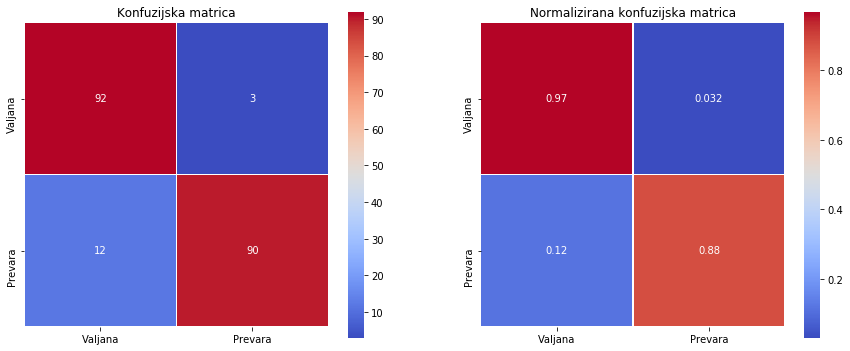

----------------------------------------------------------------------------------------------------
LGBM


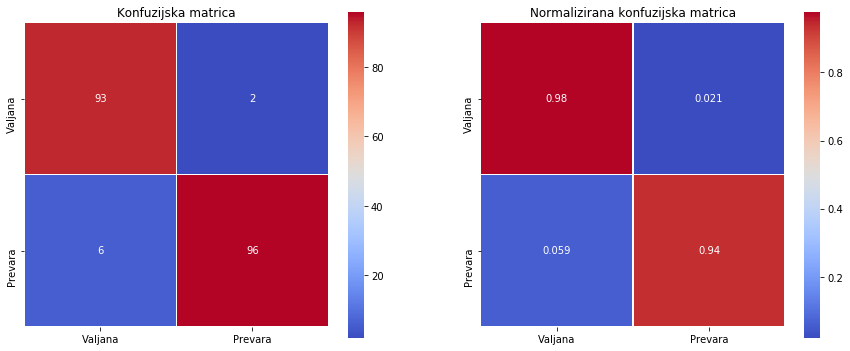

----------------------------------------------------------------------------------------------------
CatBoost


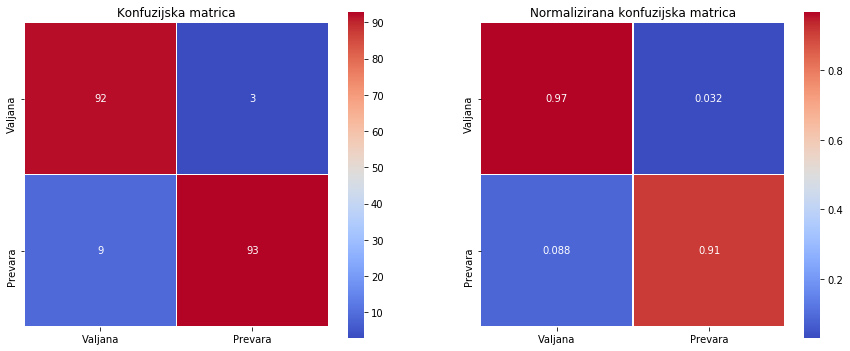

----------------------------------------------------------------------------------------------------
AdaBoost


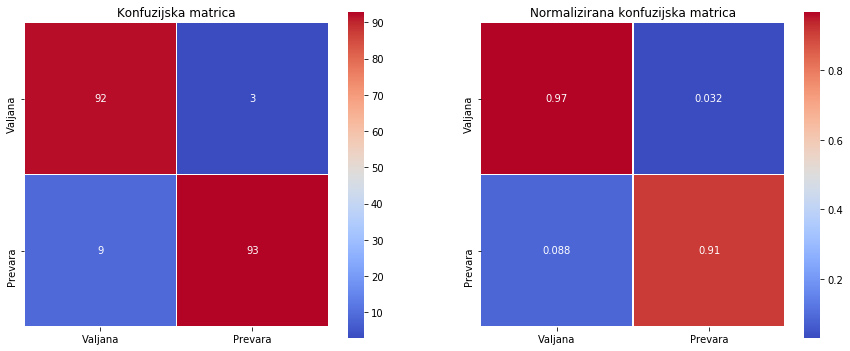

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [132]:
xgb_y_pred_usample_params = xgb_params_usample.predict(X_usample_test)
lgbm_y_pred_usample_params = lgbm_params_usample.predict(X_usample_test)
cat_y_pred_usample_params = cat_params_usample.predict(X_usample_test)
ada_y_pred_usample_params = ada_params_usample.predict(X_usample_test)

print('--'*50)
print('Testiranje (na undersampleu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('XGB')
precision_recall_f1_scores(y_usample_test, xgb_y_pred_usample_params)
print('--'*50)
print('LGBM')
precision_recall_f1_scores(y_usample_test, lgbm_y_pred_usample_params)
print('--'*50)
print('CatBoost')
precision_recall_f1_scores(y_usample_test, cat_y_pred_usample_params)
print('--'*50)
print('AdaBoost')
precision_recall_f1_scores(y_usample_test, ada_y_pred_usample_params)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('XGB')
print(classification_report(y_usample_test, xgb_y_pred_usample_params))
print('--'*50)
print('LGBM')
print(classification_report(y_usample_test, lgbm_y_pred_usample_params))
print('--'*50)
print('CatBoost')
print(classification_report(y_usample_test, cat_y_pred_usample_params))
print('--'*50)
print('AdaBoost')
print(classification_report(y_usample_test, ada_y_pred_usample_params))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('XGB')
plot_confusion_matrix(confusion_matrix(y_usample_test, xgb_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('LGBM')
plot_confusion_matrix(confusion_matrix(y_usample_test, lgbm_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('CatBoost')
plot_confusion_matrix(confusion_matrix(y_usample_test, cat_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('AdaBoost')
plot_confusion_matrix(confusion_matrix(y_usample_test, ada_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('*'*100)


----------------------------------------------------------------------------------------------------
Testiranje (na cijelom datasetu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
XGB
	Precision score: 9.06%
	Recall score: 91.84%
	F1 score: 16.5%
----------------------------------------------------------------------------------------------------
LGBM
	Precision score: 5.609999999999999%
	Recall score: 97.96000000000001%
	F1 score: 10.61%
----------------------------------------------------------------------------------------------------
CatBoost
	Precision score: 8.01%
	Recall score: 97.96000000000001%
	F1 score: 14.799999999999999%
----------------------------------------------------------------------------------------------------
AdaBoost
	Precision score: 6.64%
	Recall score: 96.94%
	F1 score: 12.43%
-------

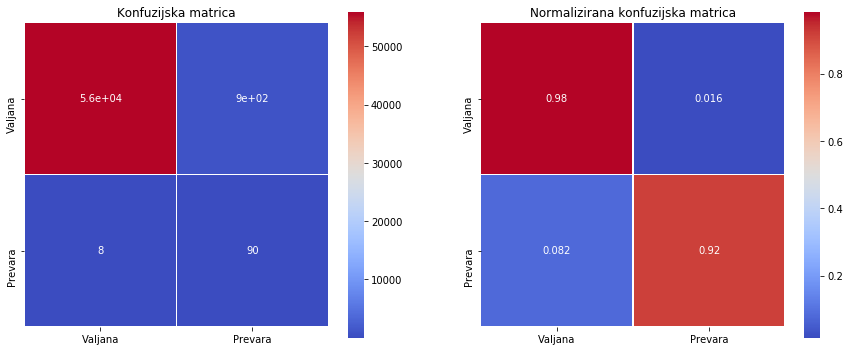

----------------------------------------------------------------------------------------------------
LGBM


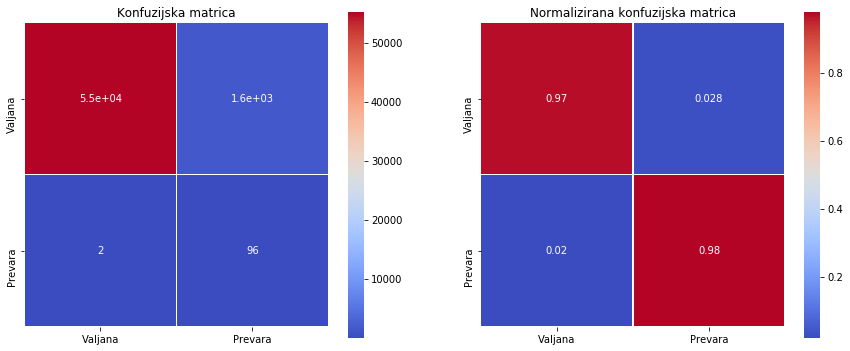

----------------------------------------------------------------------------------------------------
CatBoost


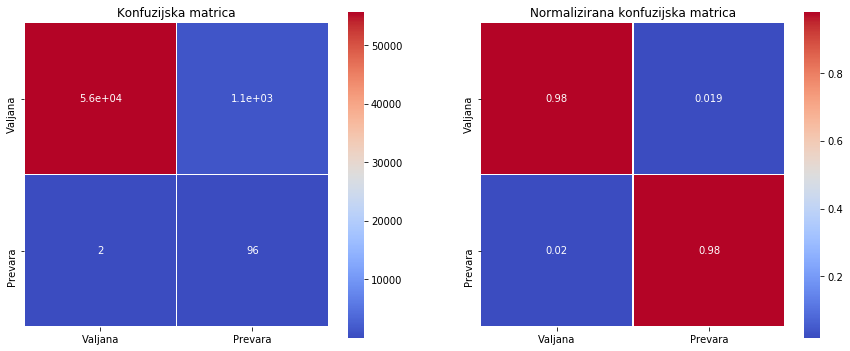

----------------------------------------------------------------------------------------------------
AdaBoost


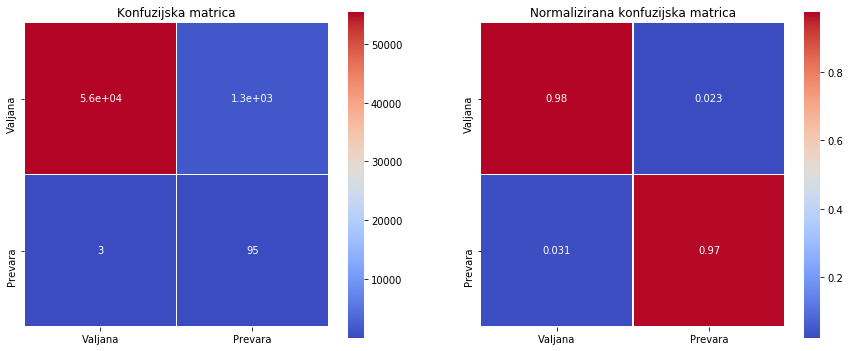

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [133]:
xgb_y_pred_full_params = xgb_params_usample.predict(X_data_test)
lgbm_y_pred_full_params = lgbm_params_usample.predict(X_data_test)
cat_y_pred_full_params = cat_params_usample.predict(X_data_test)
ada_y_pred_full_params = ada_params_usample.predict(X_data_test)

print('--'*50)
print('Testiranje (na cijelom datasetu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('XGB')
precision_recall_f1_scores(y_data_test, xgb_y_pred_full_params)
print('--'*50)
print('LGBM')
precision_recall_f1_scores(y_data_test, lgbm_y_pred_full_params)
print('--'*50)
print('CatBoost')
precision_recall_f1_scores(y_data_test, cat_y_pred_full_params)
print('--'*50)
print('AdaBoost')
precision_recall_f1_scores(y_data_test, ada_y_pred_full_params)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('XGB')
print(classification_report(y_data_test, xgb_y_pred_full_params))
print('--'*50)
print('LGBM')
print(classification_report(y_data_test, lgbm_y_pred_full_params))
print('--'*50)
print('CatBoost')
print(classification_report(y_data_test, cat_y_pred_full_params))
print('--'*50)
print('AdaBoost')
print(classification_report(y_data_test, ada_y_pred_full_params))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('XGB')
plot_confusion_matrix(confusion_matrix(y_data_test, xgb_y_pred_full_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('LGBM')
plot_confusion_matrix(confusion_matrix(y_data_test, lgbm_y_pred_full_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('CatBoost')
plot_confusion_matrix(confusion_matrix(y_data_test, cat_y_pred_full_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('AdaBoost')
plot_confusion_matrix(confusion_matrix(y_data_test, ada_y_pred_full_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('*'*100)


<p>Podešavanje parametara nije donijelo napredak kod svih algoritama osim AdaBoosta (gdje je broj pogrešno klasificiranih valjanih transakcija pao sa 2800 na 1300). </p>

In [139]:
#bez outliera
grid_xgb_cut = GridSearchCV(XGBClassifier(), xgb_params)
grid_xgb_cut.fit(X_usample_cut_train, y_usample_cut_train)
xgb_params_usample_cut = grid_xgb_cut.best_estimator_
xgb_params_cut = grid_xgb_cut.best_params_

grid_lgbm_cut = GridSearchCV(LGBMClassifier(), lgbm_params)
grid_lgbm_cut.fit(X_usample_cut_train, y_usample_cut_train)
lgbm_params_usample_cut = grid_lgbm_cut.best_estimator_
lgbm_params_cut = grid_lgbm_cut.best_params_

grid_cat_cut = GridSearchCV(CatBoostClassifier(silent=True), cat_params)
grid_cat_cut.fit(X_usample_cut_train, y_usample_cut_train)
cat_params_usample_cut = grid_cat_cut.best_estimator_
cat_params_cut = grid_cat_cut.best_params_

grid_ada_cut = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), ada_params)
grid_ada_cut.fit(X_usample_cut_train, y_usample_cut_train)
ada_params_usample_cut = grid_ada_cut.best_estimator_
ada_params_cut = grid_ada_cut.best_params_

C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\stvar\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 805, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 600, in fit
    callbacks=callbacks)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\engine.py", line 228, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", line 1716, in __init__
    ctypes.byref(self.handle)))
  File "C:\Users\stvar\anaconda3\lib\site-packages\lightgbm\basic.py", li

In [140]:
# grid_ada_cut = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), ada_params)
# grid_ada_cut.fit(X_usample_cut_train, y_usample_cut_train)
# ada_params_usample_cut = grid_ada_cut.best_estimator_
# ada_params_cut = grid_ada_cut.best_params_

In [141]:
xgb_training_score_params_usample_cut = cross_val_score(xgb_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
lgbm_training_score_params_usample_cut = cross_val_score(lgbm_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
cat_training_score_params_usample_cut = cross_val_score(cat_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
ada_training_score_params_usample_cut = cross_val_score(ada_params_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)

print('Treniranje (sa parametrima, bez outliera)')
print('-'*100)
print('XGB')
print('Najbolji parametri: ' + str(xgb_params_cut))
print('Rezultat treniranja: ' + str(round(xgb_training_score_params_usample_cut.mean(), 4) * 100) + '%')
print('-'*100)
print('LGBM')
print('Najbolji parametri: ' + str(lgbm_params_cut))
print('Rezultat treniranja: ' + str(round(lgbm_training_score_params_usample_cut.mean(), 4) * 100) + '%')
print('-'*100)
print('CatBoost')
print('Najbolji parametri: ' + str(cat_params_cut))
print('Rezultat treniranja: ' + str(round(cat_training_score_params_usample_cut.mean(), 4) * 100) + '%')
print('-'*100)
print('AdaBoost')
print('Najbolji parametri: ' + str(ada_params_cut))
print('Rezultat treniranja: ' + str(round(ada_training_score_params_usample_cut.mean(), 4) * 100) + '%')

Treniranje (sa parametrima, bez outliera)
----------------------------------------------------------------------------------------------------
XGB
Najbolji parametri: {'colsample_bytree': 0.3, 'gamma': 1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}
Rezultat treniranja: 93.85%
----------------------------------------------------------------------------------------------------
LGBM
Najbolji parametri: {'boosting_type': 'goss', 'colsample_bytree': 0.3, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100}
Rezultat treniranja: 93.72%
----------------------------------------------------------------------------------------------------
CatBoost
Najbolji parametri: {'depth': 2, 'learning_rate': 0.3, 'n_estimators': 100}
Rezultat treniranja: 92.91%
----------------------------------------------------------------------------------------------------
AdaBoost
Najbolji parametri: {'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 3, 'base_estimator__splitter': 

----------------------------------------------------------------------------------------------------
Testiranje (na undersampleu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
XGB
	Precision score: 96.43%
	Recall score: 86.17%
	F1 score: 91.01%
----------------------------------------------------------------------------------------------------
LGBM
	Precision score: 97.65%
	Recall score: 88.3%
	F1 score: 92.74%
----------------------------------------------------------------------------------------------------
CatBoost
	Precision score: 96.47%
	Recall score: 87.22999999999999%
	F1 score: 91.62%
----------------------------------------------------------------------------------------------------
AdaBoost
	Precision score: 98.81%
	Recall score: 88.3%
	F1 score: 93.26%
----------------------------------------------

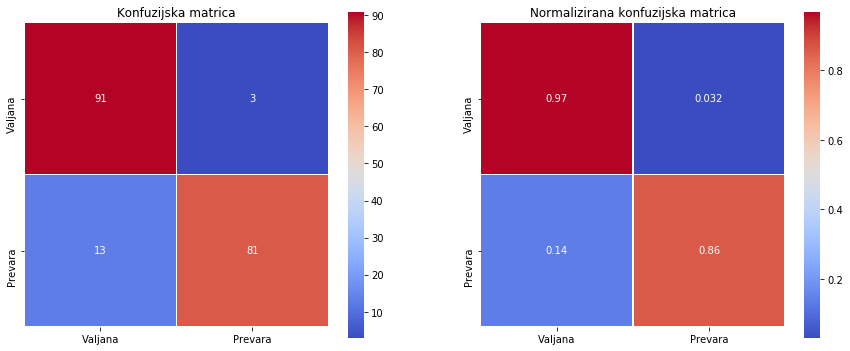

----------------------------------------------------------------------------------------------------
LGBM


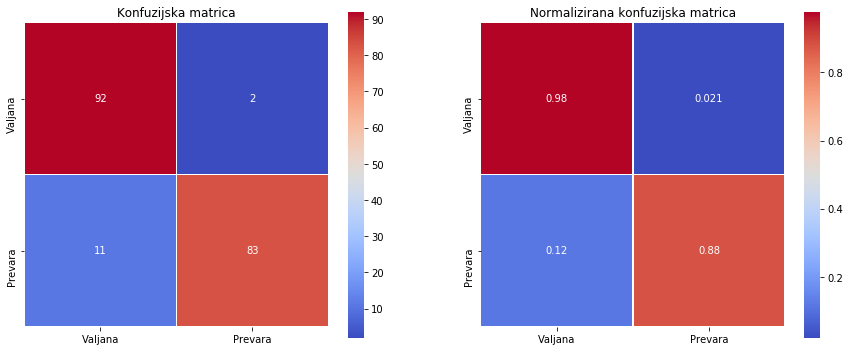

----------------------------------------------------------------------------------------------------
CatBoost


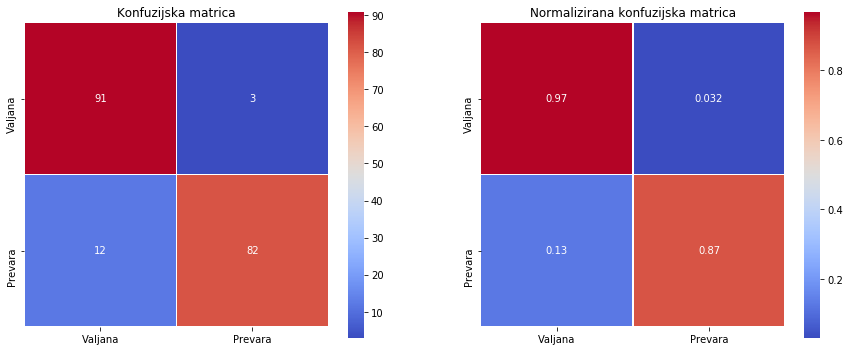

----------------------------------------------------------------------------------------------------
AdaBoost


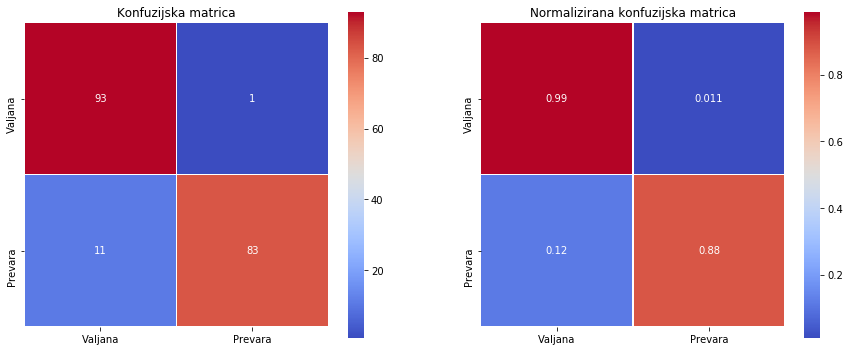

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [142]:
xgb_y_pred_usample_params_cut = xgb_params_usample_cut.predict(X_usample_cut_test)
lgbm_y_pred_usample_params_cut = lgbm_params_usample_cut.predict(X_usample_cut_test)
cat_y_pred_usample_params_cut = cat_params_usample_cut.predict(X_usample_cut_test)
ada_y_pred_usample_params_cut = ada_params_usample_cut.predict(X_usample_cut_test)

print('--'*50)
print('Testiranje (na undersampleu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('XGB')
precision_recall_f1_scores(y_usample_cut_test, xgb_y_pred_usample_params_cut)
print('--'*50)
print('LGBM')
precision_recall_f1_scores(y_usample_cut_test, lgbm_y_pred_usample_params_cut)
print('--'*50)
print('CatBoost')
precision_recall_f1_scores(y_usample_cut_test, cat_y_pred_usample_params_cut)
print('--'*50)
print('AdaBoost')
precision_recall_f1_scores(y_usample_cut_test, ada_y_pred_usample_params_cut)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('XGB')
print(classification_report(y_usample_cut_test, xgb_y_pred_usample_params_cut))
print('--'*50)
print('LGBM')
print(classification_report(y_usample_cut_test, lgbm_y_pred_usample_params_cut))
print('--'*50)
print('CatBoost')
print(classification_report(y_usample_cut_test, cat_y_pred_usample_params_cut))
print('--'*50)
print('AdaBoost')
print(classification_report(y_usample_cut_test, ada_y_pred_usample_params_cut))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('XGB')
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, xgb_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('--'*50)
print('LGBM')
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, lgbm_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('--'*50)
print('CatBoost')
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, cat_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('--'*50)
print('AdaBoost')
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, ada_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('--'*50)
print('*'*100)


----------------------------------------------------------------------------------------------------
Testiranje (na cijelom datasetu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
XGB
	Precision score: 5.949999999999999%
	Recall score: 98.98%
	F1 score: 11.23%
----------------------------------------------------------------------------------------------------
LGBM
	Precision score: 5.2%
	Recall score: 98.98%
	F1 score: 9.89%
----------------------------------------------------------------------------------------------------
CatBoost
	Precision score: 5.46%
	Recall score: 97.96000000000001%
	F1 score: 10.34%
----------------------------------------------------------------------------------------------------
AdaBoost
	Precision score: 5.4399999999999995%
	Recall score: 93.88%
	F1 score: 10.290000000000001%
------

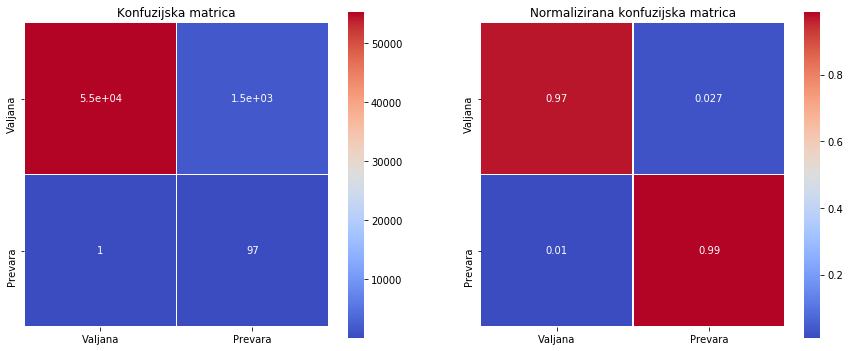

----------------------------------------------------------------------------------------------------
LGBM


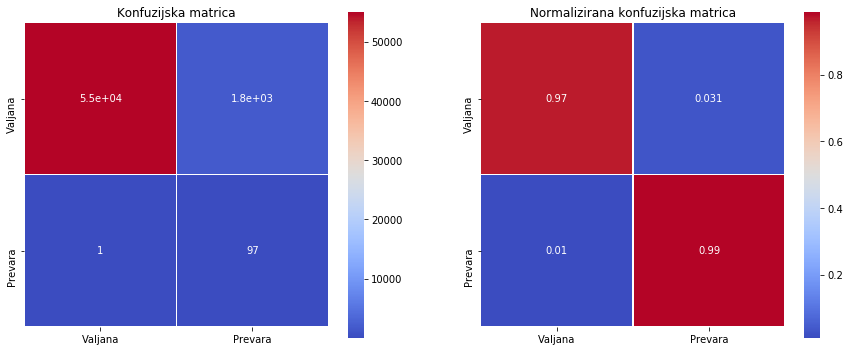

----------------------------------------------------------------------------------------------------
CatBoost


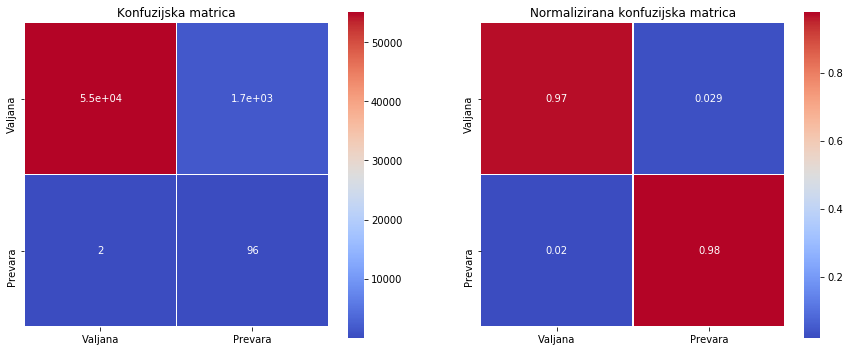

----------------------------------------------------------------------------------------------------
AdaBoost


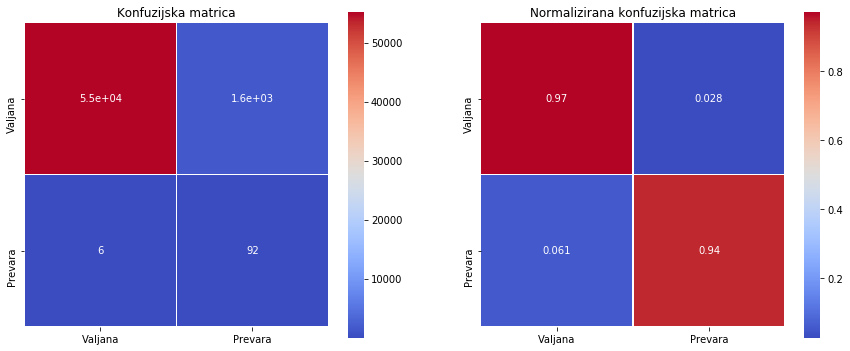

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [143]:
xgb_y_pred_full_params_cut = xgb_params_usample_cut.predict(X_data_test)
lgbm_y_pred_full_params_cut = lgbm_params_usample_cut.predict(X_data_test)
cat_y_pred_full_params_cut = cat_params_usample_cut.predict(X_data_test)
ada_y_pred_full_params_cut = ada_params_usample_cut.predict(X_data_test)

print('--'*50)
print('Testiranje (na cijelom datasetu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('XGB')
precision_recall_f1_scores(y_data_test, xgb_y_pred_full_params_cut)
print('--'*50)
print('LGBM')
precision_recall_f1_scores(y_data_test, lgbm_y_pred_full_params_cut)
print('--'*50)
print('CatBoost')
precision_recall_f1_scores(y_data_test, cat_y_pred_full_params_cut)
print('--'*50)
print('AdaBoost')
precision_recall_f1_scores(y_data_test, ada_y_pred_full_params_cut)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('XGB')
print(classification_report(y_data_test, xgb_y_pred_full_params_cut))
print('--'*50)
print('LGBM')
print(classification_report(y_data_test, lgbm_y_pred_full_params_cut))
print('--'*50)
print('CatBoost')
print(classification_report(y_data_test, cat_y_pred_full_params_cut))
print('--'*50)
print('AdaBoost')
print(classification_report(y_data_test, ada_y_pred_full_params_cut))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('XGB')
plot_confusion_matrix(confusion_matrix(y_data_test, xgb_y_pred_full_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('LGBM')
plot_confusion_matrix(confusion_matrix(y_data_test, lgbm_y_pred_full_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('CatBoost')
plot_confusion_matrix(confusion_matrix(y_data_test, cat_y_pred_full_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('AdaBoost')
plot_confusion_matrix(confusion_matrix(y_data_test, ada_y_pred_full_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('*'*100)


<p>Na kraju boostinga prokomentirajmo kakvi su rezultati kada maknemo outliere. <br>
Vidimo da je micanje outliera dosta pomoglo kod XGB-a. Taj model sad ispravno klasificira 97 prevara (od 98 ukupno). Ali model također pogrešno klasificira 1500 valjanih transakcija. LGBM je malo lošiji. Isto ima 97 ispravno klasificiranih prevara, ali i 1800 pogrešno klasificiranih valjanih transakcija. CatBoost je isto nešto lošiji sa 96 ispravno klasificiranih prevara, te 1700 pogrešno klasificiranih valjanih transakcija. Te naposlijetku Adaboost, koji je u ovom slučaju uspio ispravni klasificirati samo 92 prevare (što je i dalje puno, ali i dosta manje od ostala 3), te je pogrešno klasificirao 1600 valjanih transakcija.
</p>

## Klasifikacija glasanjem

In [82]:
#voting classifier


<p>Za kraj ćemo još upotrijebit klasifikaciju glasanjem. To je klasifikator koji je građen kao kombinacija više drugih klasifikatora. Ovaj pristup nećemo trenirati na originalnom skupu podataka, već samo na undersamplu. Prvo ćemo uzeti 4 različita glasačka klasifikatora.</p>
<ol>
    <li>Prvi glasački klasifikator - kombinacija logističke regresije, XGB-a i slučajnih šuma</li>
    <li>Drugi glasački klasifikator - kombinacija logističke regresije, XGB-a, slučajnih šuma i metode potpornih vektora</li>
    <li>Treći glasački klasifikator - kombinacija logističke regresije, XGB-a, slučajnih šuma, metode potpornih vektora i algoritma najbližih susjeda</li>
    <li>Drugi glasački klasifikator - kombinacija logističke regresije, LGBM-a, slučajnih šuma i metode potpornih vektora</li>
</ol>

In [98]:

print('Legenda metodi glasanja:')
print('(1) = logistička regresija, xgb, random forest')
print('(2) = logistička regresija, xgb, random forest, metoda potpornih vektora')
print('(3) = logistička regresija, xgb, random forest, metoda potpornih vektora, k (' + str(knn_params_best['n_neighbors']) + ') najbližih susjeda')
print('(4) = logistička regresija, lgbm, random forest')
print('-'*100)

voting1_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample)
])
voting1_usample.fit(X_usample_train, y_usample_train)
voting1_usample_training_score = cross_val_score(voting1_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: " + 
      str(round(voting1_usample_training_score.mean(), 4) * 100) + '%')


voting2_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample), ('svc', svc_params_usample)
])
voting2_usample.fit(X_usample_train, y_usample_train)
voting2_usample_training_score = cross_val_score(voting2_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: " + 
      str(round(voting2_usample_training_score.mean(), 4) * 100) + '%')



voting3_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('xgb', xgb_params_usample), 
    ('rf', rf_params_usample), ('svc', svc_params_usample), ('knn', knn_params_usample)
])
voting3_usample.fit(X_usample_train, y_usample_train)
voting3_usample_training_score = cross_val_score(voting3_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: " + 
      str(round(voting3_usample_training_score.mean(), 4) * 100) + '%')


voting4_usample = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample), ('lgbm', lgbm_params_usample), 
    ('rf', rf_params_usample)
])
voting4_usample.fit(X_usample_train, y_usample_train)
voting4_usample_training_score = cross_val_score(voting4_usample, X_usample_train, y_usample_train, cv=skfold)
print("Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom: " + 
      str(round(voting4_usample_training_score.mean(), 4) * 100) + '%')

Legenda metodi glasanja:
(1) = logistička regresija, xgb, random forest
(2) = logistička regresija, xgb, random forest, metoda potpornih vektora
(3) = logistička regresija, xgb, random forest, metoda potpornih vektora, k (3) najbližih susjeda
(4) = logistička regresija, lgbm, random forest
Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: 93.65%
Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: 93.39%
Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: 93.39%
Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom: 93.77%


----------------------------------------------------------------------------------------------------
Testiranje (na undersampleu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Voting1 (log_reg, xgb, rf)
	Precision score: 96.74000000000001%
	Recall score: 91.75%
	F1 score: 94.17999999999999%
----------------------------------------------------------------------------------------------------
Voting2 (log_reg, xgb, rf, svc)
	Precision score: 96.74000000000001%
	Recall score: 91.75%
	F1 score: 94.17999999999999%
----------------------------------------------------------------------------------------------------
Voting3 (log_reg, xgb, rf, svc, knn)
	Precision score: 95.74000000000001%
	Recall score: 92.78%
	F1 score: 94.24%
---------------------------------------------------------------------------------------------

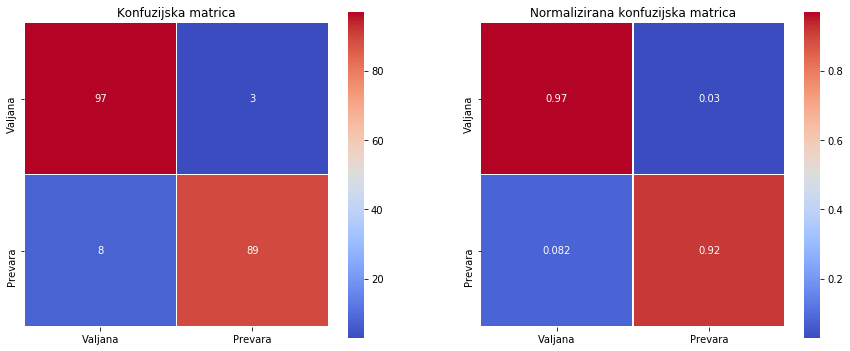

----------------------------------------------------------------------------------------------------
Voting2 (log_reg, xgb, rf, svc)


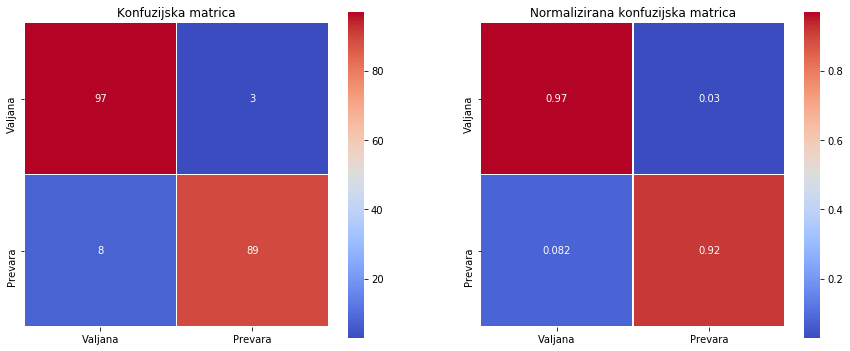

----------------------------------------------------------------------------------------------------
Voting3 (log_reg, xgb, rf, svc, knn)


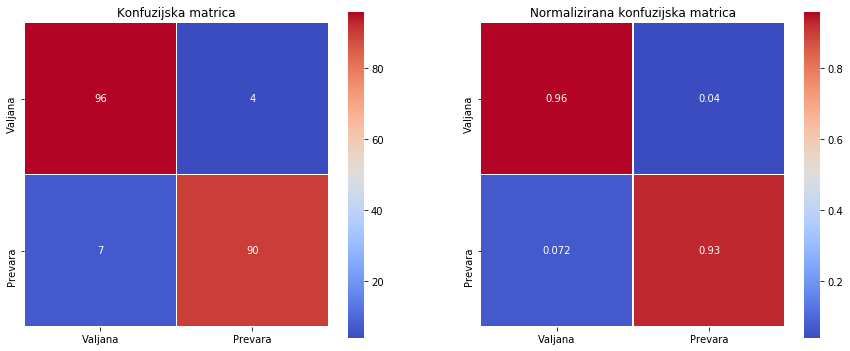

----------------------------------------------------------------------------------------------------
Voting4 (log_reg, lgbm, rf)


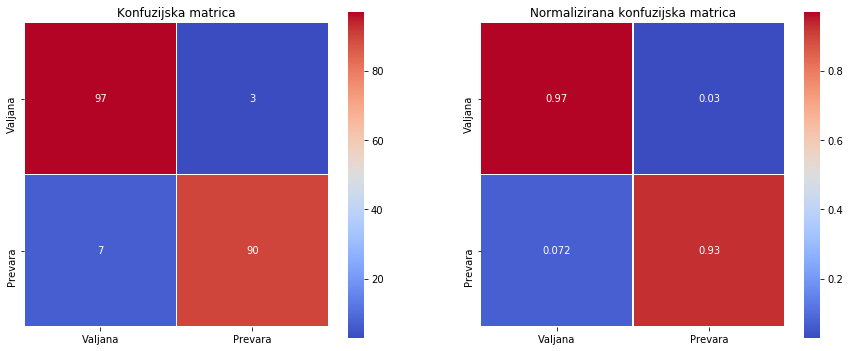

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [100]:
#testiranje

voting1_y_pred_usample_params = voting1_usample.predict(X_usample_test)
voting2_y_pred_usample_params = voting2_usample.predict(X_usample_test)
voting3_y_pred_usample_params = voting3_usample.predict(X_usample_test)
voting4_y_pred_usample_params = voting4_usample.predict(X_usample_test)


print('--'*50)
print('Testiranje (na undersampleu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('Voting1 (log_reg, xgb, rf)')
precision_recall_f1_scores(y_usample_test, voting1_y_pred_usample_params)
print('--'*50)
print('Voting2 (log_reg, xgb, rf, svc)')
precision_recall_f1_scores(y_usample_test, voting2_y_pred_usample_params)
print('--'*50)
print('Voting3 (log_reg, xgb, rf, svc, knn)')
precision_recall_f1_scores(y_usample_test, voting3_y_pred_usample_params)
print('--'*50)
print('Voting4 (log_reg, lgbm, rf)')
precision_recall_f1_scores(y_usample_test, voting4_y_pred_usample_params)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('Voting1 (log_reg, xgb, rf)')
print(classification_report(y_usample_test, voting1_y_pred_usample_params))
print('--'*50)
print('Voting2 (log_reg, xgb, rf, svc)')
print(classification_report(y_usample_test, voting2_y_pred_usample_params))
print('--'*50)
print('Voting3 (log_reg, xgb, rf, svc, knn)')
print(classification_report(y_usample_test, voting3_y_pred_usample_params))
print('--'*50)
print('Voting4 (log_reg, lgbm, rf)')
print(classification_report(y_usample_test, voting4_y_pred_usample_params))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('Voting1 (log_reg, xgb, rf)')
plot_confusion_matrix(confusion_matrix(y_usample_test, voting1_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('Voting2 (log_reg, xgb, rf, svc)')
plot_confusion_matrix(confusion_matrix(y_usample_test, voting2_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('Voting3 (log_reg, xgb, rf, svc, knn)')
plot_confusion_matrix(confusion_matrix(y_usample_test, voting3_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('Voting4 (log_reg, lgbm, rf)')
plot_confusion_matrix(confusion_matrix(y_usample_test, voting4_y_pred_usample_params), y_usample_test_non_fraud_num, y_usample_test_fraud_num)
print('--'*50)
print('*'*100)


----------------------------------------------------------------------------------------------------
Testiranje (na cijelom datasetu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Voting1 (log_reg, xgb, rf)
	Precision score: 6.88%
	Recall score: 92.86%
	F1 score: 12.82%
----------------------------------------------------------------------------------------------------
Voting2 (log_reg, xgb, rf, svc)
	Precision score: 8.25%
	Recall score: 92.86%
	F1 score: 15.15%
----------------------------------------------------------------------------------------------------
Voting3 (log_reg, xgb, rf, svc, knn)
	Precision score: 7.049999999999999%
	Recall score: 94.89999999999999%
	F1 score: 13.120000000000001%
----------------------------------------------------------------------------------------------------
Voting4 (log_

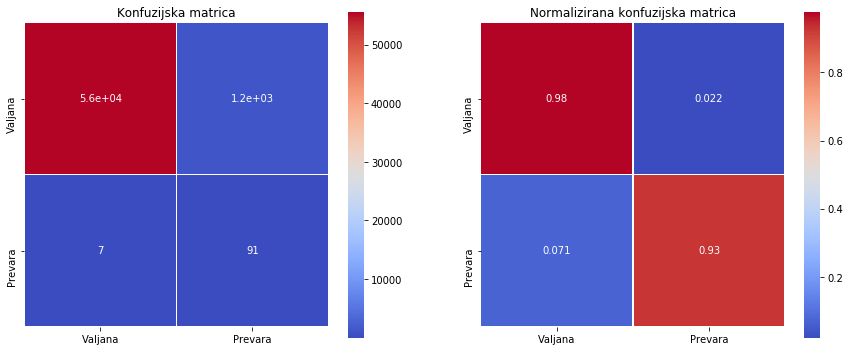

----------------------------------------------------------------------------------------------------
Voting2 (log_reg, xgb, rf, svc)


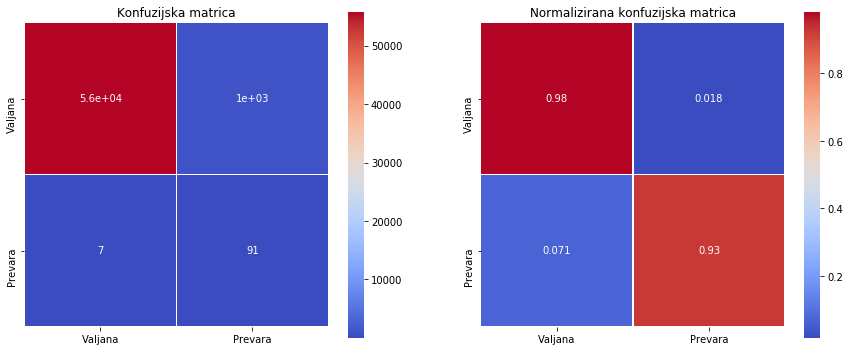

----------------------------------------------------------------------------------------------------
Voting3 (log_reg, xgb, rf, svc, knn)


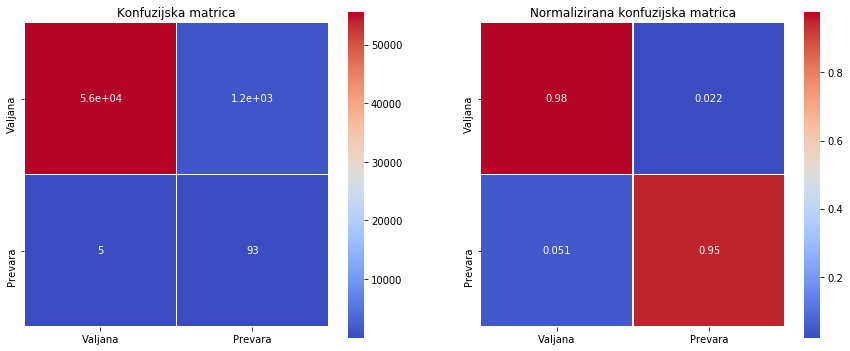

----------------------------------------------------------------------------------------------------
Voting4 (log_reg, lgbm, rf)


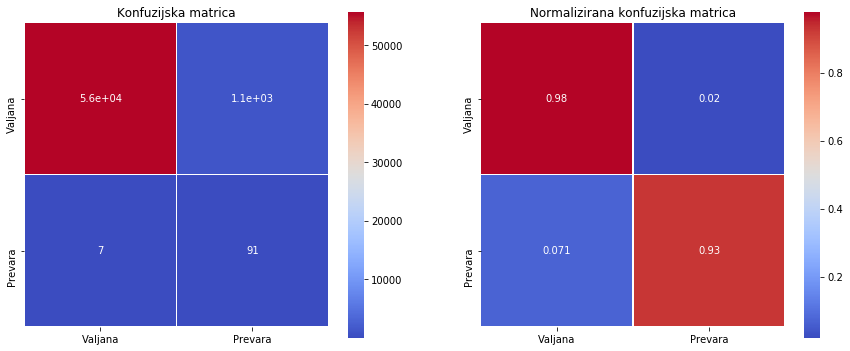

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [101]:
voting1_y_pred_full_params = voting1_usample.predict(X_data_test)
voting2_y_pred_full_params = voting2_usample.predict(X_data_test)
voting3_y_pred_full_params = voting3_usample.predict(X_data_test)
voting4_y_pred_full_params = voting4_usample.predict(X_data_test)

print('--'*50)
print('Testiranje (na cijelom datasetu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('Voting1 (log_reg, xgb, rf)')
precision_recall_f1_scores(y_data_test, voting1_y_pred_full_params)
print('--'*50)
print('Voting2 (log_reg, xgb, rf, svc)')
precision_recall_f1_scores(y_data_test, voting2_y_pred_full_params)
print('--'*50)
print('Voting3 (log_reg, xgb, rf, svc, knn)')
precision_recall_f1_scores(y_data_test, voting3_y_pred_full_params)
print('--'*50)
print('Voting4 (log_reg, lgbm, rf)')
precision_recall_f1_scores(y_data_test, voting4_y_pred_full_params)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('Voting1 (log_reg, xgb, rf)')
print(classification_report(y_data_test, voting1_y_pred_full_params))
print('--'*50)
print('Voting2 (log_reg, xgb, rf, svc)')
print(classification_report(y_data_test, voting2_y_pred_full_params))
print('--'*50)
print('Voting3 (log_reg, xgb, rf, svc, knn)')
print(classification_report(y_data_test, voting3_y_pred_full_params))
print('--'*50)
print('Voting4 (log_reg, xgb, rf, svc, knn)')
print(classification_report(y_data_test, voting4_y_pred_full_params))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('Voting1 (log_reg, xgb, rf)')
plot_confusion_matrix(confusion_matrix(y_data_test, voting1_y_pred_full_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('Voting2 (log_reg, xgb, rf, svc)')
plot_confusion_matrix(confusion_matrix(y_data_test, voting2_y_pred_full_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('Voting3 (log_reg, xgb, rf, svc, knn)')
plot_confusion_matrix(confusion_matrix(y_data_test, voting3_y_pred_full_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('Voting4 (log_reg, lgbm, rf)')
plot_confusion_matrix(confusion_matrix(y_data_test, voting4_y_pred_full_params), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('*'*100)


<p> Vidimo da su glasački klasifikatori bili prilično uspješni. Usporedimo sada rezultate. Vidimo da je prvi glasački klasifikator imao 1200 pogrešno klasificiranih valjanih transakcija i 7 pogrešno klasficiranih prevara, što i nije loše. Drugi je bio još bolji. On je pogrešno klasificirao samo 1000 valjnih transakcija (te 7 prevara). Za treći možemo reći da je bio još uspješniji (jer je pogrešno klasificirao 1200 valjanih transakcija i samo 5 prevara). Četvrti klasifikator je imao slične rezultate kao prvi i drugi (7 pogrešno klasificiranih prevara i 1100 valjanih transakcija). </p>

<p>Da bi bilo zanimljivije za treniranje na skupu bez outliera ćemo koristiti neke druge klasifikatore.</p>
<ol>
    <li>Prvi glasački klasifikator - kombinacija logističke regresije i adaboosta</li>
    <li>Drugi glasački klasifikator - kombinacija logističke regresije, adaboosta i slučajnih šuma</li>
    <li>Treći glasački klasifikator - kombinacija logističke regresije, adaboosta i stabla odluke</li>
    <li>Četvrti glasački klasifikator - kombinacija adaboosta i slučajnih šuma</li>
</ol>

In [111]:

print('Legenda metodi glasanja:')
print('(1) = logistička regresija, adaboost')
print('(2) = logistička regresija, adaboost, random forest')
print('(3) = logistička regresija, adaboost, stabla odluke')
print('(4) = adaboost , random forest')

voting1_usample_cut = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample_cut), ('ada', ada_params_usample_cut)
])
voting1_usample_cut.fit(X_usample_cut_train, y_usample_cut_train)
voting1_usample_training_score_cut = cross_val_score(voting1_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print("Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: " + 
      str(round(voting1_usample_training_score_cut.mean(), 4) * 100) + '%')


voting2_usample_cut = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample_cut), ('ada', ada_params_usample_cut), 
    ('rf', rf_params_usample_cut)
])
voting2_usample_cut.fit(X_usample_cut_train, y_usample_cut_train)
voting2_usample_training_score_cut = cross_val_score(voting2_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print("Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: " + 
      str(round(voting2_usample_training_score_cut.mean(), 4) * 100) + '%')



voting3_usample_cut = VotingClassifier(estimators=[
    ('log_reg', log_reg_params_usample_cut), ('ada', ada_params_usample_cut), 
    ('dt', dt_params_usample_cut)
])
voting3_usample_cut.fit(X_usample_cut_train, y_usample_cut_train)
voting3_usample_training_score_cut = cross_val_score(voting3_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print("Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: " + 
      str(round(voting3_usample_training_score_cut.mean(), 4) * 100) + '%')


voting4_usample_cut = VotingClassifier(estimators=[
    ('rf', rf_params_usample_cut), ('ada', ada_params_usample_cut), 
])
voting4_usample_cut.fit(X_usample_cut_train, y_usample_cut_train)
voting4_usample_training_score_cut = cross_val_score(voting4_usample_cut, X_usample_cut_train, y_usample_cut_train, cv=skfold)
print("Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom: " + 
      str(round(voting4_usample_training_score_cut.mean(), 4) * 100) + '%')

Legenda metodi glasanja:
(1) = logistička regresija, adaboost
(2) = logistička regresija, adaboost, random forest
(3) = logistička regresija, adaboost, stabla odluke
(4) = adaboost , random forest
Rezultat treniranja za metodu glasanja (1) nad undersampliranim datasetom: 93.58%
Rezultat treniranja za metodu glasanja (2) nad undersampliranim datasetom: 93.32000000000001%
Rezultat treniranja za metodu glasanja (3) nad undersampliranim datasetom: 93.45%
Rezultat treniranja za metodu glasanja (4) nad undersampliranim datasetom: 92.25%


----------------------------------------------------------------------------------------------------
Testiranje (na undersampleu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Voting1 (AdaBoost, log_reg)
	Precision score: 98.75%
	Recall score: 87.78%
	F1 score: 92.94%
----------------------------------------------------------------------------------------------------
Voting2 (AdaBoost, log_reg, rf)
	Precision score: 96.43%
	Recall score: 90.0%
	F1 score: 93.10000000000001%
----------------------------------------------------------------------------------------------------
Voting3 (AdaBoost, log_reg, dt)
	Precision score: 97.59%
	Recall score: 90.0%
	F1 score: 93.64%
----------------------------------------------------------------------------------------------------
Voting4 (AdaBoost, rf)
	Precision score: 100.0

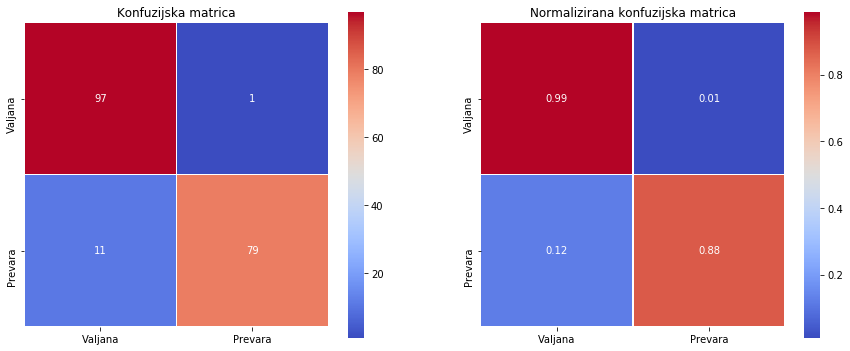

----------------------------------------------------------------------------------------------------
LGBM


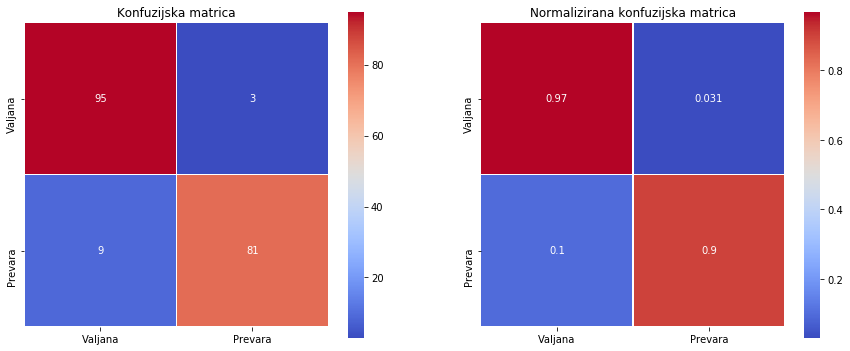

----------------------------------------------------------------------------------------------------
CatBoost


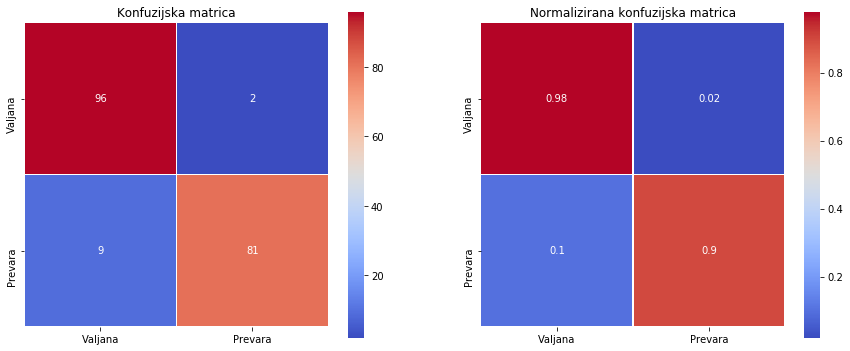

----------------------------------------------------------------------------------------------------
AdaBoost


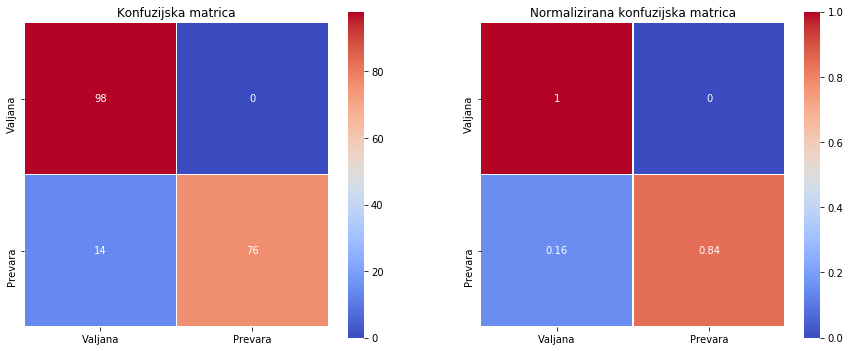

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [112]:
voting1_y_pred_usample_params_cut = voting1_usample_cut.predict(X_usample_cut_test)
voting2_y_pred_usample_params_cut = voting2_usample_cut.predict(X_usample_cut_test)
voting3_y_pred_usample_params_cut = voting3_usample_cut.predict(X_usample_cut_test)
voting4_y_pred_usample_params_cut = voting4_usample_cut.predict(X_usample_cut_test)

print('--'*50)
print('Testiranje (na undersampleu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('Voting1 (AdaBoost, log_reg)')
precision_recall_f1_scores(y_usample_cut_test, voting1_y_pred_usample_params_cut)
print('--'*50)
print('Voting2 (AdaBoost, log_reg, rf)')
precision_recall_f1_scores(y_usample_cut_test, voting2_y_pred_usample_params_cut)
print('--'*50)
print('Voting3 (AdaBoost, log_reg, dt)')
precision_recall_f1_scores(y_usample_cut_test, voting3_y_pred_usample_params_cut)
print('--'*50)
print('Voting4 (AdaBoost, rf)')
precision_recall_f1_scores(y_usample_cut_test, voting4_y_pred_usample_params_cut)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('Voting1 (AdaBoost, log_reg)')
print(classification_report(y_usample_cut_test, voting1_y_pred_usample_params_cut))
print('--'*50)
print('Voting2 (AdaBoost, log_reg, rf)')
print(classification_report(y_usample_cut_test, voting2_y_pred_usample_params_cut))
print('--'*50)
print('Voting3 (AdaBoost, log_reg, dt)')
print(classification_report(y_usample_cut_test, voting3_y_pred_usample_params_cut))
print('--'*50)
print('Voting4 (AdaBoost, rf)')
print(classification_report(y_usample_cut_test, voting4_y_pred_usample_params_cut))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('XGB')
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, voting1_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('--'*50)
print('LGBM')
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, voting2_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('--'*50)
print('CatBoost')
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, voting3_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('--'*50)
print('AdaBoost')
plot_confusion_matrix(confusion_matrix(y_usample_cut_test, voting4_y_pred_usample_params_cut), y_usample_cut_test_non_fraud_num, y_usample_cut_test_fraud_num)
print('--'*50)
print('*'*100)


----------------------------------------------------------------------------------------------------
Testiranje (na cijelom datasetu):
Precision-recall-f1:
****************************************************************************************************
----------------------------------------------------------------------------------------------------
Voting1 (AdaBoost, log_reg)
	Precision score: 8.5%
	Recall score: 89.8%
	F1 score: 15.53%
----------------------------------------------------------------------------------------------------
Voting2 (AdaBoost, log_reg, rf)
	Precision score: 7.580000000000001%
	Recall score: 92.86%
	F1 score: 14.01%
----------------------------------------------------------------------------------------------------
Voting3 (AdaBoost, log_reg, dt)
	Precision score: 7.76%
	Recall score: 92.86%
	F1 score: 14.330000000000002%
----------------------------------------------------------------------------------------------------
Voting4 (AdaBoost, rf)
	Precisi

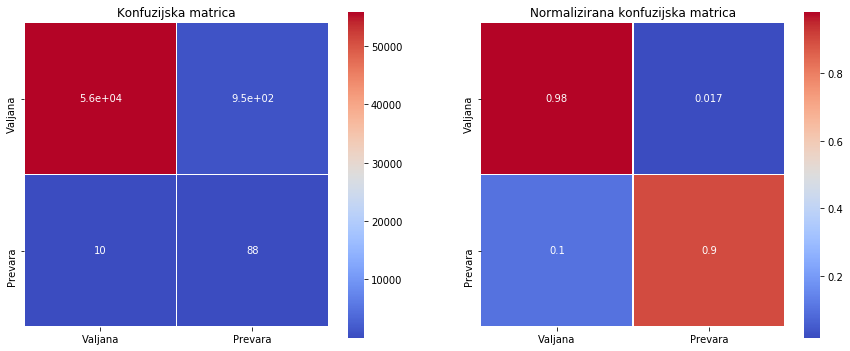

----------------------------------------------------------------------------------------------------
Voting2 (AdaBoost, log_reg, rf)


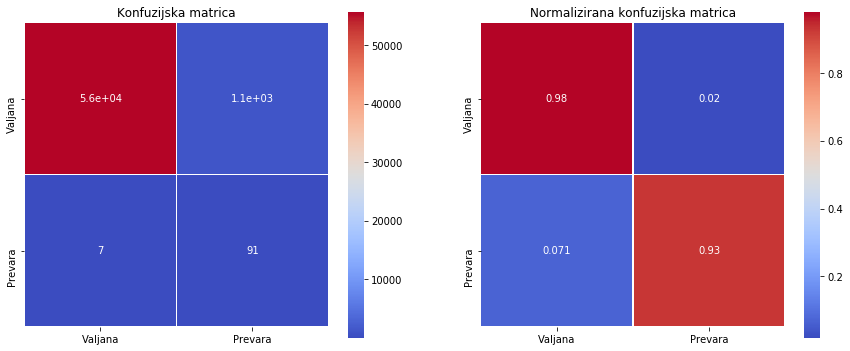

----------------------------------------------------------------------------------------------------
Voting3 (AdaBoost, log_reg, dt)


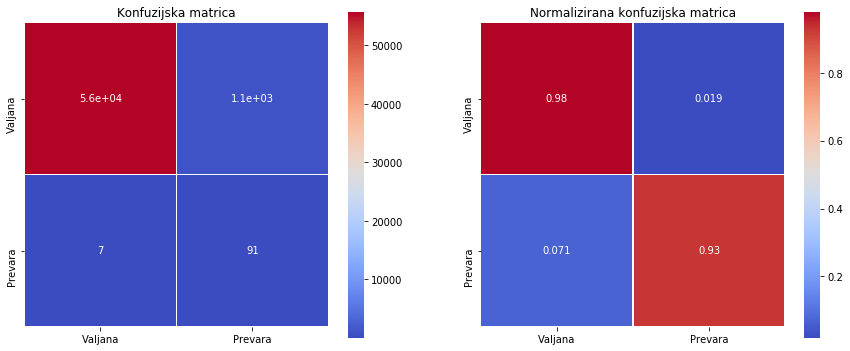

----------------------------------------------------------------------------------------------------
Voting4 (AdaBoost, rf)


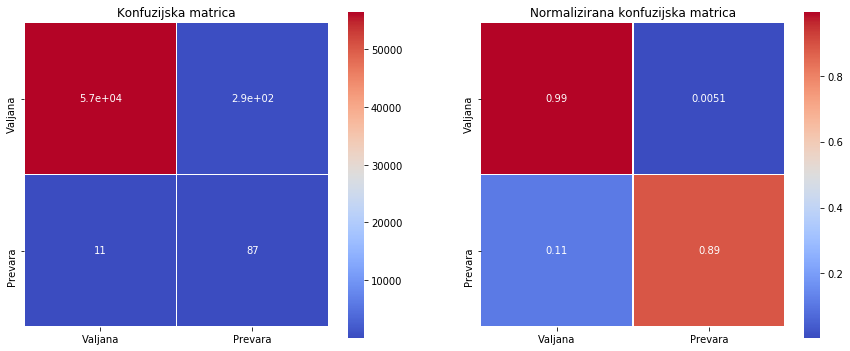

----------------------------------------------------------------------------------------------------
****************************************************************************************************


In [113]:
voting1_y_pred_full_params_cut = voting1_usample_cut.predict(X_data_test)
voting2_y_pred_full_params_cut = voting2_usample_cut.predict(X_data_test)
voting3_y_pred_full_params_cut = voting3_usample_cut.predict(X_data_test)
voting4_y_pred_full_params_cut = voting4_usample_cut.predict(X_data_test)

print('--'*50)
print('Testiranje (na cijelom datasetu):')
print('Precision-recall-f1:')
print('*'*100)
print('--'*50)
print('Voting1 (AdaBoost, log_reg)')
precision_recall_f1_scores(y_data_test, voting1_y_pred_full_params_cut)
print('--'*50)
print('Voting2 (AdaBoost, log_reg, rf)')
precision_recall_f1_scores(y_data_test, voting2_y_pred_full_params_cut)
print('--'*50)
print('Voting3 (AdaBoost, log_reg, dt)')
precision_recall_f1_scores(y_data_test, voting3_y_pred_full_params_cut)
print('--'*50)
print('Voting4 (AdaBoost, rf)')
precision_recall_f1_scores(y_data_test, voting4_y_pred_full_params_cut)
print('--'*50)
print('*'*100)
print('Klasifikacijski report:')
print('*'*100)
print('--'*50)
print('Voting1 (AdaBoost, log_reg)')
print(classification_report(y_data_test, voting1_y_pred_full_params_cut))
print('--'*50)
print('Voting2 (AdaBoost, log_reg, rf)')
print(classification_report(y_data_test, voting2_y_pred_full_params_cut))
print('--'*50)
print('Voting3 (AdaBoost, log_reg, dt)')
print(classification_report(y_data_test, voting3_y_pred_full_params_cut))
print('--'*50)
print('Voting4 (AdaBoost, rf)')
print(classification_report(y_data_test, voting4_y_pred_full_params_cut))
print('--'*50)
print('*'*100)
print('Konfuzijske matrice:')
print('*'*100)
print('--'*50)
print('Voting1 (AdaBoost, log_reg)')
plot_confusion_matrix(confusion_matrix(y_data_test, voting1_y_pred_full_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('Voting2 (AdaBoost, log_reg, rf)')
plot_confusion_matrix(confusion_matrix(y_data_test, voting2_y_pred_full_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('Voting3 (AdaBoost, log_reg, dt)')
plot_confusion_matrix(confusion_matrix(y_data_test, voting3_y_pred_full_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('Voting4 (AdaBoost, rf)')
plot_confusion_matrix(confusion_matrix(y_data_test, voting4_y_pred_full_params_cut), y_data_test_non_fraud_num, y_data_test_fraud_num)
print('--'*50)
print('*'*100)


<p>Prokomentirajmo rezultate. Vidimo da je prvi glasački klasifikator dobio solidne rezultate. Pogrešno je klasificirao 950 valjanih transakcija, te 10 prevara (što je malo lošije od prošlog prvog klasifikatora). Drugi klasifikator je imao nešto bolje rezultate. On je pogrešno klasificirao 7 prevara i 1100 valjanih transakcija. Treći klasifikator je imao potpuno iste rezultate kao i drugi. Četvrti klasifikator dao nam je dosta zanimljive rezultate (on jedini nema logističku regresiju kao glasača). Taj klasifikator je pogrešno klasificirao 11 prevara i samo 290 valjanih transakcija.</p>